# Início

https://www.kaggle.com/competitions/ieee-fraud-detection

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Este notebook engloba os seguinte passos:

* Feature Engineering
    * Tratando Colunas com Valores Faltantes (deletar colunas com 75% de valores faltantes)
    * Tratando Colunas com valores únicos (deletar)
    * Tratando Linhas com Valores Faltantes (deletar linhas com 75% de valores faltantes)
    * Substituindo NaNs remanescentes por média e moda
    * Codificação de variáveis categóricas
* Separação entre base de treino e de teste, a partir da base de treino
* Balanceamento de classes
    * Undersample
        * Resample
        * Random UnderSampling (RUS)
        * Near Miss
        * Instance Hardness Threshold
    * Oversample
        * Resample
        * Random OverSampling (ROS)
        * SMOTE
        * Borderline SMOTE
        * AdaSyn
* Treinamento dos algoritmos e análise de desempenho
    * Algoritmos utilizados
        * Extra Trees
        * Decision Tree
    * Métricas de desempenho por threshold (0,05 a 0,50) e por técnica de balanceamento
        * F1-score positivo (iteração por iteração)
        * Wall time

# Importando Bibliotecas

In [1]:
# inicializando cronômetro
import time
t0 = time.time()

In [2]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.precision = 15

import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------
|  0 |  1% | 10% |


In [5]:
#limpando cache do CUDA para melhor desempenho do paralelismo
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [6]:
folder_path = 'C:/Users/arthu/Desktop/codigo_dissertacao/input/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade associada às transações (p.ex., IP e browser utilizado)
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [7]:
creditcard = pd.read_csv(f'{folder_path}creditcard.csv')

# Análise Exploratória de Dados

## Estatística Básica

In [8]:
# função resumetable traz as estatísticas básicas do conjunto de dados
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [9]:
resumetable(creditcard)

Dataset Shape: (284807, 31)


Name   dtypes  Missing  Uniques          First Value       Second Value  \
0     Time  float64        0   124592    0.000000000000000  0.000000000000000   
1       V1  float64        0   275663   -1.359807133673800  1.191857111314860   
2       V2  float64        0   275663   -0.072781173309850  0.266150712059630   
3       V3  float64        0   275663    2.536346737969140  0.166480113353210   
4       V4  float64        0   275663    1.378155224274430  0.448154078460911   
5       V5  float64        0   275663   -0.338320769942518  0.060017649282224   
6       V6  float64        0   275663    0.462387777762292 -0.082360808815569   
7       V7  float64        0   275663    0.239598554061257 -0.078802983332311   
8       V8  float64        0   275663    0.098697901261051  0.085101654914810   
9       V9  float64        0   275663    0.363786969611213 -0.255425128109186   
10     V10  float64        0   275663    0.090794171978932 -0.166974414004614   
11     V11  float64        0   275663   -0.551599533260813  1.612726661054790   
12     V12  float64        0   275663   -0.617800855762348  1.065235311372870   
13     V13  float64        0   275663   -0.991389847235408  0.489095015896080   
14     V14  float64        0   275663   -0.311169353699879 -0.143772296441519   
15     V15  float64        0   275663    1.468176972094270  0.635558093258208   
16     V16  float64        0   275663   -0.470400525259478  0.463917041022171   
17     V17  float64        0   275663    0.207971241929242 -0.114804663102346   
18     V18  float64        0   275663    0.025790580198559 -0.183361270123994   
19     V19  float64        0   275663    0.403992960255733 -0.145783041325259   
20     V20  float64        0   275663    0.251412098239705 -0.069083135223020   
21     V21  float64        0   275663   -0.018306777944153 -0.225775248033138   
22     V22  float64        0   275663    0.277837575558899 -0.638671952771851   
23     V23  float64        0   275663   -0.110473910188767  0.101288021253234   
24     V24  float64        0   275663    0.066928074914673 -0.339846475529127   
25     V25  float64        0   275663    0.128539358273528  0.167170404418143   
26     V26  float64        0   275663   -0.189114843888824  0.125894532368176   
27     V27  float64        0   275663    0.133558376740387 -0.008983099143228   
28     V28  float64        0   275663   -0.021053053453821  0.014724169192493   
29  Amount  float64        0    32767  149.620000000000005  2.690000000000000   
30   Class    int64        0        2    0.000000000000000  0.000000000000000   

            Third Value             Entropy  
0     1.000000000000000  16.690000000000001  
1    -1.358354061598230  18.030000000000001  
2    -1.340163074736090  18.030000000000001  
3     1.773209342631190  18.030000000000001  
4     0.379779593034328  18.030000000000001  
5    -0.503198133318193  18.030000000000001  
6     1.800499380792630  18.030000000000001  
7     0.791460956450422  18.030000000000001  
8     0.247675786588991  18.030000000000001  
9    -1.514654322605830  18.030000000000001  
10    0.207642865216696  18.030000000000001  
11    0.624501459424895  18.030000000000001  
12    0.066083685268831  18.030000000000001  
13    0.717292731410831  18.030000000000001  
14   -0.165945922763554  18.030000000000001  
15    2.345864949015810  18.030000000000001  
16   -2.890083194442310  18.030000000000001  
17    1.109969378695990  18.030000000000001  
18   -0.121359313195888  18.030000000000001  
19   -2.261857095304140  18.030000000000001  
20    0.524979725224404  18.030000000000001  
21    0.247998153469754  18.030000000000001  
22    0.771679401917229  18.030000000000001  
23    0.909412262347719  18.030000000000001  
24   -0.689280956490685  18.030000000000001  
25   -0.327641833735251  18.030000000000001  
26   -0.139096571514147  18.030000000000001  
27   -0.055352794038426  18.030000000000001  
28   -0.059751840592920  18.030000000000001  
29  378.660000000000025  11.50000

In [10]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


Name   dtypes  Missing  Uniques First Value Second Value  \
0    TransactionID    int64        0   590540     2987000      2987001   
1          isFraud    int64        0        2           0            0   
2    TransactionDT    int64        0   573349       86400        86401   
3   TransactionAmt  float64        0    20902        68.5         29.0   
4        ProductCD   object        0        5           W            W   
5            card1    int64        0    13553       13926         2755   
6            card2  float64     8933      500         NaN        404.0   
7            card3  float64     1565      114       150.0        150.0   
8            card4   object     1577        4    discover   mastercard   
9            card5  float64     4259      119       142.0        102.0   
10           card6   object     1571        4      credit       credit   
11           addr1  float64    65706      332       315.0        325.0   
12           addr2  float64    65706       74        87.0         87.0   
13           dist1  float64   352271     2651        19.0          NaN   
14           dist2  float64   552913     1751         NaN          NaN   
15   P_emaildomain   object    94456       59         NaN    gmail.com   
16   R_emaildomain   object   453249       60         NaN          NaN   
17              C1  float64        0     1657         1.0          1.0   
18              C2  float64        0     1216         1.0          1.0   
19              C3  float64        0       27         0.0          0.0   
20              C4  float64        0     1260         0.0          0.0   
21              C5  float64        0      319         0.0          0.0   
22              C6  float64        0     1328         1.0          1.0   
23              C7  float64        0     1103         0.0          0.0   
24              C8  float64        0     1253         0.0          0.0   

    Third Value             Entropy  
0       2987002  19.170000000000002  
1             0   0.220000000000000  
2         86469  19.109999999999999  
3          59.0   8.350000000000000  
4             W   1.280000000000000  
5          4663   9.970000000000001  
6         490.0   6.320000000000000  
7         150.0   0.680000000000000  
8          visa   1.090000000000000  
9         166.0   2.660000000000000  
10        debit   0.820000000000000  
11        330.0   5.060000000000000  
12         87.0   0.080000000000000  
13        287.0   6.340000000000000  
14          NaN   7.420000000000000  
15  outlook.com   2.680000000000000  
16          NaN   2.760000000000000  
17          1.0   2.720000000000000  
18          1.0   2.750000000000000  
19          0.0   0.040000000000000  
20          0.0   1.120000000000000  
21          0.0   2.060000000000000  
22          1.0   2.520000000000000  
23          0.0   0.710000000000000  
24          0.0   1.250000000000000

In [11]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


Name   dtypes  Missing  Uniques         First Value  \
0    TransactionID    int64        0   506691             3663549   
1    TransactionDT    int64        0   494686            18403224   
2   TransactionAmt  float64        0    14119  31.949999999999999   
3        ProductCD   object        0        5                   W   
4            card1    int64        0    13244               10409   
5            card2  float64     8654      497               111.0   
6            card3  float64     3002      115               150.0   
7            card4   object     3086        4                visa   
8            card5  float64     4547      102               226.0   
9            card6   object     3007        3               debit   
10           addr1  float64    65609      292               170.0   
11           addr2  float64    65609       72                87.0   
12           dist1  float64   291217     1988                 1.0   
13           dist2  float64   470255     1814                 NaN   
14   P_emaildomain   object    69192       60           gmail.com   
15   R_emaildomain   object   370821       60                 NaN   
16              C1  float64        3     1174                 6.0   
17              C2  float64        3     1123                 6.0   
18              C3  float64        3       31                 0.0   
19              C4  float64        3      728                 0.0   
20              C5  float64        3      353                 3.0   
21              C6  float64        3      834                 4.0   
22              C7  float64        3      518                 0.0   
23              C8  float64        3      442                 0.0   
24              C9  float64        3      354                 6.0   

   Second Value  Third Value             Entropy  
0       3663550      3663551  18.949999999999999  
1      18403263     18403310  18.899999999999999  
2          49.0        171.0   8.080000000000000  
3             W            W   1.370000000000000  
4          4272         4476   9.949999999999999  
5         111.0        574.0   6.280000000000000  
6         150.0        150.0   0.810000000000000  
7          visa         visa   1.050000000000000  
8         226.0        226.0   2.630000000000000  
9         debit        debit   0.790000000000000  
10        299.0        472.0   5.100000000000000  
11         87.0         87.0   0.110000000000000  
12          4.0       2635.0   5.990000000000000  
13          NaN          NaN   7.900000000000000  
14      aol.com  hotmail.com   2.670000000000000  
15          NaN          NaN   2.690000000000000  
16          3.0          2.0   2.680000000000000  
17          2.0          2.0   2.760000000000000  
18          0.0          0.0   0.180000000000000  
19          0.0          0.0   1.210000000000000  
20          0.0          0.0   1.930000000000000  
21          1.0          5.0   2.470000000000000  
22          0.0          0.0   0.820000000000000  
23          0.0          0.0   1.360000000000000  
24          2.0          4.0   2.610000000000000

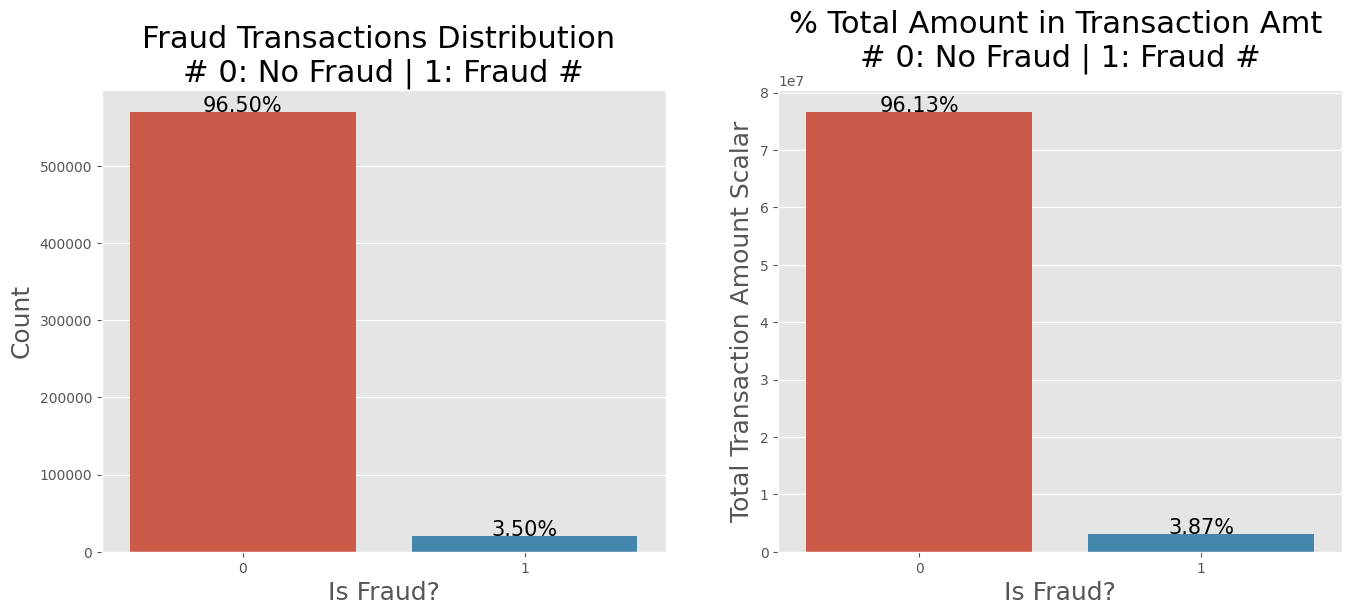

In [12]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

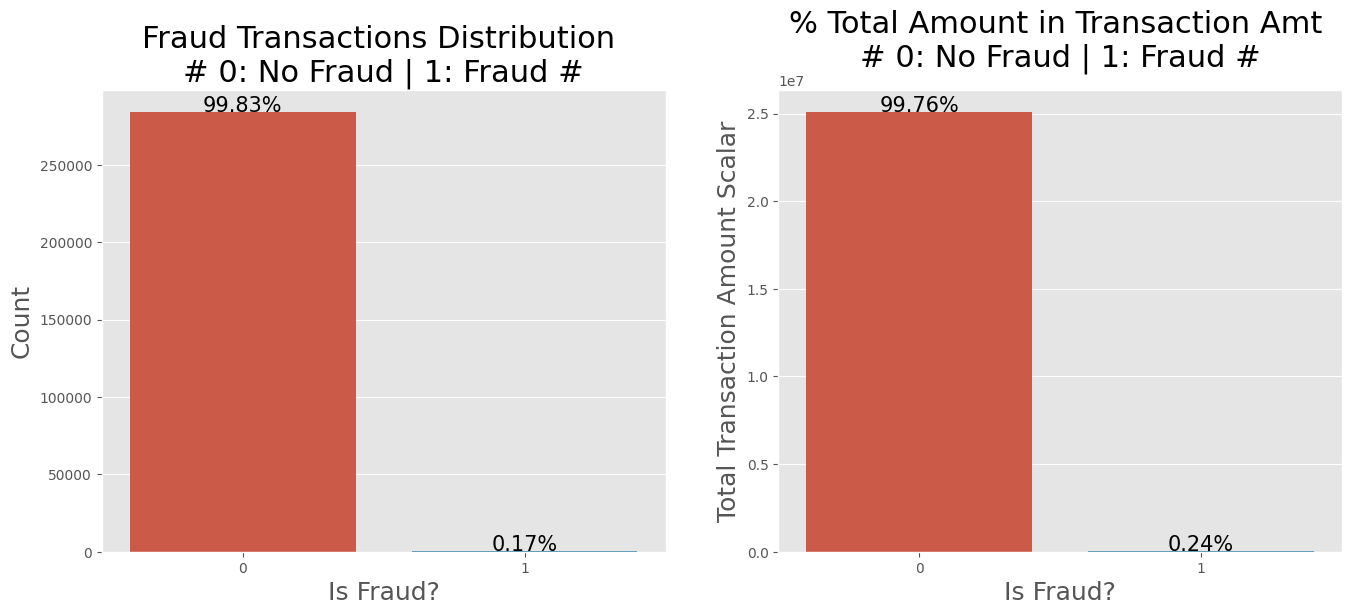

In [13]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
creditcard['Amount'] = creditcard['Amount'].astype(float)
total = len(creditcard)
total_amt = creditcard.groupby(['Class'])['Amount'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'Class', data = creditcard, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (creditcard.groupby(['Class'])['Amount'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'Class', y = 'Amount', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

# Feature Engineering (Dataset 01)

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [14]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [15]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [16]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
pd.reset_option('display.max_rows')

In [17]:
train

TransactionID  isFraud  TransactionDT       TransactionAmt ProductCD  \
0             2987000        0          86400   68.500000000000000         W   
1             2987001        0          86401   29.000000000000000         W   
2             2987002        0          86469   59.000000000000000         W   
3             2987003        0          86499   50.000000000000000         W   
4             2987004        0          86506   50.000000000000000         H   
...               ...      ...            ...                  ...       ...   
590535        3577535        0       15811047   49.000000000000000         W   
590536        3577536        0       15811049   39.500000000000000         W   
590537        3577537        0       15811079   30.949999999999999         W   
590538        3577538        0       15811088  117.000000000000000         W   
590539        3577539        0       15811131  279.949999999999989         W   

        card1  card2  card3       card4  card5  ... id_35  id_36  id_37  \
0       13926    NaN  150.0    discover  142.0  ...   NaN    NaN    NaN   
1        2755  404.0  150.0  mastercard  102.0  ...   NaN    NaN    NaN   
2        4663  490.0  150.0        visa  166.0  ...   NaN    NaN    NaN   
3       18132  567.0  150.0  mastercard  117.0  ...   NaN    NaN    NaN   
4        4497  514.0  150.0  mastercard  102.0  ...     T      F      T   
...       ...    ...    ...         ...    ...  ...   ...    ...    ...   
590535   6550    NaN  150.0        visa  226.0  ...   NaN    NaN    NaN   
590536  10444  225.0  150.0  mastercard  224.0  ...   NaN    NaN    NaN   
590537  12037  595.0  150.0  mastercard  224.0  ...   NaN    NaN    NaN   
590538   7826  481.0  150.0  mastercard  224.0  ...   NaN    NaN    NaN   
590539  15066  170.0  150.0  mastercard  102.0  ...   NaN    NaN    NaN   

        id_38  DeviceType                     DeviceInfo                Date  \
0         NaN         NaN                            NaN 2017-12-02 00:00:00   
1         NaN         NaN                            NaN 2017-12-02 00:00:01   
2         NaN         NaN                            NaN 2017-12-02 00:01:09   
3         NaN         NaN                            NaN 2017-12-02 00:01:39   
4           T      mobile  SAMSUNG SM-G892A Build/NRD90M 2017-12-02 00:01:46   
...       ...         ...                            ...                 ...   
590535    NaN         NaN                            NaN 2018-06-01 23:57:27   
590536    NaN         NaN                            NaN 2018-06-01 23:57:29   
590537    NaN         NaN                            NaN 2018-06-01 23:57:59   
590538    NaN         NaN                            NaN 2018-06-01 23:58:08   
590539    NaN         NaN                            NaN 2018-06-01 23:58:51   

        _Weekdays  _Hours  _Days  
0               5       0      2  
1               5       0      2  
2               5       0      2  
3               5       0      2  
4               5       0      2  
...           ...     ...    ...  
590535          4      23      1  
590536          4      23      1  
590537          4      23      1  
590538          4      23      1  
590539          4      23      1  

[590540 rows x 438 columns]

## Equalizando nomes de colunas entre bases de treino e teste

In [18]:
# importante para seguir com ajustes na base de forma otimizada
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [19]:
# ajustar colunas de teste
test.columns = test.columns.str.replace('-', '_')

In [20]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [21]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [22]:
# lista completa de colunas com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

In [23]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

In [24]:
many_null_cols_train

['dist2',
 'R_emaildomain',
 'D6',
 'D7',
 'D8',
 'D9',
 'D12',
 'D13',
 'D14',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 '

In [25]:
len(many_null_cols_train)

208

In [26]:
many_null_cols_test

['dist2',
 'D6',
 'D7',
 'D8',
 'D9',
 'D12',
 'D13',
 'D14',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337',
 'V338',
 'V339',
 'id_03',
 'id_04',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_14',
 'id_16',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_30',
 'id_32',
 'id_33',
 'id_34',
 'DeviceInfo']

In [27]:
len(many_null_cols_test)

76

## Tratando Colunas com Valores Únicos

In [28]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [29]:
# identificando colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [30]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_train = [col for col in train.columns if \
                            train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
                                                                                 normalize=True).values[0] > 0.75]

In [31]:
big_top_value_cols_train

['isFraud',
 'card3',
 'addr2',
 'dist2',
 'R_emaildomain',
 'C3',
 'C4',
 'C7',
 'C8',
 'C10',
 'C12',
 'D6',
 'D7',
 'D8',
 'D9',
 'D12',
 'D13',
 'D14',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V31',
 'V32',
 'V33',
 'V34',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V71',
 'V72',
 'V73',
 'V77',
 'V78',
 'V86',
 'V87',
 'V88',
 'V89',
 'V95',
 'V97',
 'V98',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V128',
 'V129',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V

In [32]:
len(big_top_value_cols_train)

330

In [33]:
big_top_value_cols_test

['card3',
 'card6',
 'addr2',
 'dist2',
 'C3',
 'C7',
 'D6',
 'D7',
 'D8',
 'D9',
 'D12',
 'D13',
 'D14',
 'V14',
 'V15',
 'V16',
 'V19',
 'V20',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V33',
 'V34',
 'V37',
 'V38',
 'V41',
 'V44',
 'V45',
 'V46',
 'V47',
 'V55',
 'V56',
 'V57',
 'V58',
 'V61',
 'V62',
 'V65',
 'V66',
 'V67',
 'V68',
 'V73',
 'V74',
 'V77',
 'V78',
 'V79',
 'V82',
 'V83',
 'V86',
 'V87',
 'V88',
 'V89',
 'V94',
 'V95',
 'V97',
 'V98',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V128',
 'V129',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V

In [34]:
len(big_top_value_cols_test)

195

## Concatenando as Colunas Desnecessárias e Removendo-as

In [35]:
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + \
                        one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'isFraud' da remoção
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [36]:
cols_to_drop

['V286',
 'V144',
 'V288',
 'V165',
 'V230',
 'V83',
 'V272',
 'V209',
 'V23',
 'V264',
 'V297',
 'V183',
 'V215',
 'V112',
 'V322',
 'id_30',
 'V211',
 'V243',
 'V22',
 'V110',
 'V224',
 'V136',
 'V199',
 'V278',
 'V181',
 'V279',
 'V56',
 'V222',
 'V72',
 'V254',
 'V339',
 'V241',
 'V146',
 'V170',
 'V129',
 'V116',
 'V261',
 'V244',
 'V219',
 'V18',
 'V318',
 'V82',
 'V334',
 'card6',
 'V178',
 'V157',
 'V175',
 'id_38',
 'V134',
 'V314',
 'D7',
 'V327',
 'V101',
 'V251',
 'V113',
 'V160',
 'V95',
 'V232',
 'V31',
 'V137',
 'C8',
 'V216',
 'V208',
 'V226',
 'V122',
 'V200',
 'V100',
 'V27',
 'id_24',
 'V114',
 'id_31',
 'V47',
 'V44',
 'V16',
 'V253',
 'V238',
 'V220',
 'V328',
 'id_14',
 'V59',
 'V149',
 'V247',
 'id_10',
 'V237',
 'V260',
 'V156',
 'id_34',
 'V233',
 'id_25',
 'V193',
 'V132',
 'V78',
 'V102',
 'id_19',
 'id_09',
 'V24',
 'V295',
 'V236',
 'V155',
 'V161',
 'V168',
 'id_03',
 'V66',
 'V73',
 'id_12',
 'V174',
 'V141',
 'V111',
 'V109',
 'id_04',
 'V121',
 'V118',


In [37]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [38]:
# checando novamente a diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

In [39]:
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card4', 'card5', 'addr1', 'dist1',
       'P_emaildomain', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3',
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
       'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30', 'V35',
       'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52',
       'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84', 'V85',
       'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', 'Date', '_Weekdays',
       '_Hours', '_Days'],
      dtype='object')

## Identificando Linhas com Valores Faltantes e Removendo-as

In [40]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [41]:
train.shape

(590540, 92)

In [42]:
test.shape

(506691, 91)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [43]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [44]:
# checando por diferenças de colunas entre as bases de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [45]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card4: 0.267043722694483%
card5: 0.7212043214684865%
addr1: 11.12642666034477%
dist1: 59.6523520845328%
P_emaildomain: 15.99485216920107%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D10: 12.873302401192129%
D11: 47.29349409015477%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34940901547736%
M6: 28.678836319300977%
M7: 58.63531682866529%
M8: 58.633115453652586%
M9: 58.633115453652586%
V1: 47.29349409015477%
V2: 47.29349409015477%
V3: 47.29349409015477%
V4: 47.29349409015477%
V5: 47.29349409015477%
V6: 47.29349409015477%
V7: 47.29349409015477%
V8: 47.29349409015477%
V9: 47.29349409015477%
V10: 47.29349409015477%
V11: 47.29349409015477%
V12: 12.881938564703491%
V13: 12.88193

In [46]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(train)

Dataset Shape: (590540, 89)


Name   dtypes  Missing  Uniques First Value Second Value  \
0          isFraud    int64        0        2           0            0   
1   TransactionAmt  float64        0    20902        68.5         29.0   
2        ProductCD   object        0        5           W            W   
3            card1    int64        0    13553       13926         2755   
4            card2  float64     8933      500         NaN        404.0   
5            card4   object     1577        4    discover   mastercard   
6            card5  float64     4259      119       142.0        102.0   
7            addr1  float64    65706      332       315.0        325.0   
8            dist1  float64   352271     2651        19.0          NaN   
9    P_emaildomain   object    94456       59         NaN    gmail.com   
10              C1  float64        0     1657         1.0          1.0   
11              C2  float64        0     1216         1.0          1.0   
12              C5  float64        0      319         0.0          0.0   
13              C6  float64        0     1328         1.0          1.0   
14              C9  float64        0      205         1.0          0.0   
15             C11  float64        0     1476         2.0          1.0   
16             C13  float64        0     1597         1.0          1.0   
17             C14  float64        0     1108         1.0          1.0   
18              D1  float64     1269      641        14.0          0.0   
19              D2  float64   280797      641         NaN          NaN   
20              D3  float64   262878      649        13.0          NaN   
21              D4  float64   168922      808         NaN          0.0   
22              D5  float64   309841      688         NaN          NaN   
23             D10  float64    76022      818        13.0          0.0   
24             D11  float64   279287      676        13.0          NaN   
25             D15  float64    89113      859         0.0          0.0   
26              M1   object   271100        2           T          NaN   
27              M2   object   271100        2           T          NaN   
28              M3   object   271100        2           T          NaN   
29              M4   object   281444        3          M2           M0   
30              M5   object   350482        2           F            T   
31              M6   object   169360        2           T            T   
32              M7   object   346265        2         NaN          NaN   
33              M8   object   346252        2         NaN          NaN   
34              M9   object   346252        2         NaN          NaN   
35              V1  float64   279287        2         1.0          NaN   
36              V2  float64   279287        9         1.0          NaN   
37              V3  float64   279287       10         1.0          NaN   
38              V4  float64   279287        7         1.0          NaN   
39              V5  float64   279287        7         1.0          NaN   
40              V6  float64   279287       10         1.0          NaN   
41              V7  float64   279287       10         1.0          NaN   
42              V8  float64   279287        9         1.0          NaN   
43              V9  float64   279287        9         1.0          NaN   
44             V10  float64   279287        5         0.0          NaN   
45             V11  float64   279287        6         0.0          NaN   
46             V12  float64    76073        4         1.0          0.0   
47             V13  float64    76073        7         1.0          0.0   
48             V29  float64    76073        6         0.0          0.0   
49             V30  float64    76073        8         0.0          0.0   
50             V35  float64   168969        4         NaN          0.0   
51             V36  float64   168969        6         NaN          0.0   
52             V39  float64   168969       16         NaN          0.0   
53             V40

In [47]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [48]:
train = replace_missing_values(train)

In [49]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [50]:
test = replace_missing_values(test)

In [51]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(test):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(test,i))+'%')

TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [52]:
# identificando os atributos classificados como "object" para codificação
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [53]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [54]:
# Aplicando One-Hot Encoding em várias colunas
train = pd.get_dummies(train, columns = object_columns_treated)
test = pd.get_dummies(test, columns = object_columns_treated)

In [55]:
# checando se ainda existem colunas "object"
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 164)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [56]:
# checando se ainda existem colunas "object"
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 164)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [57]:
# checando se ainda existem colunas categóricas
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [58]:
# checando se ainda existem colunas categóricas
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [59]:
# checando por diferenças entre as colunas de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Checando colunas com valores negativos para métodos de seleção de atributos

In [60]:
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['D4', 'D11', 'D15'], dtype='object')


In [61]:
# separando as columas com valores negativos
negative_columns_treated = ['D4', 'D11', 'D15']

In [62]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [63]:
# última checagem de valores negativos
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [64]:
# última checagem de valores negativos
columns_negative_values = test.columns[test.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [65]:
print(train.columns)

Index(['isFraud', 'TransactionAmt', 'card1', 'card2', 'card5', 'addr1',
       'dist1', 'C1', 'C2', 'C5',
       ...
       'M5_F', 'M5_T', 'M6_F', 'M6_T', 'M7_F', 'M7_T', 'M8_F', 'M8_T', 'M9_F',
       'M9_T'],
      dtype='object', length=164)


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML (Dataset 01)

In [66]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify = train.isFraud)

In [67]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
X_train = train_split.drop('isFraud',axis = 1)
y_train = train_split['isFraud'].astype('uint8')

X_test = test_split.drop('isFraud', axis = 1)
y_test = test_split['isFraud'].astype('uint8')

In [68]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())

Distribuição das classes no conjunto de treinamento:
isFraud
0    455902
1     16530
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
isFraud
0    113975
1      4133
Name: count, dtype: int64


In [69]:
# combinando as classes minoritária com a majoritária subamostrada
test_split = pd.concat([X_test, y_test], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_split.isFraud.value_counts()

isFraud
0    113975
1      4133
Name: count, dtype: int64

# Feature Engineering (Dataset 02)

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [70]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

#import datetime

#START_DATE = '2017-12-01'
#start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
#train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
#                                                             (seconds = x)))

#train['_Weekdays'] = train['Date'].dt.dayofweek
#train['_Hours'] = train['Date'].dt.hour
#train['_Days'] = train['Date'].dt.day

In [71]:
# fazendo o mesmo para base teste

#START_DATE = '2017-12-01'
#start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
#test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
#                                                             (seconds = x)))

#test['_Weekdays'] = test['Date'].dt.dayofweek
#test['_Hours'] = test['Date'].dt.hour
#test['_Days'] = test['Date'].dt.day

In [72]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
#pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [73]:
# importante para seguir com ajustes na base de forma otimizada
#train.columns.difference(test.columns)

In [74]:
# ajustar colunas de teste
#test.columns = test.columns.str.replace('-', '_')

In [75]:
# checando resultado final das diferenças
#train.columns.difference(test.columns)

## Tratando Colunas com Valores Faltantes

In [76]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [77]:
# lista completa de colunas com percentuais de NaNs
for i in list(creditcard):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(creditcard,i))+'%')

Time: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V14: 0.0%
V15: 0.0%
V16: 0.0%
V17: 0.0%
V18: 0.0%
V19: 0.0%
V20: 0.0%
V21: 0.0%
V22: 0.0%
V23: 0.0%
V24: 0.0%
V25: 0.0%
V26: 0.0%
V27: 0.0%
V28: 0.0%
Amount: 0.0%
Class: 0.0%


In [78]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_creditcard = [col for col in creditcard.columns if creditcard[col].isnull().sum() / creditcard.shape[0] > 0.75]
#many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [79]:
# checando se existem colunas apenas com um valor
one_value_cols_creditcard = [col for col in creditcard.columns if creditcard[col].nunique() <= 1]
#one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_creditcard)} columns in creditcard dataset with one unique value.')
#print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in creditcard dataset with one unique value.


In [80]:
# identificando colunas com valor único
one_value_cols_creditcard = [col for col in creditcard.columns if creditcard[col].nunique() <= 1]
#one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [81]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_creditcard = [col for col in creditcard.columns if \
                            creditcard[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
#big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
#                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [82]:
cols_to_drop = list(set(many_null_cols_creditcard + big_top_value_cols_creditcard + \
                        one_value_cols_creditcard))# + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'Class' da remoção
cols_to_drop.remove('Class')
len(cols_to_drop)

0

In [83]:
creditcard = creditcard.drop(cols_to_drop, axis=1)
#test = test.drop(cols_to_drop, axis=1)

In [84]:
# checando novamente a diferença entre colunas das bases treino e teste
#train.columns.difference(test.columns)

## Identificando Linhas com Valores Faltantes e Removendo-as

In [85]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * creditcard.shape[1] + 1)
creditcard = creditcard.dropna(axis = 0, thresh = min_count)

#min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
#test = test.dropna(axis = 0, thresh = min_count)

In [86]:
creditcard.shape

(284807, 31)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [87]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
#train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
#test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [88]:
# checando por diferenças de colunas entre as bases de treino e teste
#train.columns.difference(test.columns)

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [89]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(creditcard):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(creditcard,i))+'%')

Time: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V14: 0.0%
V15: 0.0%
V16: 0.0%
V17: 0.0%
V18: 0.0%
V19: 0.0%
V20: 0.0%
V21: 0.0%
V22: 0.0%
V23: 0.0%
V24: 0.0%
V25: 0.0%
V26: 0.0%
V27: 0.0%
V28: 0.0%
Amount: 0.0%
Class: 0.0%


In [90]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(creditcard)

Dataset Shape: (284807, 31)


Name   dtypes  Missing  Uniques          First Value       Second Value  \
0     Time  float64        0   124592    0.000000000000000  0.000000000000000   
1       V1  float64        0   275663   -1.359807133673800  1.191857111314860   
2       V2  float64        0   275663   -0.072781173309850  0.266150712059630   
3       V3  float64        0   275663    2.536346737969140  0.166480113353210   
4       V4  float64        0   275663    1.378155224274430  0.448154078460911   
5       V5  float64        0   275663   -0.338320769942518  0.060017649282224   
6       V6  float64        0   275663    0.462387777762292 -0.082360808815569   
7       V7  float64        0   275663    0.239598554061257 -0.078802983332311   
8       V8  float64        0   275663    0.098697901261051  0.085101654914810   
9       V9  float64        0   275663    0.363786969611213 -0.255425128109186   
10     V10  float64        0   275663    0.090794171978932 -0.166974414004614   
11     V11  float64        0   275663   -0.551599533260813  1.612726661054790   
12     V12  float64        0   275663   -0.617800855762348  1.065235311372870   
13     V13  float64        0   275663   -0.991389847235408  0.489095015896080   
14     V14  float64        0   275663   -0.311169353699879 -0.143772296441519   
15     V15  float64        0   275663    1.468176972094270  0.635558093258208   
16     V16  float64        0   275663   -0.470400525259478  0.463917041022171   
17     V17  float64        0   275663    0.207971241929242 -0.114804663102346   
18     V18  float64        0   275663    0.025790580198559 -0.183361270123994   
19     V19  float64        0   275663    0.403992960255733 -0.145783041325259   
20     V20  float64        0   275663    0.251412098239705 -0.069083135223020   
21     V21  float64        0   275663   -0.018306777944153 -0.225775248033138   
22     V22  float64        0   275663    0.277837575558899 -0.638671952771851   
23     V23  float64        0   275663   -0.110473910188767  0.101288021253234   
24     V24  float64        0   275663    0.066928074914673 -0.339846475529127   
25     V25  float64        0   275663    0.128539358273528  0.167170404418143   
26     V26  float64        0   275663   -0.189114843888824  0.125894532368176   
27     V27  float64        0   275663    0.133558376740387 -0.008983099143228   
28     V28  float64        0   275663   -0.021053053453821  0.014724169192493   
29  Amount  float64        0    32767  149.620000000000005  2.690000000000000   
30   Class    int64        0        2    0.000000000000000  0.000000000000000   

            Third Value             Entropy  
0     1.000000000000000  16.690000000000001  
1    -1.358354061598230  18.030000000000001  
2    -1.340163074736090  18.030000000000001  
3     1.773209342631190  18.030000000000001  
4     0.379779593034328  18.030000000000001  
5    -0.503198133318193  18.030000000000001  
6     1.800499380792630  18.030000000000001  
7     0.791460956450422  18.030000000000001  
8     0.247675786588991  18.030000000000001  
9    -1.514654322605830  18.030000000000001  
10    0.207642865216696  18.030000000000001  
11    0.624501459424895  18.030000000000001  
12    0.066083685268831  18.030000000000001  
13    0.717292731410831  18.030000000000001  
14   -0.165945922763554  18.030000000000001  
15    2.345864949015810  18.030000000000001  
16   -2.890083194442310  18.030000000000001  
17    1.109969378695990  18.030000000000001  
18   -0.121359313195888  18.030000000000001  
19   -2.261857095304140  18.030000000000001  
20    0.524979725224404  18.030000000000001  
21    0.247998153469754  18.030000000000001  
22    0.771679401917229  18.030000000000001  
23    0.909412262347719  18.030000000000001  
24   -0.689280956490685  18.030000000000001  
25   -0.327641833735251  18.030000000000001  
26   -0.139096571514147  18.030000000000001  
27   -0.055352794038426  18.030000000000001  
28   -0.059751840592920  18.030000000000001  
29  378.660000000000025  11.50000

In [91]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [92]:
creditcard = replace_missing_values(creditcard)

In [93]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(creditcard):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(creditcard,i))+'%')

Time: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V14: 0.0%
V15: 0.0%
V16: 0.0%
V17: 0.0%
V18: 0.0%
V19: 0.0%
V20: 0.0%
V21: 0.0%
V22: 0.0%
V23: 0.0%
V24: 0.0%
V25: 0.0%
V26: 0.0%
V27: 0.0%
V28: 0.0%
Amount: 0.0%
Class: 0.0%


In [94]:
#test = replace_missing_values(test)

In [95]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(creditcard):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(creditcard,i))+'%')

Time: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V14: 0.0%
V15: 0.0%
V16: 0.0%
V17: 0.0%
V18: 0.0%
V19: 0.0%
V20: 0.0%
V21: 0.0%
V22: 0.0%
V23: 0.0%
V24: 0.0%
V25: 0.0%
V26: 0.0%
V27: 0.0%
V28: 0.0%
Amount: 0.0%
Class: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [96]:
# identificando os atributos classificados como "object" para codificação
object_columns = creditcard.select_dtypes(include = "object").columns
print(object_columns)

Index([], dtype='object')


In [97]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
#object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
#       'M5', 'M6', 'M7', 'M8', 'M9']

In [98]:
# Aplicando One-Hot Encoding em várias colunas
#creditcard = pd.get_dummies(creditcard, columns = object_columns_treated)
#test = pd.get_dummies(test, columns = object_columns_treated)

In [99]:
# checando se ainda existem colunas "object"
checking_remaining_objects_creditcard = resumetable(creditcard)[['Name', 'dtypes']]
checking_remaining_objects_creditcard[checking_remaining_objects_creditcard['dtypes'] == 'object']

Dataset Shape: (284807, 31)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [100]:
# checando se ainda existem colunas "object"
#checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
#checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

In [101]:
# checando se ainda existem colunas categóricas
cols = creditcard.columns
num_cols = creditcard._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [102]:
# checando se ainda existem colunas categóricas
#cols = test.columns
#num_cols = test._get_numeric_data().columns
#cat_cols = list(set(cols) - set(num_cols))
#cat_cols

In [103]:
# checando por diferenças entre as colunas de treino e teste
#train.columns.difference(test.columns)

## Checando colunas com valores negativos para métodos de seleção de atributos

In [104]:
columns_negative_values = creditcard.columns[creditcard.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')


In [105]:
# separando as columas com valores negativos
negative_columns_treated = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

In [106]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in creditcard.columns:
        le.fit(list(creditcard[col].astype(str).values))# + list(test[col].astype(str).values))
        creditcard[col] = le.fit_transform(list(creditcard[col].astype(str).values))
        #test[col] = le.fit_transform(list(test[col].astype(str).values))

In [107]:
# última checagem de valores negativos
columns_negative_values = creditcard.columns[creditcard.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML (Dataset 02)

In [108]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
#train_split, test_split = train_test_split(creditcard, test_size=0.2, random_state=42, stratify = creditcard.Class)

In [109]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
#X_train = train_split.drop('Class',axis = 1)
#y_train = train_split['Class'].astype('uint8')

#X_test = test_split.drop('Class', axis = 1)
#y_test = test_split['Class'].astype('uint8')

In [110]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
#print("Distribuição das classes no conjunto de treinamento:")
#print(y_train.value_counts())

#print("\nDistribuição das classes no conjunto de teste:")
#print(y_test.value_counts())

In [111]:
# combinando as classes minoritária com a majoritária subamostrada
#test_split = pd.concat([X_test, y_test], \
#                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
#test_split.Class.value_counts()

# Balanceamento de Classes (Datasets 01 e 02)

### Undersample com Resample

In [112]:
%%time

from sklearn.utils import resample

#not_fraud = train_split[train_split.Class == 0]
#fraud = train_split[train_split.Class == 1]

not_fraud = train_split[train_split.isFraud == 0]
fraud = train_split[train_split.isFraud == 1]


not_fraud_undersampled = resample(not_fraud,
                                  replace = False, # sample without replacement
                                  n_samples = len(fraud), # match minority n
                                  random_state = 0)



# combinando as classes minoritária com majoritária subamostrada 
undersample_with_resample = pd.concat([not_fraud_undersampled, fraud])

X_train_undersample_with_resample = undersample_with_resample.drop('isFraud',axis = 1)
y_train_undersample_with_resample = undersample_with_resample['isFraud'].astype('uint8')

#X_train_undersample_with_resample = undersample_with_resample.drop('Class',axis = 1)
#y_train_undersample_with_resample = undersample_with_resample['Class'].astype('uint8')

# contando as classes minoritária e majoritária
undersample_with_resample.isFraud.value_counts()
#undersample_with_resample.Class.value_counts()

Wall time: 202 ms


isFraud
0    16530
1    16530
Name: count, dtype: int64

### Undersample com Random Undersampling (RUS)

In [113]:
%%time

import imblearn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

X_train_undersample_with_rus, y_train_undersample_with_rus = rus.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada 
undersample_with_rus = pd.concat([X_train_undersample_with_rus, y_train_undersample_with_rus], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_rus.isFraud.value_counts()
#undersample_with_rus.Class.value_counts()

Wall time: 1.75 s


isFraud
0    16530
1    16530
Name: count, dtype: int64

### Undersample com Near Miss

In [114]:
%%time

from imblearn.under_sampling import NearMiss

nm = NearMiss()

X_train_undersample_with_near_miss, y_train_undersample_with_near_miss = nm.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_near_miss = pd.concat([X_train_undersample_with_near_miss, y_train_undersample_with_near_miss], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_near_miss.isFraud.value_counts()
#undersample_with_near_miss.Class.value_counts()

Wall time: 27.8 s


isFraud
0    16530
1    16530
Name: count, dtype: int64

### Undersample com One Sided Selection

In [115]:
%%time

from imblearn.under_sampling import OneSidedSelection

oss = OneSidedSelection(random_state=0)

X_train_undersample_with_oss, y_train_undersample_with_oss = oss.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_oss = pd.concat([X_train_undersample_with_oss, \
                                        y_train_undersample_with_oss], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_oss.Class.value_counts()

NameError: name 'undersample_with_iht' is not defined

### Undersample com Instance Hardness Threshold

In [116]:
%%time

from imblearn.under_sampling import InstanceHardnessThreshold

iht = InstanceHardnessThreshold(random_state=0)

X_train_undersample_with_iht, y_train_undersample_with_iht = iht.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_iht = pd.concat([X_train_undersample_with_iht, \
                                        y_train_undersample_with_iht], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_iht.Class.value_counts()

Wall time: 11min 41s


isFraud
0    202189
1     16530
Name: count, dtype: int64

### Undersampling com Neighbourhood Cleaning Rule

In [117]:
%%time

from imblearn.under_sampling import NeighbourhoodCleaningRule

ncl = NeighbourhoodCleaningRule()

X_train_undersample_with_ncl, y_train_undersample_with_ncl = ncl.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_ncl = pd.concat([X_train_undersample_with_ncl, \
                                        y_train_undersample_with_ncl], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_ncl.Class.value_counts()

Wall time: 12min 22s


isFraud
0    202189
1     16530
Name: count, dtype: int64

### Undersampling com Edited Nearest Neighbours

In [118]:
%%time

from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()

X_train_undersample_with_enn, y_train_undersample_with_enn = enn.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_enn = pd.concat([X_train_undersample_with_enn, \
                                        y_train_undersample_with_enn], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_enn.Class.value_counts()

Wall time: 11min 36s


isFraud
0    202189
1     16530
Name: count, dtype: int64

### Undersampling com Tomek Links

In [119]:
%%time

from imblearn.under_sampling import TomekLinks

tl = TomekLinks()

X_train_undersample_with_tl, y_train_undersample_with_tl = tl.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_tl = pd.concat([X_train_undersample_with_tl, \
                                        y_train_undersample_with_tl], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_tl.Class.value_counts()

Wall time: 11min 58s


isFraud
0    202189
1     16530
Name: count, dtype: int64

### Undersampling com All KNN

In [120]:
%%time

from imblearn.under_sampling import AllKNN

allknn = AllKNN()

X_train_undersample_with_allknn, y_train_undersample_with_allknn = allknn.fit_resample(X_train, y_train)

# combinando as classes minoritária com a majoritária subamostrada
undersample_with_allknn = pd.concat([X_train_undersample_with_allknn, \
                                        y_train_undersample_with_allknn], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
undersample_with_iht.isFraud.value_counts()
#undersample_with_allknn.Class.value_counts()

Wall time: 32min 57s


isFraud
0    202189
1     16530
Name: count, dtype: int64

### Oversample com Resample

In [121]:
%%time

fraud_upsampled = resample(fraud, 
                           replace = True, # sample with replacement
                           n_samples = len(not_fraud), # match number in majority class
                           random_state = 27)

# combinando as classes majoritária com a minoritária sobreamostrada 
oversample_with_resample = pd.concat([not_fraud, fraud_upsampled])

X_train_oversample_with_resample = oversample_with_resample.drop('isFraud',axis = 1)
y_train_oversample_with_resample = oversample_with_resample['isFraud'].astype('uint8')

#X_train_oversample_with_resample = oversample_with_resample.drop('Class',axis = 1)
#y_train_oversample_with_resample = oversample_with_resample['Class'].astype('uint8')

# contando as classes minoritária e majoritária
oversample_with_resample.isFraud.value_counts()
#oversample_with_resample.Class.value_counts()

Wall time: 2.73 s


isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversample com Random Oversampling (ROS)

In [122]:
%%time

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X_train_oversample_with_ros, y_train_oversample_with_ros = ros.fit_resample(X_train, y_train)

# combinando as classes majoritária com a minoritária sobreamostrada 
oversample_with_ros = pd.concat([X_train_oversample_with_ros, y_train_oversample_with_ros], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
oversample_with_ros.isFraud.value_counts()
#oversample_with_ros.Class.value_counts()

Wall time: 7.97 s


isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com SMOTE

In [123]:
%%time

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_oversample_with_smote, y_train_oversample_with_smote = smote.fit_resample(X_train, y_train)

# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_smote = pd.concat([X_train_oversample_with_smote, y_train_oversample_with_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_smote.isFraud.value_counts()
#train_oversample_with_smote.Class.value_counts()

Wall time: 9.45 s


isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversample com Borderline SMOTE

In [124]:
%%time

from imblearn.over_sampling import BorderlineSMOTE

smote = BorderlineSMOTE(random_state=42)

X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote = smote.fit_resample(X_train, y_train)

# combinando as classes majoritária com a minoritária sobreamostrada 
oversample_with_borderline_smote = pd.concat([X_train_oversample_with_borderline_smote, \
                                   y_train_oversample_with_borderline_smote], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
oversample_with_borderline_smote.isFraud.value_counts()
#oversample_with_borderline_smote.Class.value_counts()

Wall time: 34.3 s
Parser   : 107 ms


isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com AdaSyn

In [125]:
%%time

from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)

X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = adasyn.fit_resample(X_train, y_train)

# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_adasyn = pd.concat([X_train_oversample_with_adasyn, \
                                                    y_train_oversample_with_adasyn], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_adasyn.isFraud.value_counts()
#train_oversample_with_adasyn.Class.value_counts()

Wall time: 30.8 s


isFraud
1    456567
0    455902
Name: count, dtype: int64

In [126]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 6e+03 s


# Redução de Dimensionalidade

In [127]:
# importando as bibliotecas necessárias
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

## Sem Balanceamento

In [128]:
# QUI QUADRADO
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_chi2 = SelectKBest(chi2, k = 25)
new_100_chi2 = model_100_chi2.fit(X_train, y_train)
X_train_100_chi2 = new_100_chi2.transform(X_train)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train.iloc[:, cols]

cols_100_chi2 = features_df_new_100_chi2.columns

In [129]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train, y_train)
X_train_100_anova = new_100_chi2.transform(X_train)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train.iloc[:, cols]

cols_100_anova = features_df_new_100_anova.columns

## Undersample com Resample

In [130]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 25)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)
X_train_undersample_with_resample_100_chi2 = new_100_chi2.transform(X_train_undersample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_resample.iloc[:, cols]

undersample_with_resample_100_chi2 = features_df_new_100_chi2.columns

In [131]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)
X_train_undersample_with_resample_100_anova = new_100_chi2.transform(X_train_undersample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_resample.iloc[:, cols]

undersample_with_resample_100_anova = features_df_new_100_anova.columns

## Undersample com Random Undersampling (RUS)

In [132]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)
X_train_undersample_with_rus_100_chi2 = new_100_chi2.transform(X_train_undersample_with_rus)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_rus.iloc[:, cols]

undersample_with_rus_100_chi2 = features_df_new_100_chi2.columns

In [133]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)
X_train_undersample_with_rus_100_anova = new_100_chi2.transform(X_train_undersample_with_rus)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_rus.iloc[:, cols]

undersample_with_rus_100_anova = features_df_new_100_anova.columns

## Undersample com Near Miss

In [134]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_100_chi2 = new_100_chi2.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_near_miss.iloc[:, cols]

undersample_with_near_miss_100_chi2 = features_df_new_100_chi2.columns

In [135]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_100_anova = new_100_chi2.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_near_miss.iloc[:, cols]

undersample_with_near_miss_100_anova = features_df_new_100_anova.columns

## Undersample com Instance Hardness Threshold

In [136]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)
X_train_undersample_with_iht_100_chi2 = new_100_chi2.transform(X_train_undersample_with_iht)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_iht.iloc[:, cols]

undersample_with_iht_100_chi2 = features_df_new_100_chi2.columns

In [137]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)
X_train_undersample_with_iht_100_anova = new_100_chi2.transform(X_train_undersample_with_iht)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_iht.iloc[:, cols]

undersample_with_iht_100_anova = features_df_new_100_anova.columns

## Undersampling com Neighbourhood Cleaning Rule

In [138]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)
X_train_undersample_with_ncl_100_chi2 = new_100_chi2.transform(X_train_undersample_with_ncl)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_ncl.iloc[:, cols]

undersample_with_ncl_100_chi2 = features_df_new_100_chi2.columns

In [139]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)
X_train_undersample_with_ncl_100_anova = new_100_chi2.transform(X_train_undersample_with_ncl)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_ncl.iloc[:, cols]

undersample_with_ncl_100_anova = features_df_new_100_anova.columns

## Undersampling com Edited Nearest Neighbours

In [140]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)
X_train_undersample_with_enn_100_chi2 = new_100_chi2.transform(X_train_undersample_with_enn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_enn.iloc[:, cols]

undersample_with_enn_100_chi2 = features_df_new_100_chi2.columns

In [141]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)
X_train_undersample_with_enn_100_anova = new_100_chi2.transform(X_train_undersample_with_enn)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_enn.iloc[:, cols]

undersample_with_enn_100_anova = features_df_new_100_anova.columns

## Undersampling com Tomek Links

In [142]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)
X_train_undersample_with_tl_100_chi2 = new_100_chi2.transform(X_train_undersample_with_tl)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_tl.iloc[:, cols]

undersample_with_tl_100_chi2 = features_df_new_100_chi2.columns

In [143]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)
X_train_undersample_with_tl_100_anova = new_100_chi2.transform(X_train_undersample_with_tl)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_tl.iloc[:, cols]

undersample_with_tl_100_anova = features_df_new_100_anova.columns

## Undersampling com All KNN

In [144]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)
X_train_undersample_with_allknn_100_chi2 = new_100_chi2.transform(X_train_undersample_with_allknn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_allknn.iloc[:, cols]

undersample_with_allknn_100_chi2 = features_df_new_100_chi2.columns

In [145]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)
X_train_undersample_with_allknn_100_anova = new_100_chi2.transform(X_train_undersample_with_allknn)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_allknn.iloc[:, cols]

undersample_with_allknn_100_anova = features_df_new_100_anova.columns

## Oversample com Resample

In [146]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_100_chi2 = new_100_chi2.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_resample.iloc[:, cols]

oversample_with_resample_100_chi2 = features_df_new_100_chi2.columns

In [147]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_100_anova = new_100_chi2.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_resample.iloc[:, cols]

oversample_with_resample_100_anova = features_df_new_100_anova.columns

## Oversample com Random Oversampling (ROS)

In [148]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_100_chi2 = new_100_chi2.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_ros.iloc[:, cols]

oversample_with_ros_100_chi2 = features_df_new_100_chi2.columns

In [149]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_100_anova = new_100_chi2.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_ros.iloc[:, cols]

oversample_with_ros_100_anova = features_df_new_100_anova.columns

## Oversampling com SMOTE

In [150]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_smote.iloc[:, cols]

oversample_with_smote_100_chi2 = features_df_new_100_chi2.columns

In [151]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_anova = new_100_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_smote.iloc[:, cols]

oversample_with_smote_100_anova = features_df_new_100_anova.columns

## Oversample com Borderline SMOTE

In [152]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

oversample_with_borderline_smote_100_chi2 = features_df_new_100_chi2.columns

In [153]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_anova = new_100_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_borderline_smote.iloc[:, cols]

oversample_with_borderline_smote_100_anova = features_df_new_100_anova.columns

## Oversampling com AdaSyn

In [154]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 20)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_chi2 = new_100_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

oversample_with_adasyn_100_chi2 = features_df_new_100_chi2.columns

In [155]:
# ANOVA
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
# 20 atributos para o conjunto Worldline-MLG
model_100_anova = SelectKBest(score_func = f_classif, k = 25)
new_100_anova = model_100_anova.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_anova = new_100_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_adasyn.iloc[:, cols]

oversample_with_adasyn_100_anova = features_df_new_100_anova.columns

# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [156]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [157]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [158]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [159]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

## Inicializando o normalizador

In [160]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

## Sem Balanceamento Nem Limiares

### Top 100 Qui-Quadrado

In [161]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 1min 31s


0.5833714721586576

In [162]:
# Ajuste e transforme o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_rf.fit(X_train_100_chi2_scaled, y_train)
previsoes = clf_rf.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0.0


In [163]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 8.96 s


0.4981676321078142

In [164]:
# Ajuste e transforme o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_cb.fit(X_train_100_chi2_scaled, y_train)
previsoes = clf_cb.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0:	learn: 0.5480650	total: 756ms	remaining: 3.02s
1:	learn: 0.4314610	total: 992ms	remaining: 1.49s
2:	learn: 0.3491888	total: 1.12s	remaining: 749ms
3:	learn: 0.2852046	total: 1.16s	remaining: 291ms
4:	learn: 0.2430361	total: 1.21s	remaining: 0us
0.19199311235471372


In [165]:
# Ajuste e transforme o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_gbc.fit(X_train_100_chi2_scaled, y_train)
previsoes = clf_gbc.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0.14064590101280336


In [166]:
# Ajuste e transforme o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_ada.fit(X_train_100_chi2_scaled, y_train)
previsoes = clf_ada.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0.2748212867355044


In [167]:
# Ajuste e transforme o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_lr.fit(X_train_100_chi2_scaled, y_train)
previsoes = clf_lr.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0.09323173464813986


In [168]:
# Ajuste e transforme o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_knn.fit(X_train_100_chi2_scaled, y_train)
previsoes = clf_knn.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0.44080321285140567


In [169]:
# Ajuste e transforme o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_gnb.fit(X_train_100_chi2_scaled, y_train)
previsoes = clf_gnb.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0.18437807339924425


### Top 100 ANOVA

In [170]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 1min 28s


0.002387774594078319

In [171]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 17.7 s


0.0

In [172]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 9.07 s


0.04100581896098986

In [173]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

0:	learn: 0.5480650	total: 53.9ms	remaining: 216ms
1:	learn: 0.4314610	total: 96.6ms	remaining: 145ms
2:	learn: 0.3491888	total: 142ms	remaining: 94.4ms
3:	learn: 0.2852046	total: 182ms	remaining: 45.5ms
4:	learn: 0.2430361	total: 225ms	remaining: 0us
Wall time: 1.13 s


0.0

In [174]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 46.7 s


0.12528544096772204

In [175]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 1min 3s


0.05972681524083393

In [176]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 3.68 s


0.05964715765891908

In [177]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 1min 26s


0.0

In [178]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_100_anova, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 288 ms


0.08705612829324168

### Todos os atributos

In [179]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 2min 56s


0.6465901848311026

In [180]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_rf.fit(X_train_scaled, y_train)
previsoes = clf_rf.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0.0


In [181]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_100_chi2, y_train)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

f1_score_positivo_teste

Wall time: 9.16 s


0.4981676321078142

In [182]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_cb.fit(X_train_scaled, y_train)
previsoes = clf_cb.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0:	learn: 0.5480650	total: 81.3ms	remaining: 325ms
1:	learn: 0.4314610	total: 123ms	remaining: 185ms
2:	learn: 0.3491888	total: 169ms	remaining: 112ms
3:	learn: 0.2852046	total: 210ms	remaining: 52.5ms
4:	learn: 0.2430361	total: 253ms	remaining: 0us
0.19199311235471372


In [183]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_gbc.fit(X_train_scaled, y_train)
previsoes = clf_gbc.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0.14064590101280336


In [184]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_ada.fit(X_train_scaled, y_train)
previsoes = clf_ada.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0.2748212867355044


In [185]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_lr.fit(X_train_scaled, y_train)
previsoes = clf_lr.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0.09323173464813986


In [186]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_knn.fit(X_train_scaled, y_train)
previsoes = clf_knn.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0.44080321285140567


In [187]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_100_chi2)

# Apenas transforme o conjunto de teste
X_test_scaled = scaler.transform(X_test[cols_100_chi2])

# Treine o modelo e calcule o F1-Score positivo
clf_gnb.fit(X_train_scaled, y_train)
previsoes = clf_gnb.predict(X_test_scaled)
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label=1)
print(f1_score_positivo_teste)

0.18437807339924425


## Validação Cruzada para Diferentes Limiares

### Reinicializando os classificadores

In [188]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [189]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [190]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_100_chi2, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 33s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.32998100668688657]                   NaN                   NaN   
1                     NaN  [0.4757744177109207]                   NaN   
2                     NaN                   NaN  [0.5563189589012849]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

         Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3   [0.598853769543817]                   NaN                   NaN   
4                   NaN  [0.6136569007589036]                   NaN   
5                   NaN                   NaN  [0.6152457390046924]   
6                   NaN                   NaN                   NaN   
7                   NaN                   NaN                   NaN   
8                   NaN                   NaN                   NaN   
9                   NaN                   NaN                   NaN   
10                  NaN                   NaN                   NaN   
11                  NaN                   NaN                   NaN   
12                  NaN                   NaN                   NaN   
13                  NaN                   NaN                   NaN   
14                  NaN                   NaN                   NaN   

        Threshold: 0.35       Threshold: 0.4       Threshold: 0.45  \
0                   NaN                  NaN                   NaN   
1                   NaN                  NaN                   NaN   
2                   NaN                  NaN                   NaN   
3                   NaN                  NaN                   NaN   
4                   NaN                  NaN                   NaN   
5                   NaN                  NaN                   NaN   
6   [0.613633122507459]                  NaN                   NaN   
7                   NaN  [0.605567429839265]                   NaN   
8                   NaN                  NaN  [0.5937266589663961]   
9                   NaN                  NaN                   NaN   
10                  NaN                  NaN                   NaN   
11                  NaN                  NaN                   NaN   
12                  NaN                  NaN                   NaN   
13                  NaN                  NaN                   NaN   
14                  NaN                  NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7      

In [191]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_100_chi2_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.255842240327058                NaN                NaN   
1                 NaN  0.332871296429144                NaN   
2                 NaN                NaN  0.285035329462018   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.212227087026435                NaN                NaN   
4                 NaN  0.096172728064834                NaN   
5                 NaN                NaN  0.075453400044417   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4  Threshold: 0.45  Threshold: 0.5  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6   0.037916734189476                NaN              NaN             NaN   
7                 NaN  0.000966183574879              NaN             NaN   
8                 NaN                NaN              0.0             NaN   
9                 NaN                NaN              NaN             0.0   
10                NaN                NaN              NaN             NaN   
11                NaN                NaN              NaN             NaN   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.55  Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  \
0               NaN             NaN              NaN             NaN   
1               NaN             NaN              NaN             NaN   
2               NaN             NaN              NaN             NaN   
3               NaN             NaN              NaN             NaN   
4               NaN             NaN              NaN             NaN   
5               NaN             NaN              NaN             NaN   
6               NaN             NaN              NaN             NaN   
7               NaN             NaN              NaN             NaN   
8               NaN             NaN              NaN             NaN   
9               NaN             NaN

In [192]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_100_chi2, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 14.7 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.472970896921127]                   NaN                   NaN   
1                   NaN  [0.4810701056489949]                   NaN   
2                   NaN                   NaN  [0.4867882101728795]   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                   NaN                   NaN                   NaN   
6                   NaN                   NaN                   NaN   
7                   NaN                   NaN                   NaN   
8                   NaN                   NaN                   NaN   
9                   NaN                   NaN                   NaN   
10                  NaN                   NaN                   NaN   
11                  NaN                   NaN                   NaN   
12                  NaN                   NaN                   NaN   
13                  NaN                   NaN                   NaN   
14                  NaN                   NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.4887983018942398]                    NaN                    NaN   
4                    NaN  [0.49089594994302155]                    NaN   
5                    NaN                    NaN  [0.49300453561828694]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4948435012749387]                   NaN                   NaN   
7                    NaN  [0.4948435012749387]                   NaN   
8                    NaN                   NaN  [0.4948435012749387]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN     

In [193]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_100_chi2_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5480650	total: 247ms	remaining: 988ms
1:	learn: 0.4314610	total: 290ms	remaining: 434ms
2:	learn: 0.3491888	total: 337ms	remaining: 225ms
3:	learn: 0.2852046	total: 378ms	remaining: 94.6ms
4:	learn: 0.2430361	total: 421ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.072126374759657                NaN   
3                NaN               NaN                NaN  0.193210151017523   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.378540687310723                NaN                NaN   
5                 NaN  0.373204266884347                NaN   
6                 NaN                NaN  0.335625928371692   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.242898835731116                NaN                NaN   
8                 NaN  0.219782043070489                NaN   
9                 NaN                NaN  0.191836339161271   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  Threshold: 0.7  \
0                 NaN                NaN                NaN             NaN   
1                 NaN                NaN                NaN             NaN   
2                 NaN                NaN                NaN             NaN   
3                 NaN                NaN                NaN             NaN   
4                 NaN                NaN                NaN             NaN   
5                 NaN                NaN                NaN             NaN   
6                 NaN                NaN                NaN             NaN   
7                 NaN                NaN                NaN             Na

In [194]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_100_chi2_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.140640181739125                NaN                NaN   
1                 NaN  0.140640181739125                NaN   
2                 NaN                NaN  0.140640181739125   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.140640181739125                NaN                NaN   
4                 NaN  0.140640181739125                NaN   
5                 NaN                NaN  0.140640181739125   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.140640181739125                NaN                NaN   
7                 NaN  0.140640181739125                NaN   
8                 NaN                NaN  0.140640181739125   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.140640181739125                NaN                NaN   
10                NaN  0.140640181739125                NaN   
11                NaN                NaN  0.140640181739125   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [195]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_100_chi2_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.274710303576212              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [196]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_100_chi2_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.193351786356093                NaN                NaN   
1                 NaN  0.258571182874307                NaN   
2                 NaN                NaN  0.203260186738393   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3   0.186577608733129                NaN                NaN               NaN   
4                 NaN  0.170038566294402                NaN               NaN   
5                 NaN                NaN  0.153714812863792               NaN   
6                 NaN                NaN                NaN  0.13013553486052   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.113871263228234                NaN                NaN   
8                 NaN  0.100233296243047                NaN   
9                 NaN                NaN  0.093130029317685   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [197]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_100_chi2_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.37157190506975               NaN               NaN               NaN   
1                NaN  0.37157190506975               NaN               NaN   
2                NaN               NaN  0.37157190506975               NaN   
3                NaN               NaN               NaN  0.37157190506975   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN                NaN                NaN   
1                NaN               NaN                NaN                NaN   
2                NaN               NaN                NaN                NaN   
3                NaN               NaN                NaN                NaN   
4   0.37157190506975               NaN                NaN                NaN   
5                NaN  0.37157190506975                NaN                NaN   
6                NaN               NaN  0.440859740346849                NaN   
7                NaN               NaN                NaN  0.440859740346849   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.440859740346849                NaN                NaN   
9                 NaN  0.440859740346849                NaN   
10                NaN                NaN  0.440859740346849   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN                NaN  

In [198]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_chi2_scaled = scaler.fit_transform(X_train_100_chi2)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_100_chi2_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_chi2].iloc[test_index], X_test[cols_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.093099901539333                NaN                NaN   
1                 NaN  0.097513147430477                NaN   
2                 NaN                NaN  0.111713040691138   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.171534352122266                NaN                NaN   
4                 NaN  0.181271772578262                NaN   
5                 NaN                NaN  0.182925093662968   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45    Threshold: 0.5  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6   0.183971443258162                NaN                NaN               NaN   
7                 NaN  0.184580854635796                NaN               NaN   
8                 NaN                NaN  0.184485301548482               NaN   
9                 NaN                NaN                NaN  0.18434986579614   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

     Threshold: 0.55     Threshold: 0.6    Threshold: 0.65     Threshold: 0.7  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN    

### Top 100 ANOVA

In [199]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_100_anova, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 49s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.07388422537714094]                   NaN                    NaN   
1                     NaN  [0.1148928405032819]                    NaN   
2                     NaN                   NaN  [0.12131232222491947]   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.11601972441683037]                    NaN                    NaN   
4                     NaN  [0.09412658931879848]                    NaN   
5                     NaN                    NaN  [0.07013479812455156]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.35          Threshold: 0.4         Threshold: 0.45  \
0                      NaN                     NaN                     NaN   
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4                      NaN                     NaN                     NaN   
5                      NaN                     NaN                     NaN   
6   [0.024930914225396502]                     NaN                     NaN   
7                      NaN  [0.016900614086153894]                     NaN   
8                      NaN                     NaN  [0.004704985141526294]   
9                      NaN                     NaN                     NaN   
10                     NaN                     NaN                     NaN   
11                     NaN                     NaN                     NaN   
12                     NaN                     NaN                     NaN   
13                     NaN                     NaN                     NaN   
14                     NaN                     NaN                     NaN   

             Threshold: 0.5           Threshold: 0.55 Threshold: 0.6  \
0                       NaN                       NaN            NaN   
1                       NaN                       NaN            NaN   
2                       NaN                       NaN            NaN   
3                       NaN                       NaN            NaN   
4              

In [200]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_anova_scaled = scaler.fit_transform(X_train_100_anova)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_100_anova_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.066637874700851                NaN                NaN   
1                 NaN  0.128140934218606                NaN   
2                 NaN                NaN  0.004731621557887   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2  Threshold: 0.25  Threshold: 0.3  Threshold: 0.35  \
0                 NaN              NaN             NaN              NaN   
1                 NaN              NaN             NaN              NaN   
2                 NaN              NaN             NaN              NaN   
3   0.000962696941613              NaN             NaN              NaN   
4                 NaN              0.0             NaN              NaN   
5                 NaN              NaN             0.0              NaN   
6                 NaN              NaN             NaN              0.0   
7                 NaN              NaN             NaN              NaN   
8                 NaN              NaN             NaN              NaN   
9                 NaN              NaN             NaN              NaN   
10                NaN              NaN             NaN              NaN   
11                NaN              NaN             NaN              NaN   
12                NaN              NaN             NaN              NaN   
13                NaN              NaN             NaN              NaN   
14                NaN              NaN             NaN              NaN   

    Threshold: 0.4  Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  \
0              NaN              NaN             NaN              NaN   
1              NaN              NaN             NaN              NaN   
2              NaN              NaN             NaN              NaN   
3              NaN              NaN             NaN              NaN   
4              NaN              NaN             NaN              NaN   
5              NaN              NaN             NaN              NaN   
6              NaN              NaN             NaN              NaN   
7              0.0              NaN             NaN              NaN   
8              NaN              0.0             NaN              NaN   
9              NaN              NaN             0.0              NaN   
10             NaN              NaN             NaN              0.0   
11             NaN              NaN             NaN              NaN   
12             NaN              NaN             NaN              NaN   
13             NaN              NaN             NaN              NaN   
14             NaN              NaN             NaN              NaN   

    Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0              NaN              NaN             NaN              NaN  
1              NaN              NaN             NaN              NaN  
2              NaN              NaN             NaN              NaN  
3              NaN              NaN             NaN              NaN  
4              NaN              NaN             NaN              NaN  
5              NaN              NaN             NaN              NaN  
6              NaN              NaN             NaN              NaN  
7              NaN              NaN             NaN              NaN  
8   

In [201]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_100_anova, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 14.8 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.04100458734266636]                    NaN                    NaN   
1                     NaN  [0.04100458734266636]                    NaN   
2                     NaN                    NaN  [0.04100458734266636]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.04100458734266636]                    NaN                    NaN   
4                     NaN  [0.04100458734266636]                    NaN   
5                     NaN                    NaN  [0.04100458734266636]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.04100458734266636]                    NaN                    NaN   
7                     NaN  [0.04100458734266636]                    NaN   
8                     NaN                    NaN  [0.04100458734266636]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [202]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_anova_scaled = scaler.fit_transform(X_train_100_anova)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_100_anova_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5480650	total: 276ms	remaining: 1.1s
1:	learn: 0.4314610	total: 327ms	remaining: 490ms
2:	learn: 0.3491888	total: 384ms	remaining: 256ms
3:	learn: 0.2852046	total: 433ms	remaining: 108ms
4:	learn: 0.2430361	total: 487ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.085755591251264   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4   0.138207195981774               NaN                NaN                NaN   
5                 NaN  0.03364798064435                NaN                NaN   
6                 NaN               NaN  0.009595900915205                NaN   
7                 NaN               NaN                NaN  0.006243126867694   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN             NaN              NaN             NaN   
1                 NaN             NaN              NaN             NaN   
2                 NaN             NaN              NaN             NaN   
3                 NaN             NaN              NaN             NaN   
4                 NaN             NaN              NaN             NaN   
5                 NaN             NaN              NaN             NaN   
6                 NaN             NaN              NaN             NaN   
7                 NaN             NaN              NaN             NaN   
8   0.000965019498283             NaN              NaN             NaN   
9                 NaN             0.0              NaN             NaN   
10                NaN             NaN              0.0             NaN   
11                NaN             NaN              NaN             0.0   
12                NaN             NaN              NaN             NaN   
13                NaN             NaN              NaN             NaN   
14                NaN             NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN   

In [203]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_anova_scaled = scaler.fit_transform(X_train_100_anova)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_100_anova_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.125266126810332                NaN                NaN   
1                 NaN  0.125266126810332                NaN   
2                 NaN                NaN  0.125266126810332   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.125266126810332                NaN                NaN   
4                 NaN  0.125266126810332                NaN   
5                 NaN                NaN  0.125266126810332   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.125266126810332                NaN                NaN   
7                 NaN  0.125266126810332                NaN   
8                 NaN                NaN  0.125266126810332   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.125266126810332                NaN                NaN   
10                NaN  0.125266126810332                NaN   
11                NaN                NaN  0.125266126810332   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [204]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_anova_scaled = scaler.fit_transform(X_train_100_anova)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_100_anova_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.059721726243886              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [205]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_anova_scaled = scaler.fit_transform(X_train_100_anova)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_100_anova_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.086122384518123                NaN                NaN   
1                 NaN  0.163366997947409                NaN   
2                 NaN                NaN  0.128719840605936   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3   0.125415333888394                NaN                NaN               NaN   
4                 NaN  0.133170102920321                NaN               NaN   
5                 NaN                NaN  0.111724456969654               NaN   
6                 NaN                NaN                NaN  0.10922825049379   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.107983007043533                NaN                NaN   
8                 NaN  0.090371458175179                NaN   
9                 NaN                NaN  0.081554856309207   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [206]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_anova_scaled = scaler.fit_transform(X_train_100_anova)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_100_anova_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.111864032827465                NaN                NaN   
1                 NaN  0.111864032827465                NaN   
2                 NaN                NaN  0.111864032827465   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.111864032827465                NaN                NaN   
4                 NaN  0.111864032827465                NaN   
5                 NaN                NaN  0.111864032827465   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.077950474725149                NaN                NaN   
7                 NaN  0.077950474725149                NaN   
8                 NaN                NaN  0.077950474725149   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.077950474725149                NaN                NaN   
10                NaN  0.077950474725149                NaN   
11                NaN                NaN  0.077950474725149   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [207]:
# Ajustar e transformar o conjunto de treinamento
X_train_100_anova_scaled = scaler.fit_transform(X_train_100_anova)

# Ajustar o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_100_anova_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[cols_100_anova].iloc[test_index], X_test[cols_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.067623833868414                NaN   
3                NaN               NaN                NaN  0.087054602495728   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.087054602495728                NaN                NaN   
5                 NaN  0.087054602495728                NaN   
6                 NaN                NaN  0.087054602495728   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.087054602495728                NaN                NaN   
8                 NaN  0.087054602495728                NaN   
9                 NaN                NaN  0.087054602495728   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.0870546

### Todos os atributos

In [208]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4min 1s
Parser   : 105 ms


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.341533212430133]                   NaN                   NaN   
1                   NaN  [0.5427002026937056]                   NaN   
2                   NaN                   NaN  [0.6576771717665653]   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                   NaN                   NaN                   NaN   
6                   NaN                   NaN                   NaN   
7                   NaN                   NaN                   NaN   
8                   NaN                   NaN                   NaN   
9                   NaN                   NaN                   NaN   
10                  NaN                   NaN                   NaN   
11                  NaN                   NaN                   NaN   
12                  NaN                   NaN                   NaN   
13                  NaN                   NaN                   NaN   
14                  NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.7109026876595856]                   NaN                   NaN   
4                    NaN  [0.7295638957757247]                   NaN   
5                    NaN                   NaN  [0.7324419059436474]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7191726761012982]                   NaN                   NaN   
7                    NaN  [0.7034593384638604]                   NaN   
8                    NaN                   NaN  [0.6794596371843377]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                   NaN                   NaN                   NaN   
6                   NaN                   NaN                   NaN 

In [209]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.195146932542032                NaN                NaN   
1                 NaN  0.307641199009402                NaN   
2                 NaN                NaN  0.261250399279868   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25  Threshold: 0.3  Threshold: 0.35  \
0                 NaN                NaN             NaN              NaN   
1                 NaN                NaN             NaN              NaN   
2                 NaN                NaN             NaN              NaN   
3   0.107554687515569                NaN             NaN              NaN   
4                 NaN  0.011051966622697             NaN              NaN   
5                 NaN                NaN             0.0              NaN   
6                 NaN                NaN             NaN              0.0   
7                 NaN                NaN             NaN              NaN   
8                 NaN                NaN             NaN              NaN   
9                 NaN                NaN             NaN              NaN   
10                NaN                NaN             NaN              NaN   
11                NaN                NaN             NaN              NaN   
12                NaN                NaN             NaN              NaN   
13                NaN                NaN             NaN              NaN   
14                NaN                NaN             NaN              NaN   

    Threshold: 0.4  Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  \
0              NaN              NaN             NaN              NaN   
1              NaN              NaN             NaN              NaN   
2              NaN              NaN             NaN              NaN   
3              NaN              NaN             NaN              NaN   
4              NaN              NaN             NaN              NaN   
5              NaN              NaN             NaN              NaN   
6              NaN              NaN             NaN              NaN   
7              0.0              NaN             NaN              NaN   
8              NaN              0.0             NaN              NaN   
9              NaN              NaN             0.0              NaN   
10             NaN              NaN             NaN              0.0   
11             NaN              NaN             NaN              NaN   
12             NaN              NaN             NaN              NaN   
13             NaN              NaN             NaN              NaN   
14             NaN              NaN             NaN              NaN   

    Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0              NaN              NaN             NaN              NaN  
1              NaN              NaN             NaN              NaN  
2              NaN              NaN             NaN              NaN  
3              NaN              NaN             NaN              NaN  
4              NaN              NaN             NaN              NaN  
5              NaN              NaN             NaN              NaN  
6              NaN              NaN             NaN              NaN  
7              NaN              NaN        

In [210]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train, y_train)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 39.9 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5481279403787878]                   NaN                   NaN   
1                    NaN  [0.5481279403787878]                   NaN   
2                    NaN                   NaN  [0.5481279403787878]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5481279403787878]                   NaN                   NaN   
4                    NaN  [0.5481279403787878]                   NaN   
5                    NaN                   NaN  [0.5481279403787878]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5481279403787878]                   NaN                   NaN   
7                    NaN  [0.5481279403787878]                   NaN   
8                    NaN                   NaN  [0.5481279403787878]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [211]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5405221	total: 175ms	remaining: 700ms
1:	learn: 0.4263651	total: 286ms	remaining: 429ms
2:	learn: 0.3372659	total: 345ms	remaining: 230ms
3:	learn: 0.2817168	total: 399ms	remaining: 99.9ms
4:	learn: 0.2395719	total: 462ms	remaining: 0us


Threshold: 0.05     Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817                NaN                NaN               NaN   
1                NaN  0.067623836364416                NaN               NaN   
2                NaN                NaN  0.072512359833221               NaN   
3                NaN                NaN                NaN  0.19284376567203   
4                NaN                NaN                NaN               NaN   
5                NaN                NaN                NaN               NaN   
6                NaN                NaN                NaN               NaN   
7                NaN                NaN                NaN               NaN   
8                NaN                NaN                NaN               NaN   
9                NaN                NaN                NaN               NaN   
10               NaN                NaN                NaN               NaN   
11               NaN                NaN                NaN               NaN   
12               NaN                NaN                NaN               NaN   
13               NaN                NaN                NaN               NaN   
14               NaN                NaN                NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.344864834417229                NaN                NaN   
5                 NaN  0.396108429882358                NaN   
6                 NaN                NaN  0.334576268109284   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4   Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7   0.302126548941787               NaN                NaN                NaN   
8                 NaN  0.26624023543544                NaN                NaN   
9                 NaN               NaN  0.227400709792496                NaN   
10                NaN               NaN                NaN  0.183121837466335   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65    Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN               NaN                NaN  
1                 NaN                NaN               NaN                NaN  
2                 NaN                NaN               NaN                NaN  
3                 NaN                NaN               NaN                NaN  
4                 

In [212]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.140640181739125                NaN                NaN   
1                 NaN  0.140640181739125                NaN   
2                 NaN                NaN  0.140640181739125   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.140640181739125                NaN                NaN   
4                 NaN  0.140640181739125                NaN   
5                 NaN                NaN  0.140640181739125   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.140640181739125                NaN                NaN   
7                 NaN  0.140640181739125                NaN   
8                 NaN                NaN  0.140640181739125   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.140640181739125                NaN                NaN   
10                NaN  0.140640181739125                NaN   
11                NaN                NaN  0.140640181739125   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [213]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067771890925462   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067864806589959                NaN              NaN             NaN   
9                 NaN  0.304561562719917              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN   

In [214]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.193731056276953                NaN                NaN   
1                 NaN  0.262459518383887                NaN   
2                 NaN                NaN  0.293305391908796   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.259287235267439                NaN                NaN   
4                 NaN  0.221730263928455                NaN   
5                 NaN                NaN  0.193783662813387   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.162464209168898                NaN                NaN   
7                 NaN  0.139566935305617                NaN   
8                 NaN                NaN  0.120923561905311   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.108130589903139                NaN                NaN   
10                NaN  0.096639244046507                NaN   
11                NaN                NaN  0.086118185527427   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [215]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.460138650231636                NaN                NaN   
1                 NaN  0.460138650231636                NaN   
2                 NaN                NaN  0.460138650231636   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.460138650231636                NaN                NaN   
4                 NaN  0.460138650231636                NaN   
5                 NaN                NaN  0.460138650231636   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.540370443930031                NaN                NaN   
7                 NaN  0.540370443930031                NaN   
8                 NaN                NaN  0.540370443930031   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.540370443930031                NaN                NaN   
10                NaN  0.540370443930031                NaN   
11                NaN                NaN  0.540370443930031   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [216]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler treinado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.069678315466184                NaN               NaN                NaN   
1                 NaN  0.069683062717722               NaN                NaN   
2                 NaN                NaN  0.06968663263405                NaN   
3                 NaN                NaN               NaN  0.069690196738214   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.069694364687256                NaN                NaN   
5                 NaN  0.069695551045303                NaN   
6                 NaN                NaN  0.069696737875206   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.069697332028007                NaN                NaN   
8                 NaN  0.069698515173062                NaN   
9                 NaN                NaN  0.069699707371676   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

## Validação Cruzada para Undersampling com Resample

### Reinicializando os classificadores

In [217]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [218]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [219]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_resample[undersample_with_resample_100_chi2], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 55.9 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07703645722218745]                    NaN                    NaN   
1                     NaN  [0.08723614107889596]                    NaN   
2                     NaN                    NaN  [0.10197938549490834]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.12090124896127404]                    NaN                    NaN   
4                     NaN  [0.14271780515455834]                    NaN   
5                     NaN                    NaN  [0.16628602216895955]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.19265437960579285]                    NaN                    NaN   
7                     NaN  [0.21907062744371214]                    NaN   
8                     NaN                    NaN  [0.24720556309125402]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                  

In [220]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN                NaN                NaN   
1                NaN               NaN                NaN                NaN   
2                NaN               NaN                NaN                NaN   
3                NaN               NaN                NaN                NaN   
4   0.06762051672817               NaN                NaN                NaN   
5                NaN  0.07539166893865                NaN                NaN   
6                NaN               NaN  0.089246016997518                NaN   
7                NaN               NaN                NaN  0.100895075254905   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.162886224649395                NaN                NaN   
9                 NaN  0.184103326527633                NaN   
10                NaN                NaN  0.251579381308187   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7   Threshold: 0.75  
0                 NaN                NaN                NaN               NaN  
1                 NaN                NaN                NaN               NaN  
2                 NaN                NaN                NaN               NaN  
3                 NaN                NaN                NaN               NaN  
4                 NaN                NaN                NaN       

In [221]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_resample[undersample_with_resample_100_chi2], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.51 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.18516655975765353]                    NaN                   NaN   
1                     NaN  [0.18516655975765353]                   NaN   
2                     NaN                    NaN  [0.1862099053561637]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.18705460785318787]                    NaN                    NaN   
4                     NaN  [0.18759347292566586]                    NaN   
5                     NaN                    NaN  [0.18777634009207447]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.18921918754573028]                    NaN                    NaN   
7                     NaN  [0.18921918754573028]                    NaN   
8                     NaN                    NaN  [0.18921918754573028]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [222]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6510455	total: 43.4ms	remaining: 174ms
1:	learn: 0.6168811	total: 54ms	remaining: 80.9ms
2:	learn: 0.5910062	total: 64.5ms	remaining: 43ms
3:	learn: 0.5687918	total: 75.7ms	remaining: 18.9ms
4:	learn: 0.5520321	total: 86.4ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25     Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4   0.06762051672817                NaN                NaN                NaN   
5                NaN  0.067671996012893                NaN                NaN   
6                NaN                NaN  0.088289939808168                NaN   
7                NaN                NaN                NaN  0.098866553473098   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.167066157398357                NaN                NaN   
9                 NaN  0.217273519235908                NaN   
10                NaN                NaN  0.270439632519973   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65    Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN               NaN                NaN  
1                 NaN                NaN               NaN                NaN  
2                 NaN                NaN               NaN                NaN  
3                 NaN                NaN               NaN                NaN  
4                 NaN                NaN          

In [223]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.070946767894674                NaN               NaN                NaN   
1                 NaN  0.080234801861266               NaN                NaN   
2                 NaN                NaN  0.08876395436922                NaN   
3                 NaN                NaN               NaN  0.099165309567872   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.116391965300931                NaN                NaN   
5                 NaN  0.141593469101791                NaN   
6                 NaN                NaN  0.162046115456196   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.183717664923639                NaN                NaN   
8                 NaN  0.209086381972055                NaN   
9                 NaN                NaN  0.228442737733593   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [224]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067768550291596                NaN              NaN             NaN   
9                 NaN  0.223583618039583              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  

In [225]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.068331921494129                NaN                NaN   
1                 NaN  0.069704128996495                NaN   
2                 NaN                NaN  0.071519774921894   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.074407377329254                NaN                NaN   
4                 NaN  0.079207992698305                NaN   
5                 NaN                NaN  0.085403558331003   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.092472409467437                NaN                NaN   
7                 NaN  0.108950997754772                NaN   
8                 NaN                NaN  0.151112093706827   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.176849088299921                NaN                NaN   
10                NaN  0.192992479028457                NaN   
11                NaN                NaN  0.198150728639024   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [226]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.106655526383118                NaN                NaN   
1                 NaN  0.106655526383118                NaN   
2                 NaN                NaN  0.106655526383118   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.106655526383118                NaN                NaN   
4                 NaN  0.106655526383118                NaN   
5                 NaN                NaN  0.106655526383118   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.175277894434372                NaN                NaN   
7                 NaN  0.175277894434372                NaN   
8                 NaN                NaN  0.175277894434372   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.175277894434372                NaN                NaN   
10                NaN  0.175277894434372                NaN   
11                NaN                NaN  0.175277894434372   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [227]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_chi2].iloc[test_index], X_test[undersample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.08373308574762                NaN                NaN               NaN   
1                NaN  0.084942280490182                NaN               NaN   
2                NaN                NaN  0.085823303373735               NaN   
3                NaN                NaN                NaN  0.08642074994353   
4                NaN                NaN                NaN               NaN   
5                NaN                NaN                NaN               NaN   
6                NaN                NaN                NaN               NaN   
7                NaN                NaN                NaN               NaN   
8                NaN                NaN                NaN               NaN   
9                NaN                NaN                NaN               NaN   
10               NaN                NaN                NaN               NaN   
11               NaN                NaN                NaN               NaN   
12               NaN                NaN                NaN               NaN   
13               NaN                NaN                NaN               NaN   
14               NaN                NaN                NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.087067677732161                NaN                NaN   
5                 NaN  0.087606640634762                NaN   
6                 NaN                NaN  0.088374597784879   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5   Threshold: 0.55  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7   0.089187624882317                NaN                NaN               NaN   
8                 NaN  0.090244425129553                NaN               NaN   
9                 NaN                NaN  0.090917185893884               NaN   
10                NaN                NaN                NaN  0.09179038426471   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

       Threshold: 0.6   Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN               NaN                NaN                NaN  
1                 NaN               NaN                NaN                NaN  
2                 NaN               NaN                NaN                NaN  
3                 NaN               NaN                NaN                NaN  
4                 

### Top 100 ANOVA

In [228]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_resample[undersample_with_resample_100_anova], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 24.7 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06918736826471394]                    NaN                    NaN   
1                     NaN  [0.06961829431988116]                    NaN   
2                     NaN                    NaN  [0.08724064785538754]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.09413799180362398]                    NaN                    NaN   
4                     NaN  [0.09528088197944228]                    NaN   
5                     NaN                    NaN  [0.09576373327333318]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09622931684986394]                    NaN                    NaN   
7                     NaN  [0.09666822173130851]                    NaN   
8                     NaN                    NaN  [0.11834356023249817]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN            

In [229]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.089351699259821   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.090490345173461                NaN                NaN   
5                 NaN  0.093137178862145                NaN   
6                 NaN                NaN  0.093550807371458   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.094246214855773                NaN                NaN   
8                 NaN  0.094961572517603                NaN   
9                 NaN                NaN  0.135749305530045   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.174254095980831        

In [230]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_resample[undersample_with_resample_100_anova], y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.47 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06940911168339406]                    NaN                    NaN   
1                     NaN  [0.06976943880163708]                    NaN   
2                     NaN                    NaN  [0.08744185170159387]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.09413133053600034]                    NaN                    NaN   
4                     NaN  [0.09529311361314913]                    NaN   
5                     NaN                    NaN  [0.09571185049185656]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09609554200640755]                    NaN                    NaN   
7                     NaN  [0.09639762251394983]                    NaN   
8                     NaN                    NaN  [0.11801472365159398]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [231]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6689606	total: 31.2ms	remaining: 125ms
1:	learn: 0.6529934	total: 104ms	remaining: 157ms
2:	learn: 0.6402751	total: 114ms	remaining: 75.7ms
3:	learn: 0.6291266	total: 123ms	remaining: 30.8ms
4:	learn: 0.6209025	total: 131ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN                NaN                NaN   
1                NaN               NaN                NaN                NaN   
2                NaN               NaN                NaN                NaN   
3                NaN               NaN                NaN                NaN   
4   0.06762051672817               NaN                NaN                NaN   
5                NaN  0.06762051672817                NaN                NaN   
6                NaN               NaN  0.084974299032084                NaN   
7                NaN               NaN                NaN  0.093029131018898   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.095385717701654                NaN                NaN   
9                 NaN  0.140741047553964                NaN   
10                NaN                NaN  0.182499490194739   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN                NaN  

In [232]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06763988079998                NaN                NaN                NaN   
1                NaN  0.067685856159577                NaN                NaN   
2                NaN                NaN  0.084183295209292                NaN   
3                NaN                NaN                NaN  0.085329422702709   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.092090360123383                NaN                NaN   
5                 NaN  0.093534138329829                NaN   
6                 NaN                NaN  0.095130460622675   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.095738672023751                NaN                NaN   
8                 NaN  0.096511194687891                NaN   
9                 NaN                NaN  0.138243859676251   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN 

In [233]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067629368302066   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.067637667069062                NaN                NaN   
9                 NaN  0.140458142895881                NaN   
10                NaN                NaN  0.014756760958181   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0                 NaN              NaN             NaN              NaN  
1                 NaN              NaN             NaN              NaN  
2                 NaN              NaN             NaN              NaN  
3                 NaN              NaN             NaN              NaN  
4                 NaN              NaN             NaN              NaN  
5                 NaN              NaN

In [234]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.067728190027557                NaN                NaN   
1                 NaN  0.068005969136573                NaN   
2                 NaN                NaN  0.068467601281766   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.085766507879214                NaN                NaN   
4                 NaN  0.091863032832722                NaN   
5                 NaN                NaN  0.093092760435871   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.094114631555011                NaN                NaN   
7                 NaN  0.094943167053047                NaN   
8                 NaN                NaN  0.098593000511295   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.141599717645029                NaN                NaN   
10                NaN  0.141971947713703                NaN   
11                NaN                NaN  0.172038784228919   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [235]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.176437931307611                NaN                NaN   
1                 NaN  0.176437931307611                NaN   
2                 NaN                NaN  0.176437931307611   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.176437931307611                NaN                NaN   
4                 NaN  0.176437931307611                NaN   
5                 NaN                NaN  0.176437931307611   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.175760802418805                NaN                NaN   
7                 NaN  0.175760802418805                NaN   
8                 NaN                NaN  0.175760802418805   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.175760802418805                NaN                NaN   
10                NaN  0.175760802418805                NaN   
11                NaN                NaN  0.175760802418805   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [236]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample[undersample_with_resample_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_resample_100_anova].iloc[test_index], X_test[undersample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.170216495678532                NaN                NaN   
1                 NaN  0.170240795226893                NaN   
2                 NaN                NaN  0.170240795226893   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.170929336570196                NaN                NaN   
4                 NaN  0.170537548628715                NaN   
5                 NaN                NaN  0.170537548628715   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.170537548628715                NaN                NaN   
7                 NaN  0.169542806027034                NaN   
8                 NaN                NaN  0.168728373411677   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.168485715441206                NaN                NaN   
10                NaN  0.168485715441206                NaN   
11                NaN                NaN  0.168485715441206   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

### Todos os atributos

In [237]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 11s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.0731511265404722]                    NaN                    NaN   
1                    NaN  [0.08512849721610759]                    NaN   
2                    NaN                    NaN  [0.10067870138717874]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.11950849456674337]                    NaN                    NaN   
4                     NaN  [0.14227693094879884]                    NaN   
5                     NaN                    NaN  [0.16910953362318476]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.19953596565647058]                    NaN                   NaN   
7                     NaN  [0.23540583508198187]                   NaN   
8                     NaN                    NaN  [0.2764277863247923]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    N

In [238]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.071787766562155   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4   0.088432502445544               NaN                NaN                NaN   
5                 NaN  0.09213822802403                NaN                NaN   
6                 NaN               NaN  0.093065262481798                NaN   
7                 NaN               NaN                NaN  0.094417211600576   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.095948953938285                NaN                NaN   
9                 NaN  0.144184540961311                NaN   
10                NaN                NaN  0.192444754680258   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN        

In [239]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_resample, y_train_undersample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 9.42 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.18920023857942328]                    NaN                    NaN   
1                     NaN  [0.18920023857942328]                    NaN   
2                     NaN                    NaN  [0.18920023857942328]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.18920023857942328]                    NaN                    NaN   
4                     NaN  [0.18920023857942328]                    NaN   
5                     NaN                    NaN  [0.18920023857942328]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.18920023857942328]                    NaN                    NaN   
7                     NaN  [0.18920023857942328]                    NaN   
8                     NaN                    NaN  [0.18920023857942328]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [240]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6494145	total: 13.7ms	remaining: 55ms
1:	learn: 0.6174621	total: 28.4ms	remaining: 42.5ms
2:	learn: 0.5918717	total: 41.2ms	remaining: 27.5ms
3:	learn: 0.5695893	total: 53.8ms	remaining: 13.4ms
4:	learn: 0.5545298	total: 67.1ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN                NaN                NaN   
1                NaN               NaN                NaN                NaN   
2                NaN               NaN                NaN                NaN   
3                NaN               NaN                NaN                NaN   
4   0.06762051672817               NaN                NaN                NaN   
5                NaN  0.06852174217446                NaN                NaN   
6                NaN               NaN  0.087431157881547                NaN   
7                NaN               NaN                NaN  0.097272979125813   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.167159315895052                NaN                NaN   
9                 NaN  0.203016647566795                NaN   
10                NaN                NaN  0.267559817399474   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN                NaN  

In [241]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1  Threshold: 0.15     Threshold: 0.2  \
0   0.072456097833193                NaN              NaN                NaN   
1                 NaN  0.083010030547852              NaN                NaN   
2                 NaN                NaN  0.0942423574128                NaN   
3                 NaN                NaN              NaN  0.108835503076447   
4                 NaN                NaN              NaN                NaN   
5                 NaN                NaN              NaN                NaN   
6                 NaN                NaN              NaN                NaN   
7                 NaN                NaN              NaN                NaN   
8                 NaN                NaN              NaN                NaN   
9                 NaN                NaN              NaN                NaN   
10                NaN                NaN              NaN                NaN   
11                NaN                NaN              NaN                NaN   
12                NaN                NaN              NaN                NaN   
13                NaN                NaN              NaN                NaN   
14                NaN                NaN              NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.125934323654204                NaN                NaN   
5                 NaN  0.144908023363815                NaN   
6                 NaN                NaN  0.165948499702388   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45    Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7   0.187646578621633                NaN               NaN                NaN   
8                 NaN  0.208519976618722               NaN                NaN   
9                 NaN                NaN  0.23265527026134                NaN   
10                NaN                NaN               NaN  0.255615060148285   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4             

In [242]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.228889006456836              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [243]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.070227641371414                NaN                NaN   
1                 NaN  0.075534172523794                NaN   
2                 NaN                NaN  0.084123586860109   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3   0.092757618008367                NaN                NaN               NaN   
4                 NaN  0.101285421990218                NaN               NaN   
5                 NaN                NaN  0.110608925961481               NaN   
6                 NaN                NaN                NaN  0.12241665573777   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.136753633826804                NaN                NaN   
8                 NaN  0.152081835298949                NaN   
9                 NaN                NaN  0.166950146616062   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [244]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.115942425993808                NaN                NaN   
1                 NaN  0.115942425993808                NaN   
2                 NaN                NaN  0.115942425993808   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.115942425993808                NaN                NaN   
4                 NaN  0.115942425993808                NaN   
5                 NaN                NaN  0.115942425993808   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.190711661092264                NaN                NaN   
7                 NaN  0.190711661092264                NaN   
8                 NaN                NaN  0.190711661092264   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.190711661092264                NaN                NaN   
10                NaN  0.190711661092264                NaN   
11                NaN                NaN  0.190711661092264   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [245]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.069935954275034                NaN                NaN   
1                 NaN  0.069947305756006                NaN   
2                 NaN                NaN  0.069949700249571   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.069953290591891                NaN                NaN   
4                 NaN  0.069941554125773                NaN   
5                 NaN                NaN  0.069942754121836   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.069945764389168                NaN                NaN   
7                 NaN  0.069947569497752                NaN   
8                 NaN                NaN  0.069948765647192   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.069933473100574                NaN                NaN   
10                NaN  0.069935269796018                NaN   
11                NaN                NaN  0.069935866285002   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

## Validação Cruzada para Undersampling com RUS

### Reinicializando os classificadores

In [246]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [247]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [248]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_rus[undersample_with_rus_100_chi2], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 53.7 s
Parser   : 347 ms


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07729315144975316]                    NaN                    NaN   
1                     NaN  [0.08603906832346965]                    NaN   
2                     NaN                    NaN  [0.09957223741250779]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.11831927461201339]                    NaN                    NaN   
4                     NaN  [0.13804025113461002]                    NaN   
5                     NaN                    NaN  [0.16365946428075134]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6   [0.18735126090261328]                   NaN                    NaN   
7                     NaN  [0.2113899356101976]                    NaN   
8                     NaN                   NaN  [0.23616027299851533]   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                 

In [249]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25     Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4   0.06762051672817                NaN                NaN                NaN   
5                NaN  0.076730076745369                NaN                NaN   
6                NaN                NaN  0.087845466629758                NaN   
7                NaN                NaN                NaN  0.099420584304836   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5   Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8   0.125100530156556                NaN               NaN                NaN   
9                 NaN  0.207890614650755               NaN                NaN   
10                NaN                NaN  0.25369100807259                NaN   
11                NaN                NaN               NaN  0.328612342406572   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN  
1                 NaN                N

In [250]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_rus[undersample_with_rus_100_chi2], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.84 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.15162979114099445]                    NaN                   NaN   
1                     NaN  [0.15406670963381947]                   NaN   
2                     NaN                    NaN  [0.1589951524134085]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3   [0.1634711048918581]                   NaN                    NaN   
4                    NaN  [0.1703663677461833]                    NaN   
5                    NaN                   NaN  [0.17863163827566247]   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.18229562202693342]                    NaN                    NaN   
7                     NaN  [0.18399091561614464]                    NaN   
8                     NaN                    NaN  [0.18708948627533778]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                

In [251]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6494658	total: 11ms	remaining: 43.9ms
1:	learn: 0.6183389	total: 21.9ms	remaining: 32.9ms
2:	learn: 0.5947841	total: 32ms	remaining: 21.3ms
3:	learn: 0.5721199	total: 42.7ms	remaining: 10.7ms
4:	learn: 0.5563115	total: 52.5ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN                NaN                NaN   
1                NaN               NaN                NaN                NaN   
2                NaN               NaN                NaN                NaN   
3                NaN               NaN                NaN                NaN   
4   0.06762051672817               NaN                NaN                NaN   
5                NaN  0.06862800828874                NaN                NaN   
6                NaN               NaN  0.088638743911242                NaN   
7                NaN               NaN                NaN  0.099675223493816   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.167385662994551                NaN                NaN   
9                 NaN  0.202829531466635                NaN   
10                NaN                NaN  0.256816424160526   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65    Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN               NaN                NaN  
1                 NaN                NaN               NaN                NaN  
2                 NaN                NaN               NaN                NaN  
3                 NaN                NaN               NaN                NaN  
4                 NaN                NaN               NaN        

In [252]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.071290476328035                NaN                NaN   
1                 NaN  0.079773655476212                NaN   
2                 NaN                NaN  0.088710902124739   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.096225967517432                NaN                NaN   
4                 NaN  0.107201013555005                NaN   
5                 NaN                NaN  0.130907512196231   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.163226227092544                NaN                NaN   
7                 NaN  0.184763573005578                NaN   
8                 NaN                NaN  0.207112390002139   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5  Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN              NaN                NaN                NaN   
1                 NaN              NaN                NaN                NaN   
2                 NaN              NaN                NaN                NaN   
3                 NaN              NaN                NaN                NaN   
4                 NaN              NaN                NaN                NaN   
5                 NaN              NaN                NaN                NaN   
6                 NaN              NaN                NaN                NaN   
7                 NaN              NaN                NaN                NaN   
8                 NaN              NaN                NaN                NaN   
9   0.226378913781169              NaN                NaN                NaN   
10                NaN  0.2427869532329                NaN                NaN   
11                N

In [253]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067763552023812                NaN              NaN             NaN   
9                 NaN  0.219159348448178              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  

In [254]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.068997901924695                NaN                NaN               NaN   
1                 NaN  0.070564445320126                NaN               NaN   
2                 NaN                NaN  0.072560183002068               NaN   
3                 NaN                NaN                NaN  0.07502294745859   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.25     Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4   0.077572271398034                NaN               NaN                NaN   
5                 NaN  0.079980184669283               NaN                NaN   
6                 NaN                NaN  0.08343160652188                NaN   
7                 NaN                NaN               NaN  0.087278474603191   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.092474454878214                NaN                NaN   
9                 NaN  0.101120034417143                NaN   
10                NaN                NaN  0.138135235808372   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN 

In [255]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.112781942678761                NaN                NaN   
1                 NaN  0.112781942678761                NaN   
2                 NaN                NaN  0.112781942678761   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  Threshold: 0.35  \
0                 NaN                NaN                NaN              NaN   
1                 NaN                NaN                NaN              NaN   
2                 NaN                NaN                NaN              NaN   
3   0.112781942678761                NaN                NaN              NaN   
4                 NaN  0.112781942678761                NaN              NaN   
5                 NaN                NaN  0.112781942678761              NaN   
6                 NaN                NaN                NaN  0.1837146015378   
7                 NaN                NaN                NaN              NaN   
8                 NaN                NaN                NaN              NaN   
9                 NaN                NaN                NaN              NaN   
10                NaN                NaN                NaN              NaN   
11                NaN                NaN                NaN              NaN   
12                NaN                NaN                NaN              NaN   
13                NaN                NaN                NaN              NaN   
14                NaN                NaN                NaN              NaN   

     Threshold: 0.4  Threshold: 0.45   Threshold: 0.5  Threshold: 0.55  \
0               NaN              NaN              NaN              NaN   
1               NaN              NaN              NaN              NaN   
2               NaN              NaN              NaN              NaN   
3               NaN              NaN              NaN              NaN   
4               NaN              NaN              NaN              NaN   
5               NaN              NaN              NaN              NaN   
6               NaN              NaN              NaN              NaN   
7   0.1837146015378              NaN              NaN              NaN   
8               NaN  0.1837146015378              NaN              NaN   
9               NaN              NaN  0.1837146015378              NaN   
10              NaN              NaN              NaN  0.1837146015378   
11              NaN              NaN              NaN              NaN   
12              NaN              NaN              NaN              NaN   
13              NaN              NaN              NaN              NaN   
14              NaN              NaN              NaN              NaN   

     Threshold: 0.6  Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0               NaN              NaN                NaN                NaN  
1               NaN              NaN                NaN                NaN  
2               NaN              NaN                NaN                NaN  
3               NaN              NaN                NaN                NaN  
4               NaN              NaN                NaN                NaN  
5               NaN              NaN                NaN              

In [256]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_chi2].iloc[test_index], X_test[undersample_with_rus_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.079841753496172                NaN                NaN   
1                 NaN  0.080892156887062                NaN   
2                 NaN                NaN  0.081304627133924   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.081899761626316                NaN                NaN   
4                 NaN  0.082287349069048                NaN   
5                 NaN                NaN  0.082574408329776   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.082838292298345                NaN                NaN   
7                 NaN  0.083137882329769                NaN   
8                 NaN                NaN  0.083474366157091   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55    Threshold: 0.6   Threshold: 0.65  \
0                 NaN                NaN               NaN               NaN   
1                 NaN                NaN               NaN               NaN   
2                 NaN                NaN               NaN               NaN   
3                 NaN                NaN               NaN               NaN   
4                 NaN                NaN               NaN               NaN   
5                 NaN                NaN               NaN               NaN   
6                 NaN                NaN               NaN               NaN   
7                 NaN                NaN               NaN               NaN   
8                 NaN                NaN               NaN               NaN   
9   0.083770267226083                NaN               NaN               NaN   
10                NaN  0.084091237831486               NaN               NaN   
11                N

### Top 100 ANOVA

In [257]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_rus[undersample_with_rus_100_anova], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 25.2 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06918736826471394]                    NaN                    NaN   
1                     NaN  [0.06961829431988116]                    NaN   
2                     NaN                    NaN  [0.08724064785538754]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.09413799180362398]                    NaN                    NaN   
4                     NaN  [0.09528088197944228]                    NaN   
5                     NaN                    NaN  [0.09576373327333318]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09622931684986394]                    NaN                    NaN   
7                     NaN  [0.09666822173130851]                    NaN   
8                     NaN                    NaN  [0.11834356023249817]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN            

In [258]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.089351699259821   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.090490345173461                NaN                NaN   
5                 NaN  0.093137178862145                NaN   
6                 NaN                NaN  0.093550807371458   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.094246214855773                NaN                NaN   
8                 NaN  0.094961572517603                NaN   
9                 NaN                NaN  0.135749305530045   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.174254095980831        

In [259]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_rus[undersample_with_rus_100_anova], y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.77 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06940911168339406]                    NaN                    NaN   
1                     NaN  [0.06976943880163708]                    NaN   
2                     NaN                    NaN  [0.08744185170159387]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.09413133053600034]                    NaN                    NaN   
4                     NaN  [0.09529311361314913]                    NaN   
5                     NaN                    NaN  [0.09571185049185656]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09609554200640755]                    NaN                    NaN   
7                     NaN  [0.09639762251394983]                    NaN   
8                     NaN                    NaN  [0.11801472365159398]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [260]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6689606	total: 112ms	remaining: 447ms
1:	learn: 0.6529934	total: 122ms	remaining: 182ms
2:	learn: 0.6402751	total: 132ms	remaining: 87.7ms
3:	learn: 0.6291266	total: 141ms	remaining: 35.4ms
4:	learn: 0.6209025	total: 150ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN                NaN                NaN   
1                NaN               NaN                NaN                NaN   
2                NaN               NaN                NaN                NaN   
3                NaN               NaN                NaN                NaN   
4   0.06762051672817               NaN                NaN                NaN   
5                NaN  0.06762051672817                NaN                NaN   
6                NaN               NaN  0.084974299032084                NaN   
7                NaN               NaN                NaN  0.093029131018898   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.095385717701654                NaN                NaN   
9                 NaN  0.140741047553964                NaN   
10                NaN                NaN  0.182499490194739   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN                NaN  

In [261]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06763988079998                NaN                NaN                NaN   
1                NaN  0.067685856159577                NaN                NaN   
2                NaN                NaN  0.084183295209292                NaN   
3                NaN                NaN                NaN  0.085329422702709   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.092090360123383                NaN                NaN   
5                 NaN  0.093534138329829                NaN   
6                 NaN                NaN  0.095130460622675   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.095738672023751                NaN                NaN   
8                 NaN  0.096511194687891                NaN   
9                 NaN                NaN  0.138243859676251   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN 

In [262]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067629368302066   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.067637667069062                NaN                NaN   
9                 NaN  0.140458142895881                NaN   
10                NaN                NaN  0.014756760958181   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0                 NaN              NaN             NaN              NaN  
1                 NaN              NaN             NaN              NaN  
2                 NaN              NaN             NaN              NaN  
3                 NaN              NaN             NaN              NaN  
4                 NaN              NaN             NaN              NaN  
5                 NaN              NaN

In [263]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.067728190027557                NaN                NaN   
1                 NaN  0.068005969136573                NaN   
2                 NaN                NaN  0.068467601281766   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.085766507879214                NaN                NaN   
4                 NaN  0.091863032832722                NaN   
5                 NaN                NaN  0.093092760435871   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.094114631555011                NaN                NaN   
7                 NaN  0.094943167053047                NaN   
8                 NaN                NaN  0.098593000511295   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.141599717645029                NaN                NaN   
10                NaN  0.141971947713703                NaN   
11                NaN                NaN  0.172038784228919   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [264]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.176437931307611                NaN                NaN   
1                 NaN  0.176437931307611                NaN   
2                 NaN                NaN  0.176437931307611   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.176437931307611                NaN                NaN   
4                 NaN  0.176437931307611                NaN   
5                 NaN                NaN  0.176437931307611   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.175760802418805                NaN                NaN   
7                 NaN  0.175760802418805                NaN   
8                 NaN                NaN  0.175760802418805   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.175760802418805                NaN                NaN   
10                NaN  0.175760802418805                NaN   
11                NaN                NaN  0.175760802418805   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [265]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.170216495678532                NaN                NaN   
1                 NaN  0.170240795226893                NaN   
2                 NaN                NaN  0.170240795226893   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.170929336570196                NaN                NaN   
4                 NaN  0.170537548628715                NaN   
5                 NaN                NaN  0.170537548628715   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.170537548628715                NaN                NaN   
7                 NaN  0.169542806027034                NaN   
8                 NaN                NaN  0.168728373411677   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.168485715441206                NaN                NaN   
10                NaN  0.168485715441206                NaN   
11                NaN                NaN  0.168485715441206   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

### Todos os atributos

In [266]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 11s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.0731511265404722]                    NaN                    NaN   
1                    NaN  [0.08512849721610759]                    NaN   
2                    NaN                    NaN  [0.10067870138717874]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.11950849456674337]                    NaN                    NaN   
4                     NaN  [0.14227693094879884]                    NaN   
5                     NaN                    NaN  [0.16910953362318476]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.19953596565647058]                    NaN                   NaN   
7                     NaN  [0.23540583508198187]                   NaN   
8                     NaN                    NaN  [0.2764277863247923]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    N

In [267]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.071787766562155   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4   0.088432502445544               NaN                NaN                NaN   
5                 NaN  0.09213822802403                NaN                NaN   
6                 NaN               NaN  0.093065262481798                NaN   
7                 NaN               NaN                NaN  0.094417211600576   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.095948953938285                NaN                NaN   
9                 NaN  0.144184540961311                NaN   
10                NaN                NaN  0.192444754680258   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN        

In [268]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_rus, y_train_undersample_with_rus)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 9.2 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.18920023857942328]                    NaN                    NaN   
1                     NaN  [0.18920023857942328]                    NaN   
2                     NaN                    NaN  [0.18920023857942328]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.18920023857942328]                    NaN                    NaN   
4                     NaN  [0.18920023857942328]                    NaN   
5                     NaN                    NaN  [0.18920023857942328]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.18920023857942328]                    NaN                    NaN   
7                     NaN  [0.18920023857942328]                    NaN   
8                     NaN                    NaN  [0.18920023857942328]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [269]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6689606	total: 8.9ms	remaining: 35.6ms
1:	learn: 0.6529934	total: 17.3ms	remaining: 25.9ms
2:	learn: 0.6402751	total: 26.2ms	remaining: 17.5ms
3:	learn: 0.6291266	total: 35ms	remaining: 8.75ms
4:	learn: 0.6209025	total: 43.6ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN                NaN                NaN   
1                NaN               NaN                NaN                NaN   
2                NaN               NaN                NaN                NaN   
3                NaN               NaN                NaN                NaN   
4   0.06762051672817               NaN                NaN                NaN   
5                NaN  0.06762051672817                NaN                NaN   
6                NaN               NaN  0.084974299032084                NaN   
7                NaN               NaN                NaN  0.093029131018898   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.095385717701654                NaN                NaN   
9                 NaN  0.140741047553964                NaN   
10                NaN                NaN  0.182499490194739   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN                NaN  

In [270]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06763988079998                NaN                NaN                NaN   
1                NaN  0.067685856159577                NaN                NaN   
2                NaN                NaN  0.084183295209292                NaN   
3                NaN                NaN                NaN  0.085329422702709   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.092090360123383                NaN                NaN   
5                 NaN  0.093534138329829                NaN   
6                 NaN                NaN  0.095130460622675   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.095738672023751                NaN                NaN   
8                 NaN  0.096511194687891                NaN   
9                 NaN                NaN  0.138243859676251   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN 

In [271]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067629368302066   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.067637667069062                NaN                NaN   
9                 NaN  0.140458142895881                NaN   
10                NaN                NaN  0.014756760958181   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0                 NaN              NaN             NaN              NaN  
1                 NaN              NaN             NaN              NaN  
2                 NaN              NaN             NaN              NaN  
3                 NaN              NaN             NaN              NaN  
4                 NaN              NaN             NaN              NaN  
5                 NaN              NaN

In [272]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.067728190027557                NaN                NaN   
1                 NaN  0.068005969136573                NaN   
2                 NaN                NaN  0.068467601281766   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.085766507879214                NaN                NaN   
4                 NaN  0.091863032832722                NaN   
5                 NaN                NaN  0.093092760435871   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.094114631555011                NaN                NaN   
7                 NaN  0.094943167053047                NaN   
8                 NaN                NaN  0.098593000511295   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.141599717645029                NaN                NaN   
10                NaN  0.141971947713703                NaN   
11                NaN                NaN  0.172038784228919   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [273]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.176437931307611                NaN                NaN   
1                 NaN  0.176437931307611                NaN   
2                 NaN                NaN  0.176437931307611   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.176437931307611                NaN                NaN   
4                 NaN  0.176437931307611                NaN   
5                 NaN                NaN  0.176437931307611   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.175760802418805                NaN                NaN   
7                 NaN  0.175760802418805                NaN   
8                 NaN                NaN  0.175760802418805   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.175760802418805                NaN                NaN   
10                NaN  0.175760802418805                NaN   
11                NaN                NaN  0.175760802418805   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [274]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_rus[undersample_with_rus_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_rus)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_rus_100_anova].iloc[test_index], X_test[undersample_with_rus_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.170216495678532                NaN                NaN   
1                 NaN  0.170240795226893                NaN   
2                 NaN                NaN  0.170240795226893   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.170929336570196                NaN                NaN   
4                 NaN  0.170537548628715                NaN   
5                 NaN                NaN  0.170537548628715   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.170537548628715                NaN                NaN   
7                 NaN  0.169542806027034                NaN   
8                 NaN                NaN  0.168728373411677   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.168485715441206                NaN                NaN   
10                NaN  0.168485715441206                NaN   
11                NaN                NaN  0.168485715441206   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

## Validação Cruzada para Undersampling com Near Miss

### Reinicializando os classificadores

In [275]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [276]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [277]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 31.6 s
Parser   : 334 ms


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06897702516425437]                    NaN                    NaN   
1                     NaN  [0.06915489430680803]                    NaN   
2                     NaN                    NaN  [0.06921371271076074]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06939294739410776]                    NaN                    NaN   
4                     NaN  [0.06951161448934136]                    NaN   
5                     NaN                    NaN  [0.06972710809881137]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06980055689322469]                    NaN                    NaN   
7                     NaN  [0.06998315005328011]                    NaN   
8                     NaN                    NaN  [0.07017805612568097]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN            

In [278]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.070874236088341                NaN                NaN   
5                 NaN  0.073902351215144                NaN   
6                 NaN                NaN  0.078901312060488   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5   Threshold: 0.55  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7   0.079555282129607                NaN                NaN               NaN   
8                 NaN  0.079805640281974                NaN               NaN   
9                 NaN                NaN  0.080382185287676               NaN   
10                NaN                NaN                NaN  0.08144907604954   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                NaN                NaN                NaN                NaN  
1                NaN                NaN                NaN                NaN  
2                NaN                NaN                NaN                NaN  
3                NaN                NaN                NaN                NaN  
4                NaN                NaN           

In [279]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.75 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.07000879493855591]                    NaN                    NaN   
1                     NaN  [0.07008205992808707]                    NaN   
2                     NaN                    NaN  [0.07018188732603846]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.07028517067307527]                    NaN                    NaN   
4                     NaN  [0.07029472928018798]                    NaN   
5                     NaN                    NaN  [0.07031976738173876]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.07039487530025365]                    NaN                    NaN   
7                     NaN  [0.07039487530025365]                    NaN   
8                     NaN                    NaN  [0.07040767973042558]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                 

In [280]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5644507	total: 11.2ms	remaining: 44.7ms
1:	learn: 0.4730544	total: 22.5ms	remaining: 33.7ms
2:	learn: 0.4052051	total: 33.1ms	remaining: 22ms
3:	learn: 0.3537634	total: 43.2ms	remaining: 10.8ms
4:	learn: 0.3196599	total: 53.5ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.069608068264555                NaN                NaN   
5                 NaN  0.069852426610057                NaN   
6                 NaN                NaN  0.074070447976102   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4   Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7   0.075307720794698               NaN                NaN                NaN   
8                 NaN  0.07550859369095                NaN                NaN   
9                 NaN               NaN  0.077991598765782                NaN   
10                NaN               NaN                NaN  0.078144714546911   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN     

In [281]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.068834559447654                NaN                NaN   
1                 NaN  0.070194802654129                NaN   
2                 NaN                NaN  0.071611752543362   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25    Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN               NaN               NaN   
1                 NaN                NaN               NaN               NaN   
2                 NaN                NaN               NaN               NaN   
3   0.072080695714207                NaN               NaN               NaN   
4                 NaN  0.073285147049505               NaN               NaN   
5                 NaN                NaN  0.07335059330295               NaN   
6                 NaN                NaN               NaN  0.07365284050143   
7                 NaN                NaN               NaN               NaN   
8                 NaN                NaN               NaN               NaN   
9                 NaN                NaN               NaN               NaN   
10                NaN                NaN               NaN               NaN   
11                NaN                NaN               NaN               NaN   
12                NaN                NaN               NaN               NaN   
13                NaN                NaN               NaN               NaN   
14                NaN                NaN               NaN               NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.074123123249325                NaN                NaN   
8                 NaN  0.074345676467555                NaN   
9                 NaN                NaN  0.074561069508905   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.07538610

In [282]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8   0.06762051672817                NaN                NaN                NaN   
9                NaN  0.074647699569756                NaN                NaN   
10               NaN                NaN  0.063481598328919                NaN   
11               NaN                NaN                NaN  0.063249035346551   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.65  Threshold: 0.7    Threshold: 0.75  
0                 NaN             NaN                NaN  
1                 NaN             NaN                NaN  
2                 NaN            

In [283]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.067969099675603                NaN                NaN   
1                 NaN  0.068578129476898                NaN   
2                 NaN                NaN  0.069978371439969   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.071559304633017                NaN                NaN   
4                 NaN  0.073128385429603                NaN   
5                 NaN                NaN  0.074629628269985   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.074847513935125                NaN                NaN   
7                 NaN  0.074696707750197                NaN   
8                 NaN                NaN  0.075710474538919   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  Threshold: 0.65  \
0                 NaN                NaN                NaN              NaN   
1                 NaN                NaN                NaN              NaN   
2                 NaN                NaN                NaN              NaN   
3                 NaN                NaN                NaN              NaN   
4                 NaN                NaN                NaN              NaN   
5                 NaN                NaN                NaN              NaN   
6                 NaN                NaN                NaN              NaN   
7                 NaN                NaN                NaN              NaN   
8                 NaN                NaN                NaN              NaN   
9   0.075462569160204                NaN                NaN              NaN   
10                NaN  0.075026859776395                NaN              NaN   
11                N

In [284]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.068965180418107                NaN                NaN   
1                 NaN  0.068965180418107                NaN   
2                 NaN                NaN  0.068965180418107   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.068965180418107                NaN                NaN   
4                 NaN  0.068965180418107                NaN   
5                 NaN                NaN  0.068965180418107   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.068317772409023                NaN                NaN   
7                 NaN  0.068317772409023                NaN   
8                 NaN                NaN  0.068317772409023   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.068317772409023                NaN                NaN   
10                NaN  0.068317772409023                NaN   
11                NaN                NaN  0.068317772409023   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [285]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_chi2].iloc[test_index], X_test[undersample_with_near_miss_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.072886778815683                NaN                NaN   
1                 NaN  0.072862358039506                NaN   
2                 NaN                NaN  0.072877894058043   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.072871769215074                NaN                NaN   
4                 NaN  0.072902106788954                NaN   
5                 NaN                NaN  0.072865126534107   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.072848201463361                NaN                NaN   
7                 NaN  0.072858062524611                NaN   
8                 NaN                NaN  0.072842817169402   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.072854320230298                NaN                NaN   
10                NaN  0.072835631668456                NaN   
11                NaN                NaN  0.072800029625184   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

### Top 100 ANOVA

In [286]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 29.8 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06830542591316514]                    NaN                    NaN   
1                     NaN  [0.06815637593972797]                    NaN   
2                     NaN                    NaN  [0.06812741879310885]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06779288182452844]                    NaN                    NaN   
4                     NaN  [0.06778597794346113]                    NaN   
5                     NaN                    NaN  [0.06750726973769383]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06731615708027998]                    NaN                    NaN   
7                     NaN  [0.06795852194794813]                    NaN   
8                     NaN                    NaN  [0.06830860264427743]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                  

In [287]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35    Threshold: 0.4  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4   0.063515573716153                NaN                NaN               NaN   
5                 NaN  0.061452817839089                NaN               NaN   
6                 NaN                NaN  0.060422773047216               NaN   
7                 NaN                NaN                NaN  0.05919437718554   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55    Threshold: 0.6  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8   0.058618746409378                NaN                NaN               NaN   
9                 NaN  0.058175082724317                NaN               NaN   
10                NaN                NaN  0.055027794097438               NaN   
11                NaN                NaN                NaN  0.05341354258724   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN  
1                 NaN                N

In [288]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova], y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.59 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.06848701093725801]                   NaN                   NaN   
1                     NaN  [0.0683762927474265]                   NaN   
2                     NaN                   NaN  [0.0682011164367532]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06803220698112446]                    NaN                    NaN   
4                     NaN  [0.06780288442337021]                    NaN   
5                     NaN                    NaN  [0.06747661862776158]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06737646184563326]                    NaN                    NaN   
7                     NaN  [0.06814744363259756]                    NaN   
8                     NaN                    NaN  [0.06836697802533828]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    Na

In [289]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5903296	total: 10.3ms	remaining: 41.4ms
1:	learn: 0.5264642	total: 20.9ms	remaining: 31.4ms
2:	learn: 0.4738903	total: 30.7ms	remaining: 20.4ms
3:	learn: 0.4355730	total: 41.8ms	remaining: 10.4ms
4:	learn: 0.4087728	total: 51.8ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3    Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN                NaN               NaN   
1                NaN               NaN                NaN               NaN   
2                NaN               NaN                NaN               NaN   
3                NaN               NaN                NaN               NaN   
4   0.06762051672817               NaN                NaN               NaN   
5                NaN  0.06762051672817                NaN               NaN   
6                NaN               NaN  0.064333324812422               NaN   
7                NaN               NaN                NaN  0.06413962483624   
8                NaN               NaN                NaN               NaN   
9                NaN               NaN                NaN               NaN   
10               NaN               NaN                NaN               NaN   
11               NaN               NaN                NaN               NaN   
12               NaN               NaN                NaN               NaN   
13               NaN               NaN                NaN               NaN   
14               NaN               NaN                NaN               NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.064129521626581                NaN                NaN   
9                 NaN  0.064407785309484                NaN   
10                NaN                NaN  0.062991977416362   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN                NaN                Na

In [290]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.067652309305647                NaN                NaN   
1                 NaN  0.067507225230676                NaN   
2                 NaN                NaN  0.065483155572828   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.065248369791694                NaN                NaN   
4                 NaN  0.064337622607326                NaN   
5                 NaN                NaN  0.064215127290469   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.064250139718001                NaN                NaN   
7                 NaN  0.064144746076706                NaN   
8                 NaN                NaN  0.064803474529812   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.064798901565753                NaN                NaN   
10                NaN  0.064698429739993                NaN   
11                NaN                NaN  0.063105611604067   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [291]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8   0.06762051672817                NaN                NaN                NaN   
9                NaN  0.064118493468157                NaN                NaN   
10               NaN                NaN  0.053811554022228                NaN   
11               NaN                NaN                NaN  0.050379362252872   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN  
1                 NaN                NaN                NaN  
2                 NaN   

In [292]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06792637607967                NaN                NaN                NaN   
1                NaN  0.067932075014937                NaN                NaN   
2                NaN                NaN  0.066160448754262                NaN   
3                NaN                NaN                NaN  0.064736531253612   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.064163773037159                NaN                NaN   
5                 NaN  0.064351162988928                NaN   
6                 NaN                NaN  0.064251456652651   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.064717564869777                NaN                NaN   
8                 NaN  0.064837907587512                NaN   
9                 NaN                NaN  0.064797968892873   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55    Threshold: 0.6    Threshold: 0.65     Threshold: 0.7  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN   

In [293]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.066246999464315                NaN                NaN   
1                 NaN  0.066246999464315                NaN   
2                 NaN                NaN  0.066246999464315   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.066246999464315                NaN                NaN   
4                 NaN  0.066246999464315                NaN   
5                 NaN                NaN  0.066246999464315   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.065808893115629                NaN                NaN   
7                 NaN  0.065808893115629                NaN   
8                 NaN                NaN  0.065808893115629   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.065808893115629                NaN                NaN   
10                NaN  0.065808893115629                NaN   
11                NaN                NaN  0.065808893115629   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [294]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss[undersample_with_near_miss_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_near_miss_100_anova].iloc[test_index], X_test[undersample_with_near_miss_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.056765374873381                NaN                NaN   
1                 NaN  0.056697467022968                NaN   
2                 NaN                NaN  0.056672259670455   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.056674754614028                NaN                NaN   
4                 NaN  0.056678275113007                NaN   
5                 NaN                NaN  0.056678769453046   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45    Threshold: 0.5  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6   0.056662639238156                NaN                NaN               NaN   
7                 NaN  0.056621265237804                NaN               NaN   
8                 NaN                NaN  0.056497802590544               NaN   
9                 NaN                NaN                NaN  0.05645798791465   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.55    Threshold: 0.6    Threshold: 0.65     Threshold: 0.7  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN    

### Todos os atributos

In [295]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 42.3 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06884415393359453]                    NaN                    NaN   
1                     NaN  [0.06894816298145741]                    NaN   
2                     NaN                    NaN  [0.06923466645041425]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06926711997325971]                    NaN                    NaN   
4                     NaN  [0.06948687380915337]                    NaN   
5                     NaN                    NaN  [0.06969635409933073]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06977053728050578]                    NaN                    NaN   
7                     NaN  [0.06998021931744124]                    NaN   
8                     NaN                    NaN  [0.07022854391499424]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [296]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35    Threshold: 0.4  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4   0.067150457166004                NaN                NaN               NaN   
5                 NaN  0.066976136371451                NaN               NaN   
6                 NaN                NaN  0.066892224426199               NaN   
7                 NaN                NaN                NaN  0.06690696914555   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55   Threshold: 0.6  \
0                 NaN                NaN                NaN              NaN   
1                 NaN                NaN                NaN              NaN   
2                 NaN                NaN                NaN              NaN   
3                 NaN                NaN                NaN              NaN   
4                 NaN                NaN                NaN              NaN   
5                 NaN                NaN                NaN              NaN   
6                 NaN                NaN                NaN              NaN   
7                 NaN                NaN                NaN              NaN   
8   0.066880218354352                NaN                NaN              NaN   
9                 NaN  0.069915247286109                NaN              NaN   
10                NaN                NaN  0.069742738139007              NaN   
11                NaN                NaN                NaN  0.0748648472982   
12                NaN                NaN                NaN              NaN   
13                NaN                NaN                NaN              NaN   
14                NaN                NaN                NaN              NaN   

      Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN  
1                 NaN                NaN              

In [297]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 8.69 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06991542109233564]                    NaN                    NaN   
1                     NaN  [0.06991542109233564]                    NaN   
2                     NaN                    NaN  [0.06991542109233564]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.06991542109233564]                    NaN                    NaN   
4                     NaN  [0.06991542109233564]                    NaN   
5                     NaN                    NaN  [0.06991542109233564]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.06991542109233564]                    NaN                    NaN   
7                     NaN  [0.06991542109233564]                    NaN   
8                     NaN                    NaN  [0.06991542109233564]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [298]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5543125	total: 14.5ms	remaining: 58ms
1:	learn: 0.4536557	total: 28.2ms	remaining: 42.4ms
2:	learn: 0.3951482	total: 42ms	remaining: 28ms
3:	learn: 0.3439968	total: 55.4ms	remaining: 13.8ms
4:	learn: 0.3077965	total: 68.7ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4   0.068607433269979               NaN                NaN                NaN   
5                 NaN  0.06957060775719                NaN                NaN   
6                 NaN               NaN  0.070482540348874                NaN   
7                 NaN               NaN                NaN  0.073591598803499   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.071955166016036                NaN                NaN   
9                 NaN  0.071877636370833                NaN   
10                NaN                NaN  0.071736141164723   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN     

In [299]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.069366301312017                NaN                NaN   
1                 NaN  0.069875447306815                NaN   
2                 NaN                NaN  0.070455540745062   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.071070832440871                NaN                NaN   
4                 NaN  0.071516629492768                NaN   
5                 NaN                NaN  0.071934437137982   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.072089541721649                NaN                NaN   
7                 NaN  0.072342123490423                NaN   
8                 NaN                NaN  0.072691879940963   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.072883301644799                NaN                NaN   
10                NaN  0.073190207458069                NaN   
11                NaN                NaN  0.073584734368534   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [300]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8   0.06762051672817                NaN                NaN                NaN   
9                NaN  0.071716926162045                NaN                NaN   
10               NaN                NaN  0.056137126347816                NaN   
11               NaN                NaN                NaN  0.052594366276541   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.65    Threshold: 0.7    Threshold: 0.75  
0                 NaN               NaN                NaN  
1                 NaN               NaN                NaN  
2                 NaN      

In [301]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.068701694483723                NaN                NaN   
1                 NaN  0.069102366697003                NaN   
2                 NaN                NaN  0.069242126593539   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.069472032306866                NaN                NaN   
4                 NaN  0.069854999765788                NaN   
5                 NaN                NaN  0.070218485155484   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.070725804297825                NaN                NaN   
7                 NaN  0.070960184829331                NaN   
8                 NaN                NaN  0.071370063211735   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.071397938402643                NaN                NaN   
10                NaN  0.071513896953189                NaN   
11                NaN                NaN  0.071511784423493   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [302]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.070537553595553                NaN                NaN   
1                 NaN  0.070537553595553                NaN   
2                 NaN                NaN  0.070537553595553   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.070537553595553                NaN                NaN   
4                 NaN  0.070537553595553                NaN   
5                 NaN                NaN  0.070537553595553   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.071320989970137                NaN                NaN   
7                 NaN  0.071320989970137                NaN   
8                 NaN                NaN  0.071320989970137   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.071320989970137                NaN                NaN   
10                NaN  0.071320989970137                NaN   
11                NaN                NaN  0.071320989970137   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [303]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_near_miss)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_near_miss)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.065001842541981                NaN                NaN   
1                 NaN  0.064942814391161                NaN   
2                 NaN                NaN  0.064861514931398   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.064867020303311                NaN                NaN   
4                 NaN  0.064870611354633                NaN   
5                 NaN                NaN  0.064877434693362   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.064882324626108                NaN                NaN   
7                 NaN  0.064887197252439                NaN   
8                 NaN                NaN  0.064873203426843   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5   Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN                NaN                NaN   
8                 NaN               NaN                NaN                NaN   
9   0.064856704693028               NaN                NaN                NaN   
10                NaN  0.06485853827809                NaN                NaN   
11     

## Validação Cruzada para Undersampling com IHT

### Reinicializando os classificadores

In [304]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [305]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [306]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_iht[undersample_with_iht_100_chi2], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 22s
Parser   : 116 ms


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.15422080895643367]                    NaN                    NaN   
1                     NaN  [0.19816690943154333]                    NaN   
2                     NaN                    NaN  [0.22986380092669675]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.25572755161975624]                    NaN                    NaN   
4                     NaN  [0.27957891861787143]                    NaN   
5                     NaN                    NaN  [0.30080917881247543]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35       Threshold: 0.4        Threshold: 0.45  \
0                     NaN                  NaN                    NaN   
1                     NaN                  NaN                    NaN   
2                     NaN                  NaN                    NaN   
3                     NaN                  NaN                    NaN   
4                     NaN                  NaN                    NaN   
5                     NaN                  NaN                    NaN   
6   [0.32222943750816685]                  NaN                    NaN   
7                     NaN  [0.341330020604915]                    NaN   
8                     NaN                  NaN  [0.36040185965811344]   
9                     NaN                  NaN                    NaN   
10                    NaN                  NaN                    NaN   
11                    NaN                  NaN                    NaN   
12                    NaN                  NaN                    NaN   
13                    NaN                  NaN                    NaN   
14                    NaN                  NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5

In [307]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.085786759803392                NaN                NaN   
1                 NaN  0.171511758836011                NaN   
2                 NaN                NaN  0.182084368467533   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25    Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3   0.214342549045146                NaN               NaN                NaN   
4                 NaN  0.248870817261505               NaN                NaN   
5                 NaN                NaN  0.21838215484525                NaN   
6                 NaN                NaN               NaN  0.146363402575156   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

       Threshold: 0.4    Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  \
0                 NaN                NaN             NaN              NaN   
1                 NaN                NaN             NaN              NaN   
2                 NaN                NaN             NaN              NaN   
3                 NaN                NaN             NaN              NaN   
4                 NaN                NaN             NaN              NaN   
5                 NaN                NaN             NaN              NaN   
6                 NaN                NaN             NaN              NaN   
7   0.091261187662351                NaN             NaN              NaN   
8                 NaN  0.019085602167326             NaN              NaN   
9                 NaN                NaN             0.0              NaN   
10                NaN                NaN             NaN              0.0   
11                NaN                NaN             NaN              NaN   
12                NaN                NaN             NaN              NaN   
13                NaN                NaN             NaN              NaN   
14                NaN                NaN             NaN              NaN   

    Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0              NaN              NaN             NaN              NaN  
1              NaN              NaN             NaN              NaN  
2              NaN              NaN             NaN              NaN  
3              NaN              NaN             NaN              NaN  
4              NaN              NaN             NaN              NaN  
5              NaN              NaN      

In [308]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_iht[undersample_with_iht_100_chi2], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 7.86 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.2791012192703227]                   NaN                   NaN   
1                    NaN  [0.2806059806979835]                   NaN   
2                    NaN                   NaN  [0.2815120997567906]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.2819400102624273]                    NaN                    NaN   
4                    NaN  [0.28235695200126104]                    NaN   
5                    NaN                    NaN  [0.28306699413318626]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

         Threshold: 0.35       Threshold: 0.4      Threshold: 0.45  \
0                    NaN                  NaN                  NaN   
1                    NaN                  NaN                  NaN   
2                    NaN                  NaN                  NaN   
3                    NaN                  NaN                  NaN   
4                    NaN                  NaN                  NaN   
5                    NaN                  NaN                  NaN   
6   [0.2839516999810937]                  NaN                  NaN   
7                    NaN  [0.284084648265116]                  NaN   
8                    NaN                  NaN  [0.284084648265116]   
9                    NaN                  NaN                  NaN   
10                   NaN                  NaN                  NaN   
11                   NaN                  NaN                  NaN   
12                   NaN                  NaN                  NaN   
13                   NaN                  NaN                  NaN   
14                   NaN                  NaN                  NaN   

         Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   
3                   NaN                    NaN                    NaN   
4                   NaN                    NaN                    NaN   
5                   NaN                    NaN                    NaN   
6                   NaN                

In [309]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5374826	total: 26.7ms	remaining: 107ms
1:	learn: 0.4276610	total: 53.1ms	remaining: 79.7ms
2:	learn: 0.3527523	total: 77.3ms	remaining: 51.5ms
3:	learn: 0.2954775	total: 102ms	remaining: 25.5ms
4:	learn: 0.2591490	total: 127ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.08182228688977                NaN   
3                NaN               NaN               NaN  0.110401423254609   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.171775862084482                NaN                NaN   
5                 NaN  0.206415303409525                NaN   
6                 NaN                NaN  0.232045644059125   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.261392134884873                NaN                NaN   
8                 NaN  0.284801828092367                NaN   
9                 NaN                NaN  0.297453594950717   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.305368652713644        

In [310]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817                NaN                NaN                NaN   
1                NaN  0.175821993583884                NaN                NaN   
2                NaN                NaN  0.175821993583884                NaN   
3                NaN                NaN                NaN  0.175821993583884   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.175821993583884                NaN                NaN   
5                 NaN  0.175821993583884                NaN   
6                 NaN                NaN  0.175821993583884   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.175821993583884                NaN                NaN   
8                 NaN  0.175821993583884                NaN   
9                 NaN                NaN  0.175821993583884   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN 

In [311]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.302202863033949              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [312]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.086684009790672                NaN                NaN   
1                 NaN  0.128609888320588                NaN   
2                 NaN                NaN  0.165941757624349   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.159048119312414                NaN                NaN   
4                 NaN  0.166517068111634                NaN   
5                 NaN                NaN  0.159610371876631   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.139853994565051                NaN                NaN   
7                 NaN  0.123755510505494                NaN   
8                 NaN                NaN  0.110737442850393   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.100248614278329                NaN                NaN   
10                NaN  0.089141408248733                NaN   
11                NaN                NaN  0.082195687147059   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [313]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.24199144582719               NaN               NaN               NaN   
1                NaN  0.24199144582719               NaN               NaN   
2                NaN               NaN  0.24199144582719               NaN   
3                NaN               NaN               NaN  0.24199144582719   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN                NaN                NaN   
1                NaN               NaN                NaN                NaN   
2                NaN               NaN                NaN                NaN   
3                NaN               NaN                NaN                NaN   
4   0.24199144582719               NaN                NaN                NaN   
5                NaN  0.24199144582719                NaN                NaN   
6                NaN               NaN  0.366628911221664                NaN   
7                NaN               NaN                NaN  0.366628911221664   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.366628911221664                NaN                NaN   
9                 NaN  0.366628911221664                NaN   
10                NaN                NaN  0.366628911221664   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN                NaN  

In [314]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_chi2].iloc[test_index], X_test[undersample_with_iht_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.087821127804574                NaN                NaN   
1                 NaN  0.088250960014073                NaN   
2                 NaN                NaN  0.089497829263045   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.094002227896002                NaN                NaN   
4                 NaN  0.110562086248263                NaN   
5                 NaN                NaN  0.095059277370335   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.090578102212391                NaN                NaN   
7                 NaN  0.089400751862419                NaN   
8                 NaN                NaN  0.087924713710374   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.086352764539822                NaN                NaN   
10                NaN  0.083089565055563                NaN   
11                NaN                NaN  0.080861469826335   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

### Top 100 ANOVA

In [315]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_iht[undersample_with_iht_100_anova], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 40.6 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.10495922460104976]                   NaN                   NaN   
1                     NaN  [0.1747380623603226]                   NaN   
2                     NaN                   NaN  [0.1805725501980629]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.19379637692400173]                    NaN                    NaN   
4                     NaN  [0.20405443367025028]                    NaN   
5                     NaN                    NaN  [0.21543063327747075]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.22172149711988692]                    NaN                    NaN   
7                     NaN  [0.23633862245601073]                    NaN   
8                     NaN                    NaN  [0.24125970924978213]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    Na

In [316]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.091782997187344                NaN                NaN   
1                 NaN  0.166162018034476                NaN   
2                 NaN                NaN  0.188508319628369   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.190107545001572                NaN                NaN   
4                 NaN  0.178714033218349                NaN   
5                 NaN                NaN  0.205875581753703   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.187743602005635                NaN                NaN   
7                 NaN  0.156942296415998                NaN   
8                 NaN                NaN  0.150631358979074   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.124596155644943                NaN                NaN   
10                NaN  0.093043032233481                NaN   
11                NaN                NaN  0.074622823226813   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [317]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_iht[undersample_with_iht_100_anova], y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4.96 s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.10514219172695978]                   NaN                    NaN   
1                     NaN  [0.1754791377542875]                    NaN   
2                     NaN                   NaN  [0.18123864918197247]   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.19376269528204057]                    NaN                    NaN   
4                     NaN  [0.20397848640960467]                    NaN   
5                     NaN                    NaN  [0.21504281519112886]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.22103592320396456]                    NaN                    NaN   
7                     NaN  [0.23475273215112652]                    NaN   
8                     NaN                    NaN  [0.23853582991606884]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5      Threshold: 0.55         Threshold: 0.6  \
0                     NaN                  NaN                    NaN   
1                     NaN                  NaN                    NaN   
2                     NaN                  NaN                    NaN   
3                     NaN                  NaN                    NaN   
4                     NaN                  NaN            

In [318]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5559919	total: 21.9ms	remaining: 87.7ms
1:	learn: 0.4537137	total: 43.3ms	remaining: 64.9ms
2:	learn: 0.3803927	total: 63.4ms	remaining: 42.3ms
3:	learn: 0.3294176	total: 83ms	remaining: 20.8ms
4:	learn: 0.2927116	total: 102ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.088322444564163                NaN   
3                NaN               NaN                NaN  0.091807595370345   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.168053241275126                NaN                NaN   
5                 NaN  0.168555273927625                NaN   
6                 NaN                NaN  0.171348929093903   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.188784734476513                NaN                NaN   
8                 NaN  0.208542745709188                NaN   
9                 NaN                NaN  0.224117235737083   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.2336738

In [319]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.094062423342886                NaN                NaN   
1                 NaN  0.169335255604534                NaN   
2                 NaN                NaN  0.169801853926208   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.179735011024273                NaN                NaN   
4                 NaN  0.176920490999596                NaN   
5                 NaN                NaN  0.195429895293309   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.206128487269119                NaN                NaN   
7                 NaN  0.211314884722053                NaN   
8                 NaN                NaN  0.209569938311593   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.207312290054451                NaN                NaN   
10                NaN  0.208881713835167                NaN   
11                NaN                NaN  0.200571535610479   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [320]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06760493930845                NaN              NaN             NaN   
9                NaN  0.211170446084708              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [321]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.097286502296412                NaN               NaN                NaN   
1                 NaN  0.167036886065395               NaN                NaN   
2                 NaN                NaN  0.17836515859365                NaN   
3                 NaN                NaN               NaN  0.190676514057797   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

     Threshold: 0.25     Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4   0.19264212469867                NaN                NaN                NaN   
5                NaN  0.205910999348747                NaN                NaN   
6                NaN                NaN  0.205373114283256                NaN   
7                NaN                NaN                NaN  0.199626795320123   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.193792940498212                NaN                NaN   
9                 NaN  0.189535780204468                NaN   
10                NaN                NaN  0.183928465500184   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65    Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN               NaN                NaN  
1                 NaN                NaN               NaN                NaN  
2                 NaN                NaN               NaN                NaN  
3                 NaN                NaN               NaN                NaN  
4  

In [322]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.255005208184824                NaN                NaN   
1                 NaN  0.255005208184824                NaN   
2                 NaN                NaN  0.255005208184824   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.255005208184824                NaN                NaN   
4                 NaN  0.255005208184824                NaN   
5                 NaN                NaN  0.255005208184824   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.259541435398373                NaN                NaN   
7                 NaN  0.259541435398373                NaN   
8                 NaN                NaN  0.259541435398373   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.259541435398373                NaN                NaN   
10                NaN  0.259541435398373                NaN   
11                NaN                NaN  0.259541435398373   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [323]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.180556181433502                NaN                NaN   
1                 NaN  0.182676597503892                NaN   
2                 NaN                NaN  0.182603279233312   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.182593587614638                NaN                NaN   
4                 NaN  0.181811469194191                NaN   
5                 NaN                NaN  0.181681285372176   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4   Threshold: 0.45    Threshold: 0.5  \
0                 NaN                NaN               NaN               NaN   
1                 NaN                NaN               NaN               NaN   
2                 NaN                NaN               NaN               NaN   
3                 NaN                NaN               NaN               NaN   
4                 NaN                NaN               NaN               NaN   
5                 NaN                NaN               NaN               NaN   
6   0.181492563939074                NaN               NaN               NaN   
7                 NaN  0.181413872271218               NaN               NaN   
8                 NaN                NaN  0.18177750689233               NaN   
9                 NaN                NaN               NaN  0.18172470797941   
10                NaN                NaN               NaN               NaN   
11                NaN                NaN               NaN               NaN   
12                NaN                NaN               NaN               NaN   
13                NaN                NaN               NaN               NaN   
14                NaN                NaN               NaN               NaN   

     Threshold: 0.55     Threshold: 0.6    Threshold: 0.65     Threshold: 0.7  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN 

### Todas as colunas

In [324]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 16s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.14546888961757962]                   NaN                    NaN   
1                     NaN  [0.1874203448603627]                    NaN   
2                     NaN                   NaN  [0.22011822890474125]   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.24932868566993943]                    NaN                   NaN   
4                     NaN  [0.27684461564162965]                   NaN   
5                     NaN                    NaN  [0.3036539859573847]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.3317458283318434]                   NaN                   NaN   
7                    NaN  [0.3606619338503111]                   NaN   
8                    NaN                   NaN  [0.3907049421072063]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                  

In [325]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.089092107808911                NaN                NaN   
1                 NaN  0.171387916168524                NaN   
2                 NaN                NaN  0.196321678269639   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.210687224365635                NaN                NaN   
4                 NaN  0.254041852213354                NaN   
5                 NaN                NaN  0.272893344223292   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.278390834838035                NaN                NaN   
7                 NaN  0.234313445969498                NaN   
8                 NaN                NaN  0.160689733142362   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55    Threshold: 0.6  Threshold: 0.65  \
0                 NaN                NaN               NaN              NaN   
1                 NaN                NaN               NaN              NaN   
2                 NaN                NaN               NaN              NaN   
3                 NaN                NaN               NaN              NaN   
4                 NaN                NaN               NaN              NaN   
5                 NaN                NaN               NaN              NaN   
6                 NaN                NaN               NaN              NaN   
7                 NaN                NaN               NaN              NaN   
8                 NaN                NaN               NaN              NaN   
9   0.081588919863418                NaN               NaN              NaN   
10                NaN  0.021418877051276               NaN              NaN   
11                NaN          

In [326]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_iht, y_train_undersample_with_iht)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 23.3 s


Threshold: 0.05       Threshold: 0.1      Threshold: 0.15  \
0   [0.293764370705279]                  NaN                  NaN   
1                   NaN  [0.293764370705279]                  NaN   
2                   NaN                  NaN  [0.293764370705279]   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6                   NaN                  NaN                  NaN   
7                   NaN                  NaN                  NaN   
8                   NaN                  NaN                  NaN   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

         Threshold: 0.2      Threshold: 0.25       Threshold: 0.3  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3   [0.293764370705279]                  NaN                  NaN   
4                   NaN  [0.293764370705279]                  NaN   
5                   NaN                  NaN  [0.293764370705279]   
6                   NaN                  NaN                  NaN   
7                   NaN                  NaN                  NaN   
8                   NaN                  NaN                  NaN   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

        Threshold: 0.35       Threshold: 0.4      Threshold: 0.45  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6   [0.293764370705279]                  NaN                  NaN   
7                   NaN  [0.293764370705279]                  NaN   
8                   NaN                  NaN  [0.293764370705279]   
9                   NaN                  NaN                  NaN   
10                  NaN                  NaN                  NaN   
11                  NaN                  NaN                  NaN   
12                  NaN                  NaN                  NaN   
13                  NaN                  NaN                  NaN   
14                  NaN                  NaN                  NaN   

         Threshold: 0.5      Threshold: 0.55       Threshold: 0.6  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
5                   NaN                  NaN                  NaN   
6                   NaN                  NaN                  NaN   
7                   NaN                  NaN                  NaN   
8                   NaN                  NaN                  NaN   
9  

In [327]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5559919	total: 25.4ms	remaining: 101ms
1:	learn: 0.4537137	total: 50ms	remaining: 75ms
2:	learn: 0.3803927	total: 73.6ms	remaining: 49.1ms
3:	learn: 0.3294176	total: 95.5ms	remaining: 23.9ms
4:	learn: 0.2927116	total: 118ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.088322444564163                NaN   
3                NaN               NaN                NaN  0.091807595370345   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.168053241275126                NaN                NaN   
5                 NaN  0.168555273927625                NaN   
6                 NaN                NaN  0.171348929093903   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.188784734476513                NaN                NaN   
8                 NaN  0.208542745709188                NaN   
9                 NaN                NaN  0.224117235737083   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.2336738

In [328]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.094062423342886                NaN                NaN   
1                 NaN  0.169335255604534                NaN   
2                 NaN                NaN  0.169801853926208   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.179735011024273                NaN                NaN   
4                 NaN  0.176920490999596                NaN   
5                 NaN                NaN  0.195429895293309   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.206128487269119                NaN                NaN   
7                 NaN  0.211314884722053                NaN   
8                 NaN                NaN  0.209569938311593   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.207312290054451                NaN                NaN   
10                NaN  0.208881713835167                NaN   
11                NaN                NaN  0.200571535610479   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [329]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06760493930845                NaN              NaN             NaN   
9                NaN  0.211170446084708              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [330]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.097286502296412                NaN               NaN                NaN   
1                 NaN  0.167036886065395               NaN                NaN   
2                 NaN                NaN  0.17836515859365                NaN   
3                 NaN                NaN               NaN  0.190676514057797   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

     Threshold: 0.25     Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4   0.19264212469867                NaN                NaN                NaN   
5                NaN  0.205910999348747                NaN                NaN   
6                NaN                NaN  0.205373114283256                NaN   
7                NaN                NaN                NaN  0.199626795320123   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.193792940498212                NaN                NaN   
9                 NaN  0.189535780204468                NaN   
10                NaN                NaN  0.183928465500184   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65    Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN               NaN                NaN  
1                 NaN                NaN               NaN                NaN  
2                 NaN                NaN               NaN                NaN  
3                 NaN                NaN               NaN                NaN  
4  

In [331]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.255005208184824                NaN                NaN   
1                 NaN  0.255005208184824                NaN   
2                 NaN                NaN  0.255005208184824   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.255005208184824                NaN                NaN   
4                 NaN  0.255005208184824                NaN   
5                 NaN                NaN  0.255005208184824   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.259541435398373                NaN                NaN   
7                 NaN  0.259541435398373                NaN   
8                 NaN                NaN  0.259541435398373   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.259541435398373                NaN                NaN   
10                NaN  0.259541435398373                NaN   
11                NaN                NaN  0.259541435398373   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [332]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_iht[undersample_with_iht_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_iht)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_iht_100_anova].iloc[test_index], X_test[undersample_with_iht_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.180556181433502                NaN                NaN   
1                 NaN  0.182676597503892                NaN   
2                 NaN                NaN  0.182603279233312   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.182593587614638                NaN                NaN   
4                 NaN  0.181811469194191                NaN   
5                 NaN                NaN  0.181681285372176   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4   Threshold: 0.45    Threshold: 0.5  \
0                 NaN                NaN               NaN               NaN   
1                 NaN                NaN               NaN               NaN   
2                 NaN                NaN               NaN               NaN   
3                 NaN                NaN               NaN               NaN   
4                 NaN                NaN               NaN               NaN   
5                 NaN                NaN               NaN               NaN   
6   0.181492563939074                NaN               NaN               NaN   
7                 NaN  0.181413872271218               NaN               NaN   
8                 NaN                NaN  0.18177750689233               NaN   
9                 NaN                NaN               NaN  0.18172470797941   
10                NaN                NaN               NaN               NaN   
11                NaN                NaN               NaN               NaN   
12                NaN                NaN               NaN               NaN   
13                NaN                NaN               NaN               NaN   
14                NaN                NaN               NaN               NaN   

     Threshold: 0.55     Threshold: 0.6    Threshold: 0.65     Threshold: 0.7  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN 

## Validação Cruzada para Undersampling com NCL

### Reinicializando os classificadores

In [333]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [334]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [335]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 7s
Parser   : 105 ms


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.30729392672556965]                   NaN                   NaN   
1                     NaN  [0.4509297907894583]                   NaN   
2                     NaN                   NaN  [0.5334536573013706]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5767155615586759]                   NaN                   NaN   
4                    NaN  [0.5922985588071235]                   NaN   
5                    NaN                   NaN  [0.6025677931801008]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.6082690345643417]                   NaN                   NaN   
7                    NaN  [0.6036866097140389]                   NaN   
8                    NaN                   NaN  [0.6024154056928799]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN       

In [336]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.217431940428261                NaN                NaN   
1                 NaN  0.359513118838001                NaN   
2                 NaN                NaN  0.281863733403002   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  Threshold: 0.35  \
0                 NaN                NaN                NaN              NaN   
1                 NaN                NaN                NaN              NaN   
2                 NaN                NaN                NaN              NaN   
3   0.155162937895504                NaN                NaN              NaN   
4                 NaN  0.006734350201583                NaN              NaN   
5                 NaN                NaN  0.000965019498283              NaN   
6                 NaN                NaN                NaN              0.0   
7                 NaN                NaN                NaN              NaN   
8                 NaN                NaN                NaN              NaN   
9                 NaN                NaN                NaN              NaN   
10                NaN                NaN                NaN              NaN   
11                NaN                NaN                NaN              NaN   
12                NaN                NaN                NaN              NaN   
13                NaN                NaN                NaN              NaN   
14                NaN                NaN                NaN              NaN   

    Threshold: 0.4  Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  \
0              NaN              NaN             NaN              NaN   
1              NaN              NaN             NaN              NaN   
2              NaN              NaN             NaN              NaN   
3              NaN              NaN             NaN              NaN   
4              NaN              NaN             NaN              NaN   
5              NaN              NaN             NaN              NaN   
6              NaN              NaN             NaN              NaN   
7              0.0              NaN             NaN              NaN   
8              NaN              0.0             NaN              NaN   
9              NaN              NaN             0.0              NaN   
10             NaN              NaN             NaN              0.0   
11             NaN              NaN             NaN              NaN   
12             NaN              NaN             NaN              NaN   
13             NaN              NaN             NaN              NaN   
14             NaN              NaN             NaN              NaN   

    Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0              NaN              NaN             NaN              NaN  
1              NaN              NaN             NaN              NaN  
2              NaN              NaN             NaN              NaN  
3              NaN              NaN             NaN              NaN  
4              NaN              NaN             NaN              NaN  
5              NaN              NaN             NaN              NaN  
6              NaN              NaN             NaN              N

In [337]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 10.6 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.3996129830536694]                    NaN                    NaN   
1                    NaN  [0.44359790216579975]                    NaN   
2                    NaN                    NaN  [0.46721982213701274]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

         Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3   [0.472712150252182]                   NaN                   NaN   
4                   NaN  [0.4794211241822066]                   NaN   
5                   NaN                   NaN  [0.4840090177908169]   
6                   NaN                   NaN                   NaN   
7                   NaN                   NaN                   NaN   
8                   NaN                   NaN                   NaN   
9                   NaN                   NaN                   NaN   
10                  NaN                   NaN                   NaN   
11                  NaN                   NaN                   NaN   
12                  NaN                   NaN                   NaN   
13                  NaN                   NaN                   NaN   
14                  NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4883874850834782]                   NaN                   NaN   
7                    NaN  [0.4888767901898598]                   NaN   
8                    NaN                   NaN  [0.4905846272424263]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6                    Na

In [338]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5397234	total: 39.6ms	remaining: 158ms
1:	learn: 0.4318311	total: 76.8ms	remaining: 115ms
2:	learn: 0.3480175	total: 115ms	remaining: 76.8ms
3:	learn: 0.2847046	total: 153ms	remaining: 38.3ms
4:	learn: 0.2433054	total: 195ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.076218027577118                NaN   
3                NaN               NaN                NaN  0.197881669456608   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4   0.350350221000945               NaN                NaN                NaN   
5                 NaN  0.38302095383482                NaN                NaN   
6                 NaN               NaN  0.361432963304186                NaN   
7                 NaN               NaN                NaN  0.346229115568987   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.45    Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN                NaN                NaN   
8   0.295983124647005               NaN                NaN                NaN   
9                 NaN  0.23691924786694                NaN                NaN   
10                NaN               NaN  0.182975050922674                NaN   
11                NaN               NaN                NaN  0.121890091083922   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.65     Threshold: 0.7  Threshold: 0.75  
0                 NaN                NaN              NaN  
1         

In [339]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.251922334771817                NaN                NaN   
1                 NaN  0.334224282767708                NaN   
2                 NaN                NaN  0.391998856246329   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.420886409221483                NaN                NaN   
4                 NaN  0.424502064747975                NaN   
5                 NaN                NaN  0.416369245866718   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4   Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6   0.404408592700315                NaN               NaN                NaN   
7                 NaN  0.391075581287993               NaN                NaN   
8                 NaN                NaN  0.37393214318929                NaN   
9                 NaN                NaN               NaN  0.358107775200662   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [340]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067638774442641   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45    Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN               NaN              NaN             NaN   
1                 NaN               NaN              NaN             NaN   
2                 NaN               NaN              NaN             NaN   
3                 NaN               NaN              NaN             NaN   
4                 NaN               NaN              NaN             NaN   
5                 NaN               NaN              NaN             NaN   
6                 NaN               NaN              NaN             NaN   
7                 NaN               NaN              NaN             NaN   
8   0.067672561585866               NaN              NaN             NaN   
9                 NaN  0.30447219332257              NaN             NaN   
10                NaN               NaN              0.0             NaN   
11                NaN               NaN              NaN             0.0   
12                NaN               NaN              NaN             NaN   
13                NaN               NaN              NaN             NaN   
14                NaN               NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  

In [341]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.127492032641504                NaN               NaN                NaN   
1                 NaN  0.168924006132539               NaN                NaN   
2                 NaN                NaN  0.10170410312748                NaN   
3                 NaN                NaN               NaN  0.078193752794338   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.063733108661738                NaN                NaN   
5                 NaN  0.052865073891018                NaN   
6                 NaN                NaN  0.049832181349295   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.046809680884348                NaN                NaN   
8                 NaN  0.042376773408538                NaN   
9                 NaN                NaN  0.037419886505448   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [342]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.366805592976033                NaN                NaN   
1                 NaN  0.366805592976033                NaN   
2                 NaN                NaN  0.366805592976033   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.366805592976033                NaN                NaN   
4                 NaN  0.366805592976033                NaN   
5                 NaN                NaN  0.366805592976033   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.491577984338142                NaN                NaN   
7                 NaN  0.491577984338142                NaN   
8                 NaN                NaN  0.491577984338142   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.491577984338142                NaN                NaN   
10                NaN  0.491577984338142                NaN   
11                NaN                NaN  0.491577984338142   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [343]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_chi2].iloc[test_index], X_test[undersample_with_ncl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15   Threshold: 0.2  \
0   0.082732955753484                NaN                NaN              NaN   
1                 NaN  0.083804486766412                NaN              NaN   
2                 NaN                NaN  0.084677014937323              NaN   
3                 NaN                NaN                NaN  0.0849999330227   
4                 NaN                NaN                NaN              NaN   
5                 NaN                NaN                NaN              NaN   
6                 NaN                NaN                NaN              NaN   
7                 NaN                NaN                NaN              NaN   
8                 NaN                NaN                NaN              NaN   
9                 NaN                NaN                NaN              NaN   
10                NaN                NaN                NaN              NaN   
11                NaN                NaN                NaN              NaN   
12                NaN                NaN                NaN              NaN   
13                NaN                NaN                NaN              NaN   
14                NaN                NaN                NaN              NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.085887892560674                NaN                NaN   
5                 NaN  0.086617578810706                NaN   
6                 NaN                NaN  0.086931397088664   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.086812570234016                NaN                NaN   
8                 NaN  0.086609297991002                NaN   
9                 NaN                NaN  0.087065247501271   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55   Threshold: 0.6    Threshold: 0.65     Threshold: 0.7  \
0                 NaN              NaN                NaN                NaN   
1                 NaN              NaN                NaN                NaN   
2                 NaN              NaN                NaN                NaN   
3                 NaN              NaN                NaN                NaN   
4                 NaN              NaN                NaN                NaN   
5                 NaN              NaN                NaN                NaN   
6                 NaN              NaN                NaN                NaN   
7                 NaN              NaN                NaN          

### Top 100 ANOVA

In [344]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_anova], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 58.7 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.1904815974867567]                    NaN                   NaN   
1                    NaN  [0.22900734373741663]                   NaN   
2                    NaN                    NaN  [0.2767476815493207]   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.27654105081031527]                   NaN                    NaN   
4                     NaN  [0.2752021534970404]                    NaN   
5                     NaN                   NaN  [0.26808055356615407]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.26019762025137866]                    NaN                    NaN   
7                     NaN  [0.25055221779751513]                    NaN   
8                     NaN                    NaN  [0.24280073796177026]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5   

In [345]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.187662126401158                NaN                NaN   
1                 NaN  0.180070026960046                NaN   
2                 NaN                NaN  0.167654397731254   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25    Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3   0.138861090005311                NaN               NaN                NaN   
4                 NaN  0.121240976431014               NaN                NaN   
5                 NaN                NaN  0.06941919016733                NaN   
6                 NaN                NaN               NaN  0.008652715495331   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

    Threshold: 0.4  Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  \
0              NaN              NaN             NaN              NaN   
1              NaN              NaN             NaN              NaN   
2              NaN              NaN             NaN              NaN   
3              NaN              NaN             NaN              NaN   
4              NaN              NaN             NaN              NaN   
5              NaN              NaN             NaN              NaN   
6              NaN              NaN             NaN              NaN   
7              0.0              NaN             NaN              NaN   
8              NaN              0.0             NaN              NaN   
9              NaN              NaN             0.0              NaN   
10             NaN              NaN             NaN              0.0   
11             NaN              NaN             NaN              NaN   
12             NaN              NaN             NaN              NaN   
13             NaN              NaN             NaN              NaN   
14             NaN              NaN             NaN              NaN   

    Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0              NaN              NaN             NaN              NaN  
1              NaN              NaN             NaN              NaN  
2              NaN              NaN             NaN              NaN  
3              NaN              NaN             NaN              NaN  
4              NaN              NaN             NaN              NaN  
5              NaN              NaN             NaN              NaN  
6              NaN              NaN             Na

In [346]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_ncl[undersample_with_ncl_100_anova], y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.71 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.1879784858273989]                    NaN                    NaN   
1                    NaN  [0.22470892492382002]                    NaN   
2                    NaN                    NaN  [0.26848957798818235]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.26368832436037587]                    NaN                    NaN   
4                     NaN  [0.26349817997645697]                    NaN   
5                     NaN                    NaN  [0.25659826217862364]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

        Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   
3                   NaN                    NaN                    NaN   
4                   NaN                    NaN                    NaN   
5                   NaN                    NaN                    NaN   
6   [0.249066580477608]                    NaN                    NaN   
7                   NaN  [0.24313172917726272]                    NaN   
8                   NaN                    NaN  [0.23315174065926852]   
9                   NaN                    NaN                    NaN   
10                  NaN                    NaN                    NaN   
11                  NaN                    NaN                    NaN   
12                  NaN                    NaN                    NaN   
13                  NaN                    NaN                    NaN   
14                  NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5               

In [347]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5434737	total: 34.5ms	remaining: 138ms
1:	learn: 0.4359684	total: 66.2ms	remaining: 99.4ms
2:	learn: 0.3520639	total: 101ms	remaining: 67ms
3:	learn: 0.2981774	total: 134ms	remaining: 33.4ms
4:	learn: 0.2570362	total: 167ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.067649296534196                NaN   
3                NaN               NaN                NaN  0.163196303769311   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.190006958561969                NaN                NaN   
5                 NaN  0.194288198154739                NaN   
6                 NaN                NaN  0.174550051413987   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45    Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7   0.122991152018412                NaN               NaN                NaN   
8                 NaN  0.078310595558433               NaN                NaN   
9                 NaN                NaN  0.02752718078687                NaN   
10                NaN                NaN               NaN  0.006254667338378   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0                NaN              NaN             NaN              NaN  
1                NaN              NaN             NaN              NaN  
2                NaN              NaN             NaN              NaN  
3                NaN              NaN             NaN              NaN  
4                NaN              NaN             NaN

In [348]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.172683201957908                NaN                NaN   
1                 NaN  0.213944864152139                NaN   
2                 NaN                NaN  0.208113453227625   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.196203485588136                NaN                NaN   
4                 NaN  0.155746085308774                NaN   
5                 NaN                NaN  0.142239704477967   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.115423951675586                NaN                NaN   
7                 NaN  0.097304470630047                NaN   
8                 NaN                NaN  0.089319600246662   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.082838526943471                NaN                NaN   
10                NaN  0.069898214401596                NaN   
11                NaN                NaN  0.059307776686094   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [349]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067622176546195   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN                NaN             NaN   
1                 NaN                NaN                NaN             NaN   
2                 NaN                NaN                NaN             NaN   
3                 NaN                NaN                NaN             NaN   
4                 NaN                NaN                NaN             NaN   
5                 NaN                NaN                NaN             NaN   
6                 NaN                NaN                NaN             NaN   
7                 NaN                NaN                NaN             NaN   
8   0.067605492406462                NaN                NaN             NaN   
9                 NaN  0.078784937358677                NaN             NaN   
10                NaN                NaN  0.001448111285723             NaN   
11                NaN                NaN                NaN             0.0   
12                NaN                NaN                NaN             NaN   
13                NaN                NaN                NaN             NaN   
14                NaN                NaN                NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3     

In [350]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.181088879910569                NaN                NaN   
1                 NaN  0.191062932676155                NaN   
2                 NaN                NaN  0.171738736330867   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.155431598517372                NaN                NaN   
4                 NaN  0.137475691785554                NaN   
5                 NaN                NaN  0.110488061178744   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.087454304191032                NaN                NaN   
7                 NaN  0.075040235198669                NaN   
8                 NaN                NaN  0.062696619827512   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.056999180012017                NaN                NaN   
10                NaN  0.047483834598797                NaN   
11                NaN                NaN  0.038727316549454   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [351]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.194972483373061                NaN                NaN   
1                 NaN  0.194972483373061                NaN   
2                 NaN                NaN  0.194972483373061   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.194972483373061                NaN                NaN   
4                 NaN  0.194972483373061                NaN   
5                 NaN                NaN  0.194972483373061   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.206757840884754                NaN                NaN   
7                 NaN  0.206757840884754                NaN   
8                 NaN                NaN  0.206757840884754   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.206757840884754                NaN                NaN   
10                NaN  0.206757840884754                NaN   
11                NaN                NaN  0.206757840884754   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [352]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl[undersample_with_ncl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_ncl_100_anova].iloc[test_index], X_test[undersample_with_ncl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.177373317093665                NaN                NaN               NaN   
1                 NaN  0.177033047602426                NaN               NaN   
2                 NaN                NaN  0.177024049091212               NaN   
3                 NaN                NaN                NaN  0.17662394541834   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35    Threshold: 0.4  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4   0.176139063135824                NaN                NaN               NaN   
5                 NaN  0.176270396000422                NaN               NaN   
6                 NaN                NaN  0.176225441355625               NaN   
7                 NaN                NaN                NaN  0.17613483622614   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55    Threshold: 0.6  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8   0.176066976103216                NaN                NaN               NaN   
9                 NaN  0.175853935094176                NaN               NaN   
10                NaN                NaN  0.175820647190882               NaN   
11                NaN                NaN                NaN  0.17579717236207   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN             

### Todas as colunas

In [353]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 48s


Threshold: 0.05         Threshold: 0.1      Threshold: 0.15  \
0   [0.3157562565786506]                    NaN                  NaN   
1                    NaN  [0.49974899831968395]                  NaN   
2                    NaN                    NaN  [0.608946655713004]   
3                    NaN                    NaN                  NaN   
4                    NaN                    NaN                  NaN   
5                    NaN                    NaN                  NaN   
6                    NaN                    NaN                  NaN   
7                    NaN                    NaN                  NaN   
8                    NaN                    NaN                  NaN   
9                    NaN                    NaN                  NaN   
10                   NaN                    NaN                  NaN   
11                   NaN                    NaN                  NaN   
12                   NaN                    NaN                  NaN   
13                   NaN                    NaN                  NaN   
14                   NaN                    NaN                  NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.6777444485199552]                   NaN                   NaN   
4                    NaN  [0.7100907543948918]                   NaN   
5                    NaN                   NaN  [0.7211554318023196]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7193004959840066]                   NaN                   NaN   
7                    NaN  [0.7081031810859569]                   NaN   
8                    NaN                   NaN  [0.6899023836928933]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [354]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.196584686120464                NaN               NaN                NaN   
1                 NaN  0.269579517432985               NaN                NaN   
2                 NaN                NaN  0.30347267406551                NaN   
3                 NaN                NaN               NaN  0.207337261988276   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3  Threshold: 0.35  Threshold: 0.4  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4   0.071939965675185                NaN              NaN             NaN   
5                 NaN  0.001449275362319              NaN             NaN   
6                 NaN                NaN              0.0             NaN   
7                 NaN                NaN              NaN             0.0   
8                 NaN                NaN              NaN             NaN   
9                 NaN                NaN              NaN             NaN   
10                NaN                NaN              NaN             NaN   
11                NaN                NaN              NaN             NaN   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0               NaN             NaN              NaN             NaN   
1               NaN             NaN              NaN             NaN   
2               NaN             NaN              NaN             NaN   
3               NaN             NaN              NaN             NaN   
4               NaN             NaN              NaN             NaN   
5               NaN             NaN              NaN             NaN   
6               NaN             NaN              NaN             NaN   
7               NaN             NaN              NaN             NaN   
8               0.0             NaN              NaN             NaN   
9               NaN             0.0              NaN             NaN   
10              NaN             NaN              0.0             NaN   
11              NaN             NaN              NaN             0.0   
12              NaN             NaN              NaN             NaN   
13              NaN             NaN              NaN             NaN   
14              NaN             NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4               NaN             NaN             

In [355]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_ncl, y_train_undersample_with_ncl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 36.3 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5310836964941681]                   NaN                   NaN   
1                    NaN  [0.5310836964941681]                   NaN   
2                    NaN                   NaN  [0.5310836964941681]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5310836964941681]                   NaN                   NaN   
4                    NaN  [0.5310836964941681]                   NaN   
5                    NaN                   NaN  [0.5310836964941681]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5310836964941681]                   NaN                   NaN   
7                    NaN  [0.5310836964941681]                   NaN   
8                    NaN                   NaN  [0.5310836964941681]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5      Threshold: 0.55       Threshold: 0.6  \
0                    NaN                  NaN                  NaN   
1                    NaN                  NaN                  NaN   
2                    NaN                  NaN                  NaN   
3                    NaN                  NaN                  NaN   
4                    NaN                  NaN                  NaN   
5                    NaN                  NaN                  NaN   
6                    NaN                  NaN               

In [356]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5433093	total: 53.8ms	remaining: 215ms
1:	learn: 0.4272177	total: 111ms	remaining: 167ms
2:	learn: 0.3441943	total: 167ms	remaining: 111ms
3:	learn: 0.2879659	total: 218ms	remaining: 54.5ms
4:	learn: 0.2421155	total: 278ms	remaining: 0us


Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817                NaN                NaN                NaN   
1                NaN  0.067636560258173                NaN                NaN   
2                NaN                NaN  0.069370167242668                NaN   
3                NaN                NaN                NaN  0.190854851148984   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

     Threshold: 0.25     Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4   0.34124672114849                NaN                NaN                NaN   
5                NaN  0.399951675468357                NaN                NaN   
6                NaN                NaN  0.389950573068222                NaN   
7                NaN                NaN                NaN  0.362464968377883   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.322902775289558                NaN                NaN   
9                 NaN  0.249736296505701                NaN   
10                NaN                NaN  0.200283405538138   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN

In [357]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.258689721182092                NaN                NaN   
1                 NaN  0.355471055894222                NaN   
2                 NaN                NaN  0.418103077706937   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.457616777884118                NaN                NaN   
4                 NaN  0.467331688302211                NaN   
5                 NaN                NaN  0.465887097250137   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.458445465189043                NaN                NaN   
7                 NaN  0.448852064322803                NaN   
8                 NaN                NaN  0.429479266461562   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.410944883597152                NaN                NaN   
10                NaN  0.383560331438874                NaN   
11                NaN                NaN  0.363175789981792   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [358]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067774114110341   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067864806589959                NaN              NaN             NaN   
9                 NaN  0.365209650817222              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN   

In [359]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.181214767279693                NaN                NaN   
1                 NaN  0.257441802628636                NaN   
2                 NaN                NaN  0.292953363072822   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2   Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3   0.285166978817006               NaN                NaN                NaN   
4                 NaN  0.24226011947105                NaN                NaN   
5                 NaN               NaN  0.214855229663221                NaN   
6                 NaN               NaN                NaN  0.187566002860242   
7                 NaN               NaN                NaN                NaN   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.161186482722528                NaN                NaN   
8                 NaN  0.140815610818167                NaN   
9                 NaN                NaN  0.123431970077263   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55    Threshold: 0.6    Threshold: 0.65     Threshold: 0.7  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN    

In [360]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.444166436520043                NaN                NaN   
1                 NaN  0.444166436520043                NaN   
2                 NaN                NaN  0.444166436520043   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.444166436520043                NaN                NaN   
4                 NaN  0.444166436520043                NaN   
5                 NaN                NaN  0.444166436520043   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.541140396030069                NaN                NaN   
7                 NaN  0.541140396030069                NaN   
8                 NaN                NaN  0.541140396030069   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.541140396030069                NaN                NaN   
10                NaN  0.541140396030069                NaN   
11                NaN                NaN  0.541140396030069   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [361]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_ncl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_ncl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.069715360927033                NaN                NaN   
1                 NaN  0.069721294597816                NaN   
2                 NaN                NaN  0.069726043978257   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25    Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN               NaN               NaN   
1                 NaN                NaN               NaN               NaN   
2                 NaN                NaN               NaN               NaN   
3   0.069729010310387                NaN               NaN               NaN   
4                 NaN  0.069732561760859               NaN               NaN   
5                 NaN                NaN  0.06968443700019               NaN   
6                 NaN                NaN               NaN  0.06968443700019   
7                 NaN                NaN               NaN               NaN   
8                 NaN                NaN               NaN               NaN   
9                 NaN                NaN               NaN               NaN   
10                NaN                NaN               NaN               NaN   
11                NaN                NaN               NaN               NaN   
12                NaN                NaN               NaN               NaN   
13                NaN                NaN               NaN               NaN   
14                NaN                NaN               NaN               NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.069685623913253                NaN                NaN   
8                 NaN  0.069687399273875                NaN   
9                 NaN                NaN  0.069689775229164   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6   Threshold: 0.65     Threshold: 0.7  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN 

## Validação Cruzada para Undersampling com ENN

### Reinicializando os classificadores

In [362]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [363]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [364]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_enn[undersample_with_enn_100_chi2], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 6s


Threshold: 0.05         Threshold: 0.1      Threshold: 0.15  \
0   [0.30609559856189]                    NaN                  NaN   
1                  NaN  [0.45018294939930764]                  NaN   
2                  NaN                    NaN  [0.534000820835136]   
3                  NaN                    NaN                  NaN   
4                  NaN                    NaN                  NaN   
5                  NaN                    NaN                  NaN   
6                  NaN                    NaN                  NaN   
7                  NaN                    NaN                  NaN   
8                  NaN                    NaN                  NaN   
9                  NaN                    NaN                  NaN   
10                 NaN                    NaN                  NaN   
11                 NaN                    NaN                  NaN   
12                 NaN                    NaN                  NaN   
13                 NaN                    NaN                  NaN   
14                 NaN                    NaN                  NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5778575733934656]                   NaN                   NaN   
4                    NaN  [0.5958310210516319]                   NaN   
5                    NaN                   NaN  [0.6082738972631975]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

        Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                   NaN                   NaN                   NaN   
6   [0.610333468590343]                   NaN                   NaN   
7                   NaN  [0.6066841454022551]                   NaN   
8                   NaN                   NaN  [0.6014165701941554]   
9                   NaN                   NaN                   NaN   
10                  NaN                   NaN                   NaN   
11                  NaN                   NaN                   NaN   
12                  NaN                   NaN                   NaN   
13                  NaN                   NaN                   NaN   
14                  NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                   

In [365]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.220437753470289                NaN                NaN   
1                 NaN  0.355590882955004                NaN   
2                 NaN                NaN  0.275609515166379   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  Threshold: 0.35  \
0                 NaN                NaN                NaN              NaN   
1                 NaN                NaN                NaN              NaN   
2                 NaN                NaN                NaN              NaN   
3   0.156205912294049                NaN                NaN              NaN   
4                 NaN  0.006734350201583                NaN              NaN   
5                 NaN                NaN  0.000965019498283              NaN   
6                 NaN                NaN                NaN              0.0   
7                 NaN                NaN                NaN              NaN   
8                 NaN                NaN                NaN              NaN   
9                 NaN                NaN                NaN              NaN   
10                NaN                NaN                NaN              NaN   
11                NaN                NaN                NaN              NaN   
12                NaN                NaN                NaN              NaN   
13                NaN                NaN                NaN              NaN   
14                NaN                NaN                NaN              NaN   

    Threshold: 0.4  Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  \
0              NaN              NaN             NaN              NaN   
1              NaN              NaN             NaN              NaN   
2              NaN              NaN             NaN              NaN   
3              NaN              NaN             NaN              NaN   
4              NaN              NaN             NaN              NaN   
5              NaN              NaN             NaN              NaN   
6              NaN              NaN             NaN              NaN   
7              0.0              NaN             NaN              NaN   
8              NaN              0.0             NaN              NaN   
9              NaN              NaN             0.0              NaN   
10             NaN              NaN             NaN              0.0   
11             NaN              NaN             NaN              NaN   
12             NaN              NaN             NaN              NaN   
13             NaN              NaN             NaN              NaN   
14             NaN              NaN             NaN              NaN   

    Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0              NaN              NaN             NaN              NaN  
1              NaN              NaN             NaN              NaN  
2              NaN              NaN             NaN              NaN  
3              NaN              NaN             NaN              NaN  
4              NaN              NaN             NaN              NaN  
5              NaN              NaN             NaN              NaN  
6              NaN              NaN             NaN              N

In [366]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_enn[undersample_with_enn_100_chi2], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 10.5 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.4048698987608132]                    NaN                   NaN   
1                    NaN  [0.44948610151935037]                   NaN   
2                    NaN                    NaN  [0.4724699001740775]   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3   [0.4780176572650962]                    NaN                   NaN   
4                    NaN  [0.48632451556345435]                   NaN   
5                    NaN                    NaN  [0.4897521818639813]   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.49411957113978905]                    NaN                   NaN   
7                     NaN  [0.49482221626585365]                   NaN   
8                     NaN                    NaN  [0.4959076305224318]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN  

In [367]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5413298	total: 37ms	remaining: 148ms
1:	learn: 0.4312638	total: 74.2ms	remaining: 111ms
2:	learn: 0.3474349	total: 112ms	remaining: 74.8ms
3:	learn: 0.2872395	total: 149ms	remaining: 37.3ms
4:	learn: 0.2486148	total: 187ms	remaining: 0us


Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817                NaN                NaN                NaN   
1                NaN  0.067656488295829                NaN                NaN   
2                NaN                NaN  0.074279236809043                NaN   
3                NaN                NaN                NaN  0.172255216099156   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.333148394429826                NaN                NaN   
5                 NaN  0.383785850255716                NaN   
6                 NaN                NaN  0.306316579054052   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5   Threshold: 0.55  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7   0.249254345569408                NaN                NaN               NaN   
8                 NaN  0.210860140911352                NaN               NaN   
9                 NaN                NaN  0.179603883079473               NaN   
10                NaN                NaN                NaN  0.12764539947818   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

       Threshold: 0.6    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0                 NaN                NaN             NaN              NaN  
1                 NaN                NaN             NaN              NaN  
2                 NaN                NaN             NaN              NaN  
3                 NaN                NaN             NaN              NaN  
4                 NaN 

In [368]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.251819496462402                NaN                NaN   
1                 NaN  0.338163579582853                NaN   
2                 NaN                NaN  0.397117769506541   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3   0.421612228609582                NaN                NaN               NaN   
4                 NaN  0.426815244678815                NaN               NaN   
5                 NaN                NaN  0.422280305248783               NaN   
6                 NaN                NaN                NaN  0.40329733237035   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.390233725130275                NaN                NaN   
8                 NaN  0.374003185712192                NaN   
9                 NaN                NaN  0.361103360146416   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [369]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067639883044468   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067672561585866                NaN              NaN             NaN   
9                 NaN  0.301136175967505              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN   

In [370]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.131171702284789                NaN                NaN   
1                 NaN  0.166767604014797                NaN   
2                 NaN                NaN  0.102354635483301   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.079379102112414                NaN                NaN   
4                 NaN  0.064105921584582                NaN   
5                 NaN                NaN  0.053302097185184   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.050266608230437                NaN                NaN   
7                 NaN  0.047695968174939                NaN   
8                 NaN                NaN  0.042385528251061   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.037391468372362                NaN                NaN   
10                NaN  0.035196011841565                NaN   
11                NaN                NaN  0.030610001394556   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [371]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.395994944378536                NaN                NaN   
1                 NaN  0.395994944378536                NaN   
2                 NaN                NaN  0.395994944378536   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.395994944378536                NaN                NaN   
4                 NaN  0.395994944378536                NaN   
5                 NaN                NaN  0.395994944378536   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.482181313216764                NaN                NaN   
7                 NaN  0.482181313216764                NaN   
8                 NaN                NaN  0.482181313216764   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.482181313216764                NaN                NaN   
10                NaN  0.482181313216764                NaN   
11                NaN                NaN  0.482181313216764   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [372]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_chi2].iloc[test_index], X_test[undersample_with_enn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.082751306278469                NaN                NaN   
1                 NaN  0.083861748317846                NaN   
2                 NaN                NaN  0.084672154254568   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.085078798044627                NaN                NaN   
4                 NaN  0.085962733853352                NaN   
5                 NaN                NaN  0.086728841093276   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.086890070411956                NaN                NaN   
7                 NaN  0.086863287254724                NaN   
8                 NaN                NaN  0.086688401203391   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.087125469059634                NaN                NaN   
10                NaN  0.087911173091418                NaN   
11                NaN                NaN  0.087988726648269   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

### Top 100 ANOVA

In [373]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_enn[undersample_with_enn_100_anova], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 58.7 s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.1923123411938038]                   NaN                    NaN   
1                    NaN  [0.2615634878224308]                    NaN   
2                    NaN                   NaN  [0.27576334184880674]   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.27453612694359153]                    NaN                    NaN   
4                     NaN  [0.27220389612464657]                    NaN   
5                     NaN                    NaN  [0.26819806545998787]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.2584881717193518]                    NaN                    NaN   
7                    NaN  [0.24839793074392968]                    NaN   
8                    NaN                    NaN  [0.24339654368063962]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5               

In [374]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.187782538992828               NaN                NaN                NaN   
1                 NaN  0.18047884256305                NaN                NaN   
2                 NaN               NaN  0.163417071691592                NaN   
3                 NaN               NaN                NaN  0.136558972597361   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN                NaN                NaN   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  Threshold: 0.4  \
0                 NaN                NaN                NaN             NaN   
1                 NaN                NaN                NaN             NaN   
2                 NaN                NaN                NaN             NaN   
3                 NaN                NaN                NaN             NaN   
4   0.106792406436654                NaN                NaN             NaN   
5                 NaN  0.056003449538011                NaN             NaN   
6                 NaN                NaN  0.018113623145026             NaN   
7                 NaN                NaN                NaN             0.0   
8                 NaN                NaN                NaN             NaN   
9                 NaN                NaN                NaN             NaN   
10                NaN                NaN                NaN             NaN   
11                NaN                NaN                NaN             NaN   
12                NaN                NaN                NaN             NaN   
13                NaN                NaN                NaN             NaN   
14                NaN                NaN                NaN             NaN   

    Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0               NaN             NaN              NaN             NaN   
1               NaN             NaN              NaN             NaN   
2               NaN             NaN              NaN             NaN   
3               NaN             NaN              NaN             NaN   
4               NaN             NaN              NaN             NaN   
5               NaN             NaN              NaN             NaN   
6               NaN             NaN              NaN             NaN   
7               NaN             NaN              NaN             NaN   
8               0.0             NaN              NaN             NaN   
9               NaN             0.0              NaN             NaN   
10              NaN             NaN              0.0             NaN   
11              NaN             NaN              NaN             0.0   
12              NaN             NaN              NaN             NaN   
13              NaN             NaN              NaN             NaN   
14              NaN             NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4               

In [375]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_enn[undersample_with_enn_100_anova], y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.71 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.19036590041578894]                    NaN                   NaN   
1                     NaN  [0.25759960340425586]                   NaN   
2                     NaN                    NaN  [0.2686644885324688]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.26682559969996067]                    NaN                    NaN   
4                     NaN  [0.26345212675420265]                    NaN   
5                     NaN                    NaN  [0.25924085959797893]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.24848747142961022]                    NaN                   NaN   
7                     NaN  [0.24196175793691732]                   NaN   
8                     NaN                    NaN  [0.2357683971257491]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   Na

In [376]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5434346	total: 34.6ms	remaining: 138ms
1:	learn: 0.4357598	total: 65ms	remaining: 97.5ms
2:	learn: 0.3606131	total: 95.4ms	remaining: 63.6ms
3:	learn: 0.3069003	total: 126ms	remaining: 31.5ms
4:	learn: 0.2679971	total: 150ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.067624391686969                NaN   
3                NaN               NaN                NaN  0.165695658491665   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.199202749763574                NaN                NaN   
5                 NaN  0.177185133692604                NaN   
6                 NaN                NaN  0.123336017652555   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5   Threshold: 0.55  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7   0.103493632744939                NaN                NaN               NaN   
8                 NaN  0.051747723643725                NaN               NaN   
9                 NaN                NaN  0.026144541584643               NaN   
10                NaN                NaN                NaN  0.00048309178744   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

    Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0              NaN              NaN             NaN              NaN  
1              NaN              NaN             NaN              NaN  
2              NaN              NaN             NaN              NaN  
3              NaN              NaN             NaN              NaN  
4              NaN              NaN             NaN            

In [377]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.173195556671345                NaN                NaN   
1                 NaN  0.212556652459633                NaN   
2                 NaN                NaN  0.205100958995114   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.185754411166791                NaN                NaN   
4                 NaN  0.151625359604484                NaN   
5                 NaN                NaN  0.143070114631185   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.118517805876889                NaN                NaN   
7                 NaN  0.104194683382956                NaN   
8                 NaN                NaN  0.088700101885764   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.079903524940502                NaN                NaN   
10                NaN  0.071348840944264                NaN   
11                NaN                NaN  0.054968435318356   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [378]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762162247174   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN                NaN             NaN   
1                 NaN                NaN                NaN             NaN   
2                 NaN                NaN                NaN             NaN   
3                 NaN                NaN                NaN             NaN   
4                 NaN                NaN                NaN             NaN   
5                 NaN                NaN                NaN             NaN   
6                 NaN                NaN                NaN             NaN   
7                 NaN                NaN                NaN             NaN   
8   0.067605492406462                NaN                NaN             NaN   
9                 NaN  0.077956412872925                NaN             NaN   
10                NaN                NaN  0.001448111285723             NaN   
11                NaN                NaN                NaN             0.0   
12                NaN                NaN                NaN             NaN   
13                NaN                NaN                NaN             NaN   
14                NaN                NaN                NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN   

In [379]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.181058638541838                NaN                NaN   
1                 NaN  0.190082894164674                NaN   
2                 NaN                NaN  0.168685646681245   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.153323716613947                NaN                NaN   
4                 NaN  0.137195332762002                NaN   
5                 NaN                NaN  0.108469553876875   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.082622307605914                NaN                NaN   
7                 NaN  0.072739493689789                NaN   
8                 NaN                NaN  0.062376963728432   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.057087684350281                NaN                NaN   
10                NaN  0.046702833564485                NaN   
11                NaN                NaN  0.038312628361649   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [380]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.189301847874053                NaN                NaN   
1                 NaN  0.189301847874053                NaN   
2                 NaN                NaN  0.189301847874053   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.189301847874053                NaN                NaN   
4                 NaN  0.189301847874053                NaN   
5                 NaN                NaN  0.189301847874053   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.148845998313813                NaN                NaN   
7                 NaN  0.148845998313813                NaN   
8                 NaN                NaN  0.148845998313813   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.148845998313813                NaN                NaN   
10                NaN  0.148845998313813                NaN   
11                NaN                NaN  0.148845998313813   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [381]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn[undersample_with_enn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_enn_100_anova].iloc[test_index], X_test[undersample_with_enn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.177381311763885                NaN                NaN   
1                 NaN  0.177042371606838                NaN   
2                 NaN                NaN  0.177050500267132   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.176119926395236                NaN                NaN   
4                 NaN  0.176204075116681                NaN   
5                 NaN                NaN  0.176332126778364   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.176058293078431                NaN                NaN   
7                 NaN  0.176162183601752                NaN   
8                 NaN                NaN  0.175931692000107   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5   Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN                NaN                NaN   
8                 NaN               NaN                NaN                NaN   
9   0.175811881657604               NaN                NaN                NaN   
10                NaN  0.17579717236207                NaN                NaN   
11     

### Todas as colunas

In [382]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 49s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.31678146779298794]                   NaN                   NaN   
1                     NaN  [0.5019199625095283]                   NaN   
2                     NaN                   NaN  [0.6121915388060842]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.6778321731639326]                   NaN                   NaN   
4                    NaN  [0.7103976917999544]                   NaN   
5                    NaN                   NaN  [0.7202794000320596]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7162150276215381]                   NaN                   NaN   
7                    NaN  [0.7029523168279851]                   NaN   
8                    NaN                   NaN  [0.6870517583588145]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5     Threshold: 0.55        Threshold: 0.6  \
0                    NaN                 NaN                   NaN   
1                    NaN                 NaN                   NaN   
2                    NaN                 NaN                   NaN   
3                    NaN                 NaN                   NaN   
4                    NaN                 NaN                   NaN   
5                    NaN                 NaN                   NaN   
6                    NaN                 NaN 

In [383]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.196008150746803                NaN               NaN                NaN   
1                 NaN  0.272640740991294               NaN                NaN   
2                 NaN                NaN  0.29974815563672                NaN   
3                 NaN                NaN               NaN  0.186683542471691   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.25    Threshold: 0.3  Threshold: 0.35  Threshold: 0.4  \
0                 NaN               NaN              NaN             NaN   
1                 NaN               NaN              NaN             NaN   
2                 NaN               NaN              NaN             NaN   
3                 NaN               NaN              NaN             NaN   
4   0.055535299692055               NaN              NaN             NaN   
5                 NaN  0.00048309178744              NaN             NaN   
6                 NaN               NaN              0.0             NaN   
7                 NaN               NaN              NaN             0.0   
8                 NaN               NaN              NaN             NaN   
9                 NaN               NaN              NaN             NaN   
10                NaN               NaN              NaN             NaN   
11                NaN               NaN              NaN             NaN   
12                NaN               NaN              NaN             NaN   
13                NaN               NaN              NaN             NaN   
14                NaN               NaN              NaN             NaN   

    Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0               NaN             NaN              NaN             NaN   
1               NaN             NaN              NaN             NaN   
2               NaN             NaN              NaN             NaN   
3               NaN             NaN              NaN             NaN   
4               NaN             NaN              NaN             NaN   
5               NaN             NaN              NaN             NaN   
6               NaN             NaN              NaN             NaN   
7               NaN             NaN              NaN             NaN   
8               0.0             NaN              NaN             NaN   
9               NaN             0.0              NaN             NaN   
10              NaN             NaN              0.0             NaN   
11              NaN             NaN              NaN             0.0   
12              NaN             NaN              NaN             NaN   
13              NaN             NaN              NaN             NaN   
14              NaN             NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4               NaN             NaN              NaN  
5        

In [384]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_enn, y_train_undersample_with_enn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 36.2 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5309000285475484]                   NaN                   NaN   
1                    NaN  [0.5309000285475484]                   NaN   
2                    NaN                   NaN  [0.5309000285475484]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5309000285475484]                   NaN                   NaN   
4                    NaN  [0.5309000285475484]                   NaN   
5                    NaN                   NaN  [0.5309000285475484]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5309000285475484]                   NaN                   NaN   
7                    NaN  [0.5309000285475484]                   NaN   
8                    NaN                   NaN  [0.5309000285475484]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [385]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5431674	total: 56.4ms	remaining: 226ms
1:	learn: 0.4269457	total: 115ms	remaining: 172ms
2:	learn: 0.3438394	total: 170ms	remaining: 113ms
3:	learn: 0.2876141	total: 221ms	remaining: 55.3ms
4:	learn: 0.2423969	total: 281ms	remaining: 0us


Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817                NaN                NaN                NaN   
1                NaN  0.067631581308677                NaN                NaN   
2                NaN                NaN  0.069336999428611                NaN   
3                NaN                NaN                NaN  0.194859951005472   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.341576510473382                NaN                NaN   
5                 NaN  0.385689254376764                NaN   
6                 NaN                NaN  0.375726976190639   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.351135094780849                NaN                NaN   
8                 NaN  0.292191171420928                NaN   
9                 NaN                NaN  0.247989449380033   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN 

In [386]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.261866409175768                NaN                NaN   
1                 NaN  0.357280059258634                NaN   
2                 NaN                NaN  0.422802724136142   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.455172962864611                NaN                NaN   
4                 NaN  0.468171331928232                NaN   
5                 NaN                NaN  0.461439405013348   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.455832876121197                NaN                NaN   
7                 NaN  0.438480346888317                NaN   
8                 NaN                NaN  0.415435284608122   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.396882939461679                NaN                NaN   
10                NaN  0.375963608327377                NaN   
11                NaN                NaN  0.351137412106768   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [387]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067771890925462   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067864806589959                NaN              NaN             NaN   
9                 NaN  0.355446857036496              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN   

In [388]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.183240513974252                NaN                NaN   
1                 NaN  0.258764993068942                NaN   
2                 NaN                NaN  0.293564438989299   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.278326111225485                NaN                NaN   
4                 NaN  0.234821627057101                NaN   
5                 NaN                NaN  0.211112926068084   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.185351223284091                NaN                NaN   
7                 NaN  0.159610719641904                NaN   
8                 NaN                NaN  0.137941408570135   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.120981964941451                NaN                NaN   
10                NaN  0.108075777775201                NaN   
11                NaN                NaN  0.095678745446327   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [389]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.446601227236788                NaN                NaN   
1                 NaN  0.446601227236788                NaN   
2                 NaN                NaN  0.446601227236788   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.446601227236788                NaN                NaN   
4                 NaN  0.446601227236788                NaN   
5                 NaN                NaN  0.446601227236788   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.542341146008352                NaN                NaN   
7                 NaN  0.542341146008352                NaN   
8                 NaN                NaN  0.542341146008352   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.542341146008352                NaN                NaN   
10                NaN  0.542341146008352                NaN   
11                NaN                NaN  0.542341146008352   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [390]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_enn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_enn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.069714766900568                NaN                NaN   
1                 NaN  0.069687843482811                NaN   
2                 NaN                NaN  0.069693764683301   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.069698518335375                NaN                NaN   
4                 NaN  0.069700903746435                NaN   
5                 NaN                NaN  0.069705056332544   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35    Threshold: 0.4    Threshold: 0.45    Threshold: 0.5  \
0                 NaN               NaN                NaN               NaN   
1                 NaN               NaN                NaN               NaN   
2                 NaN               NaN                NaN               NaN   
3                 NaN               NaN                NaN               NaN   
4                 NaN               NaN                NaN               NaN   
5                 NaN               NaN                NaN               NaN   
6   0.069708021031334               NaN                NaN               NaN   
7                 NaN  0.06969156404043                NaN               NaN   
8                 NaN               NaN  0.069692158902788               NaN   
9                 NaN               NaN                NaN  0.06969334802628   
10                NaN               NaN                NaN               NaN   
11                NaN               NaN                NaN               NaN   
12                NaN               NaN                NaN               NaN   
13                NaN               NaN                NaN               NaN   
14                NaN               NaN                NaN               NaN   

     Threshold: 0.55    Threshold: 0.6    Threshold: 0.65     Threshold: 0.7  \
0                NaN               NaN                NaN                NaN   
1                NaN               NaN                NaN                NaN   
2                NaN               NaN                NaN                NaN   
3                NaN               NaN                NaN                NaN   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN          

## Validação Cruzada para Undersampling com TL

### Reinicializando os classificadores

In [391]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [392]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [393]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_tl[undersample_with_tl_100_chi2], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 9s


Threshold: 0.05       Threshold: 0.1       Threshold: 0.15  \
0   [0.32848132547079334]                  NaN                   NaN   
1                     NaN  [0.484055095147898]                   NaN   
2                     NaN                  NaN  [0.5590432068383533]   
3                     NaN                  NaN                   NaN   
4                     NaN                  NaN                   NaN   
5                     NaN                  NaN                   NaN   
6                     NaN                  NaN                   NaN   
7                     NaN                  NaN                   NaN   
8                     NaN                  NaN                   NaN   
9                     NaN                  NaN                   NaN   
10                    NaN                  NaN                   NaN   
11                    NaN                  NaN                   NaN   
12                    NaN                  NaN                   NaN   
13                    NaN                  NaN                   NaN   
14                    NaN                  NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.6003046571005817]                   NaN                   NaN   
4                    NaN  [0.6105196392399126]                   NaN   
5                    NaN                   NaN  [0.6142467124280298]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.6184528945791371]                   NaN                   NaN   
7                    NaN  [0.6125414210436724]                   NaN   
8                    NaN                   NaN  [0.6051740943890799]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN 

In [394]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.232582559299103                NaN                NaN   
1                 NaN  0.341215206178288                NaN   
2                 NaN                NaN  0.244790635374885   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25  Threshold: 0.3  Threshold: 0.35  \
0                 NaN                NaN             NaN              NaN   
1                 NaN                NaN             NaN              NaN   
2                 NaN                NaN             NaN              NaN   
3   0.105131144184403                NaN             NaN              NaN   
4                 NaN  0.004331596011823             NaN              NaN   
5                 NaN                NaN             0.0              NaN   
6                 NaN                NaN             NaN              0.0   
7                 NaN                NaN             NaN              NaN   
8                 NaN                NaN             NaN              NaN   
9                 NaN                NaN             NaN              NaN   
10                NaN                NaN             NaN              NaN   
11                NaN                NaN             NaN              NaN   
12                NaN                NaN             NaN              NaN   
13                NaN                NaN             NaN              NaN   
14                NaN                NaN             NaN              NaN   

    Threshold: 0.4  Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  \
0              NaN              NaN             NaN              NaN   
1              NaN              NaN             NaN              NaN   
2              NaN              NaN             NaN              NaN   
3              NaN              NaN             NaN              NaN   
4              NaN              NaN             NaN              NaN   
5              NaN              NaN             NaN              NaN   
6              NaN              NaN             NaN              NaN   
7              0.0              NaN             NaN              NaN   
8              NaN              0.0             NaN              NaN   
9              NaN              NaN             0.0              NaN   
10             NaN              NaN             NaN              0.0   
11             NaN              NaN             NaN              NaN   
12             NaN              NaN             NaN              NaN   
13             NaN              NaN             NaN              NaN   
14             NaN              NaN             NaN              NaN   

    Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0              NaN              NaN             NaN              NaN  
1              NaN              NaN             NaN              NaN  
2              NaN              NaN             NaN              NaN  
3              NaN              NaN             NaN              NaN  
4              NaN              NaN             NaN              NaN  
5              NaN              NaN             NaN              NaN  
6              NaN              NaN             NaN              NaN  
7              NaN              NaN        

In [395]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_tl[undersample_with_tl_100_chi2], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 11.2 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.4151182436430778]                    NaN                    NaN   
1                    NaN  [0.45777781612763835]                    NaN   
2                    NaN                    NaN  [0.47757858281905674]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3   [0.48308156162189564]                   NaN                   NaN   
4                     NaN  [0.4898575238851506]                   NaN   
5                     NaN                   NaN  [0.4935498205212373]   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4988982843744883]                   NaN                   NaN   
7                    NaN  [0.4999080430550212]                   NaN   
8                    NaN                   NaN  [0.4996200463598742]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN  

In [396]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5396948	total: 37.8ms	remaining: 151ms
1:	learn: 0.4301124	total: 75.3ms	remaining: 113ms
2:	learn: 0.3455535	total: 116ms	remaining: 77.2ms
3:	learn: 0.2847562	total: 155ms	remaining: 38.8ms
4:	learn: 0.2425916	total: 197ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.075830368927973                NaN   
3                NaN               NaN                NaN  0.197260334503576   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

     Threshold: 0.25     Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4   0.35371502022012                NaN                NaN                NaN   
5                NaN  0.393666256096115                NaN                NaN   
6                NaN                NaN  0.344936831812412                NaN   
7                NaN                NaN                NaN  0.302856358874799   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.235549399986214                NaN                NaN   
9                 NaN  0.171716637205618                NaN   
10                NaN                NaN  0.093590039929316   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0                 NaN                NaN             NaN              NaN  
1                 NaN                NaN             NaN              NaN  
2                 NaN                NaN             NaN              NaN  
3                 NaN                NaN             NaN              NaN  
4                 NaN                N

In [397]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.261072729464626                NaN                NaN               NaN   
1                 NaN  0.355617889438487                NaN               NaN   
2                 NaN                NaN  0.411127294043998               NaN   
3                 NaN                NaN                NaN  0.42684554564282   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.427001996446791                NaN                NaN   
5                 NaN  0.410542898376433                NaN   
6                 NaN                NaN  0.394707475692502   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.381762927855444                NaN                NaN   
8                 NaN  0.361559446584718                NaN   
9                 NaN                NaN  0.339558065849681   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [398]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067636006636766   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067672561585866                NaN              NaN             NaN   
9                 NaN  0.285441673705993              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN   

In [399]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15   Threshold: 0.2  \
0   0.156571744183952                NaN                NaN              NaN   
1                 NaN  0.144555857982487                NaN              NaN   
2                 NaN                NaN  0.088796904504693              NaN   
3                 NaN                NaN                NaN  0.0688296625982   
4                 NaN                NaN                NaN              NaN   
5                 NaN                NaN                NaN              NaN   
6                 NaN                NaN                NaN              NaN   
7                 NaN                NaN                NaN              NaN   
8                 NaN                NaN                NaN              NaN   
9                 NaN                NaN                NaN              NaN   
10                NaN                NaN                NaN              NaN   
11                NaN                NaN                NaN              NaN   
12                NaN                NaN                NaN              NaN   
13                NaN                NaN                NaN              NaN   
14                NaN                NaN                NaN              NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.055533547145656                NaN                NaN   
5                 NaN  0.051630236712496                NaN   
6                 NaN                NaN  0.048215287936271   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.042885850375819                NaN                NaN   
8                 NaN  0.038403330233071                NaN   
9                 NaN                NaN  0.033854406468861   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.03062903

In [400]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.378317931654458                NaN                NaN   
1                 NaN  0.378317931654458                NaN   
2                 NaN                NaN  0.378317931654458   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.378317931654458                NaN                NaN   
4                 NaN  0.378317931654458                NaN   
5                 NaN                NaN  0.378317931654458   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.492052624453319                NaN                NaN   
7                 NaN  0.492052624453319                NaN   
8                 NaN                NaN  0.492052624453319   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.492052624453319                NaN                NaN   
10                NaN  0.492052624453319                NaN   
11                NaN                NaN  0.492052624453319   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [401]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_chi2].iloc[test_index], X_test[undersample_with_tl_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.082467543388237                NaN                NaN               NaN   
1                 NaN  0.083800674680152                NaN               NaN   
2                 NaN                NaN  0.084590453426871               NaN   
3                 NaN                NaN                NaN  0.08495386704641   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.085820753217748                NaN                NaN   
5                 NaN  0.086446183828149                NaN   
6                 NaN                NaN  0.086962903556967   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.086814220282003                NaN                NaN   
8                 NaN  0.086632126005196                NaN   
9                 NaN                NaN  0.087105290083778   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

### Top 100 ANOVA

In [402]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_tl[undersample_with_tl_100_anova], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 1s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.19506096160093633]                   NaN                   NaN   
1                     NaN  [0.2663535558680632]                   NaN   
2                     NaN                   NaN  [0.2745422418953926]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.26989715421622473]                    NaN                    NaN   
4                     NaN  [0.26805302781127854]                    NaN   
5                     NaN                    NaN  [0.25995210566073734]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6   [0.25255300131523195]                   NaN                    NaN   
7                     NaN  [0.2347916234004654]                    NaN   
8                     NaN                   NaN  [0.22000144339031782]   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55       Threshold: 0.6  \
0                     NaN                    NaN                  NaN   
1                     NaN                    NaN                  NaN   
2                     NaN                    NaN                  NaN   
3                     NaN                    NaN                  NaN   
4                     NaN                    NaN                  NaN   
5                

In [403]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.176766365608423                NaN                NaN   
1                 NaN  0.178551672648939                NaN   
2                 NaN                NaN  0.141707077058723   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.107039039020932                NaN                NaN   
4                 NaN  0.066082495113445                NaN   
5                 NaN                NaN  0.035362790468928   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35  Threshold: 0.4  Threshold: 0.45  Threshold: 0.5  \
0                 NaN             NaN              NaN             NaN   
1                 NaN             NaN              NaN             NaN   
2                 NaN             NaN              NaN             NaN   
3                 NaN             NaN              NaN             NaN   
4                 NaN             NaN              NaN             NaN   
5                 NaN             NaN              NaN             NaN   
6   0.020483215686426             NaN              NaN             NaN   
7                 NaN             0.0              NaN             NaN   
8                 NaN             NaN              0.0             NaN   
9                 NaN             NaN              NaN             0.0   
10                NaN             NaN              NaN             NaN   
11                NaN             NaN              NaN             NaN   
12                NaN             NaN              NaN             NaN   
13                NaN             NaN              NaN             NaN   
14                NaN             NaN              NaN             NaN   

    Threshold: 0.55  Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  \
0               NaN             NaN              NaN             NaN   
1               NaN             NaN              NaN             NaN   
2               NaN             NaN              NaN             NaN   
3               NaN             NaN              NaN             NaN   
4               NaN             NaN              NaN             NaN   
5               NaN             NaN              NaN             NaN   
6               NaN             NaN              NaN             NaN   
7               NaN             NaN              NaN             NaN   
8               NaN             NaN              NaN             NaN   
9               NaN             NaN              NaN             NaN   
10         

In [404]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_tl[undersample_with_tl_100_anova], y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.64 s


Threshold: 0.05         Threshold: 0.1      Threshold: 0.15  \
0   [0.19292520149043058]                    NaN                  NaN   
1                     NaN  [0.26003692616866914]                  NaN   
2                     NaN                    NaN  [0.266522764565946]   
3                     NaN                    NaN                  NaN   
4                     NaN                    NaN                  NaN   
5                     NaN                    NaN                  NaN   
6                     NaN                    NaN                  NaN   
7                     NaN                    NaN                  NaN   
8                     NaN                    NaN                  NaN   
9                     NaN                    NaN                  NaN   
10                    NaN                    NaN                  NaN   
11                    NaN                    NaN                  NaN   
12                    NaN                    NaN                  NaN   
13                    NaN                    NaN                  NaN   
14                    NaN                    NaN                  NaN   

          Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3   [0.2630049009482723]                   NaN                    NaN   
4                    NaN  [0.2591162497630703]                    NaN   
5                    NaN                   NaN  [0.24961130454201888]   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.24308332507401226]                    NaN                   NaN   
7                     NaN  [0.22864254079545215]                   NaN   
8                     NaN                    NaN  [0.2137877956595259]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                  

In [405]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5421529	total: 36ms	remaining: 144ms
1:	learn: 0.4330926	total: 72.4ms	remaining: 109ms
2:	learn: 0.3533568	total: 107ms	remaining: 71.4ms
3:	learn: 0.2976619	total: 141ms	remaining: 35.2ms
4:	learn: 0.2584433	total: 174ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.167570516273072   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.189443402745344                NaN                NaN   
5                 NaN  0.163319748908225                NaN   
6                 NaN                NaN  0.119601567870703   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45    Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7   0.075124670394899                NaN               NaN                NaN   
8                 NaN  0.045012666510778               NaN                NaN   
9                 NaN                NaN  0.01958887809005                NaN   
10                NaN                NaN               NaN  0.010563148950874   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.6   Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0                NaN               NaN             NaN              NaN  
1                NaN               NaN             NaN              NaN  
2                NaN               NaN             NaN              NaN  
3                NaN               NaN             NaN              NaN  
4                NaN               NaN             NaN          

In [406]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.18815657238491                NaN                NaN                NaN   
1                NaN  0.209675562706629                NaN                NaN   
2                NaN                NaN  0.203417778261956                NaN   
3                NaN                NaN                NaN  0.167226067707668   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35   Threshold: 0.4  \
0                 NaN                NaN                NaN              NaN   
1                 NaN                NaN                NaN              NaN   
2                 NaN                NaN                NaN              NaN   
3                 NaN                NaN                NaN              NaN   
4   0.153645806456007                NaN                NaN              NaN   
5                 NaN  0.113993563896344                NaN              NaN   
6                 NaN                NaN  0.101812748226473              NaN   
7                 NaN                NaN                NaN  0.0867788081313   
8                 NaN                NaN                NaN              NaN   
9                 NaN                NaN                NaN              NaN   
10                NaN                NaN                NaN              NaN   
11                NaN                NaN                NaN              NaN   
12                NaN                NaN                NaN              NaN   
13                NaN                NaN                NaN              NaN   
14                NaN                NaN                NaN              NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.077364448513063                NaN                NaN   
9                 NaN  0.073978593579278                NaN   
10                NaN                NaN  0.056138870358732   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6   Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN               NaN                NaN                NaN  
1                 NaN               NaN                NaN                NaN  
2                 NaN               NaN                NaN                NaN  
3                 NaN               NaN                NaN                NaN  
4                 

In [407]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762162247174   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN                NaN             NaN   
1                 NaN                NaN                NaN             NaN   
2                 NaN                NaN                NaN             NaN   
3                 NaN                NaN                NaN             NaN   
4                 NaN                NaN                NaN             NaN   
5                 NaN                NaN                NaN             NaN   
6                 NaN                NaN                NaN             NaN   
7                 NaN                NaN                NaN             NaN   
8   0.067605492406462                NaN                NaN             NaN   
9                 NaN  0.062542671862697                NaN             NaN   
10                NaN                NaN  0.001448111285723             NaN   
11                NaN                NaN                NaN             0.0   
12                NaN                NaN                NaN             NaN   
13                NaN                NaN                NaN             NaN   
14                NaN                NaN                NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN   

In [408]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.181641626996371               NaN                NaN                NaN   
1                 NaN  0.20073575746269                NaN                NaN   
2                 NaN               NaN  0.160206998366146                NaN   
3                 NaN               NaN                NaN  0.151889738251803   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN                NaN                NaN   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.113443316593276                NaN                NaN   
5                 NaN  0.093983667505546                NaN   
6                 NaN                NaN  0.075010251227246   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.063197824842106                NaN                NaN   
8                 NaN  0.056194917393643                NaN   
9                 NaN                NaN  0.047533642250417   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [409]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.191922717071607                NaN                NaN   
1                 NaN  0.191922717071607                NaN   
2                 NaN                NaN  0.191922717071607   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.191922717071607                NaN                NaN   
4                 NaN  0.191922717071607                NaN   
5                 NaN                NaN  0.191922717071607   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.198347874627903                NaN                NaN   
7                 NaN  0.198347874627903                NaN   
8                 NaN                NaN  0.198347874627903   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.198347874627903                NaN                NaN   
10                NaN  0.198347874627903                NaN   
11                NaN                NaN  0.198347874627903   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [410]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl[undersample_with_tl_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_tl_100_anova].iloc[test_index], X_test[undersample_with_tl_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.177484363649016                NaN                NaN   
1                 NaN  0.177246388292018                NaN   
2                 NaN                NaN  0.176725807591511   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3   0.176366154614682                NaN                NaN               NaN   
4                 NaN  0.176166654954863                NaN               NaN   
5                 NaN                NaN  0.176063228355853               NaN   
6                 NaN                NaN                NaN  0.17609858905378   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.4    Threshold: 0.45    Threshold: 0.5    Threshold: 0.55  \
0                NaN                NaN               NaN                NaN   
1                NaN                NaN               NaN                NaN   
2                NaN                NaN               NaN                NaN   
3                NaN                NaN               NaN                NaN   
4                NaN                NaN               NaN                NaN   
5                NaN                NaN               NaN                NaN   
6                NaN                NaN               NaN                NaN   
7   0.17601818196587                NaN               NaN                NaN   
8                NaN  0.176060978646524               NaN                NaN   
9                NaN                NaN  0.17585945619824                NaN   
10               NaN                NaN               NaN  0.175714177311497   
11               NaN                NaN               NaN                NaN   
12               NaN                NaN               NaN                NaN   
13               NaN                NaN               NaN                NaN   
14               NaN                NaN               NaN                NaN   

      Threshold: 0.6    Threshold: 0.65     Threshold: 0.7   Threshold: 0.75  
0                NaN                NaN                NaN               NaN  
1                NaN                NaN                NaN               NaN  
2                NaN                NaN                NaN               NaN  
3                NaN                NaN                NaN               NaN  
4                NaN    

### Todas as colunas

In [411]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 57s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.33781471373700744]                   NaN                   NaN   
1                     NaN  [0.5375369368757437]                   NaN   
2                     NaN                   NaN  [0.6480418242127279]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.7060590778035957]                   NaN                   NaN   
4                    NaN  [0.7274865493818898]                   NaN   
5                    NaN                   NaN  [0.7315639437371073]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7250680001351347]                   NaN                   NaN   
7                    NaN  [0.7037572429010217]                   NaN   
8                    NaN                   NaN  [0.6809893950292425]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55       Threshold: 0.6  \
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
5                    NaN                   NaN                  NaN   
6                    NaN              

In [412]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.19621872562295                NaN                NaN                NaN   
1                NaN  0.302870939619749                NaN                NaN   
2                NaN                NaN  0.268660227205433                NaN   
3                NaN                NaN                NaN  0.117489390553814   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25  Threshold: 0.3  Threshold: 0.35  Threshold: 0.4  \
0                 NaN             NaN              NaN             NaN   
1                 NaN             NaN              NaN             NaN   
2                 NaN             NaN              NaN             NaN   
3                 NaN             NaN              NaN             NaN   
4   0.009133512507397             NaN              NaN             NaN   
5                 NaN             0.0              NaN             NaN   
6                 NaN             NaN              0.0             NaN   
7                 NaN             NaN              NaN             0.0   
8                 NaN             NaN              NaN             NaN   
9                 NaN             NaN              NaN             NaN   
10                NaN             NaN              NaN             NaN   
11                NaN             NaN              NaN             NaN   
12                NaN             NaN              NaN             NaN   
13                NaN             NaN              NaN             NaN   
14                NaN             NaN              NaN             NaN   

    Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0               NaN             NaN              NaN             NaN   
1               NaN             NaN              NaN             NaN   
2               NaN             NaN              NaN             NaN   
3               NaN             NaN              NaN             NaN   
4               NaN             NaN              NaN             NaN   
5               NaN             NaN              NaN             NaN   
6               NaN             NaN              NaN             NaN   
7               NaN             NaN              NaN             NaN   
8               0.0             NaN              NaN             NaN   
9               NaN             0.0              NaN             NaN   
10              NaN             NaN              0.0             NaN   
11              NaN             NaN              NaN             0.0   
12              NaN             NaN              NaN             NaN   
13              NaN             NaN              NaN             NaN   
14              NaN             NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4               NaN             NaN              NaN  
5               NaN             NaN     

In [413]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_tl, y_train_undersample_with_tl)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 37.5 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5450924296803507]                   NaN                   NaN   
1                    NaN  [0.5450924296803507]                   NaN   
2                    NaN                   NaN  [0.5450924296803507]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5450924296803507]                   NaN                   NaN   
4                    NaN  [0.5450924296803507]                   NaN   
5                    NaN                   NaN  [0.5450924296803507]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5450924296803507]                   NaN                   NaN   
7                    NaN  [0.5450924296803507]                   NaN   
8                    NaN                   NaN  [0.5450924296803507]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [414]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5408323	total: 59.4ms	remaining: 237ms
1:	learn: 0.4267978	total: 127ms	remaining: 190ms
2:	learn: 0.3430441	total: 188ms	remaining: 125ms
3:	learn: 0.2861889	total: 246ms	remaining: 61.6ms
4:	learn: 0.2405746	total: 320ms	remaining: 0us


Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817                NaN                NaN                NaN   
1                NaN  0.067623836364416                NaN                NaN   
2                NaN                NaN  0.071099408261334                NaN   
3                NaN                NaN                NaN  0.185288025292218   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4   0.344606246224771               NaN                NaN                NaN   
5                 NaN  0.38822135160517                NaN                NaN   
6                 NaN               NaN  0.325060443612283                NaN   
7                 NaN               NaN                NaN  0.307337099852192   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.45    Threshold: 0.5    Threshold: 0.55    Threshold: 0.6  \
0                 NaN               NaN                NaN               NaN   
1                 NaN               NaN                NaN               NaN   
2                 NaN               NaN                NaN               NaN   
3                 NaN               NaN                NaN               NaN   
4                 NaN               NaN                NaN               NaN   
5                 NaN               NaN                NaN               NaN   
6                 NaN               NaN                NaN               NaN   
7                 NaN               NaN                NaN               NaN   
8   0.247109185188958               NaN                NaN               NaN   
9                 NaN  0.22052410070213                NaN               NaN   
10                NaN               NaN  0.183972273803656               NaN   
11                NaN               NaN                NaN  0.14167856227773   
12                NaN               NaN                NaN               NaN   
13                NaN               NaN                NaN               NaN   
14                NaN               NaN                NaN               NaN   

      Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN  
1     

In [415]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.275591771854264                NaN                NaN               NaN   
1                 NaN  0.372138590367879                NaN               NaN   
2                 NaN                NaN  0.432210190920043               NaN   
3                 NaN                NaN                NaN  0.45599471785009   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.25     Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4   0.462601092000792                NaN               NaN                NaN   
5                 NaN  0.455762550002358               NaN                NaN   
6                 NaN                NaN  0.43809749955958                NaN   
7                 NaN                NaN               NaN  0.417482877820856   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.400364056763817                NaN                NaN   
9                 NaN  0.383420139685214                NaN   
10                NaN                NaN  0.362149380193588   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN 

In [416]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067833069423056   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067864806589959                NaN              NaN             NaN   
9                 NaN  0.346908369542326              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN   

In [417]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.19110220513074                NaN                NaN               NaN   
1                NaN  0.261447498933301                NaN               NaN   
2                NaN                NaN  0.293553179823687               NaN   
3                NaN                NaN                NaN  0.26368640458947   
4                NaN                NaN                NaN               NaN   
5                NaN                NaN                NaN               NaN   
6                NaN                NaN                NaN               NaN   
7                NaN                NaN                NaN               NaN   
8                NaN                NaN                NaN               NaN   
9                NaN                NaN                NaN               NaN   
10               NaN                NaN                NaN               NaN   
11               NaN                NaN                NaN               NaN   
12               NaN                NaN                NaN               NaN   
13               NaN                NaN                NaN               NaN   
14               NaN                NaN                NaN               NaN   

     Threshold: 0.25     Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4   0.22504792813113                NaN                NaN                NaN   
5                NaN  0.194263555651543                NaN                NaN   
6                NaN                NaN  0.164938114481422                NaN   
7                NaN                NaN                NaN  0.142433961693014   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.123378389251772                NaN                NaN   
9                 NaN  0.109657208760429                NaN   
10                NaN                NaN  0.097860757900448   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4            

In [418]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.458733371184746                NaN                NaN   
1                 NaN  0.458733371184746                NaN   
2                 NaN                NaN  0.458733371184746   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.458733371184746                NaN                NaN   
4                 NaN  0.458733371184746                NaN   
5                 NaN                NaN  0.458733371184746   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.543150717841066                NaN                NaN   
7                 NaN  0.543150717841066                NaN   
8                 NaN                NaN  0.543150717841066   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.543150717841066                NaN                NaN   
10                NaN  0.543150717841066                NaN   
11                NaN                NaN  0.543150717841066   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [419]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_tl)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_tl)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15   Threshold: 0.2  \
0   0.06968070190755                NaN                NaN              NaN   
1                NaN  0.069686642518742                NaN              NaN   
2                NaN                NaN  0.069691402098921              NaN   
3                NaN                NaN                NaN  0.0696955522205   
4                NaN                NaN                NaN              NaN   
5                NaN                NaN                NaN              NaN   
6                NaN                NaN                NaN              NaN   
7                NaN                NaN                NaN              NaN   
8                NaN                NaN                NaN              NaN   
9                NaN                NaN                NaN              NaN   
10               NaN                NaN                NaN              NaN   
11               NaN                NaN                NaN              NaN   
12               NaN                NaN                NaN              NaN   
13               NaN                NaN                NaN              NaN   
14               NaN                NaN                NaN              NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.069697336619359                NaN                NaN   
5                 NaN  0.069698519663127                NaN   
6                 NaN                NaN  0.069699708576714   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.069701498316463                NaN                NaN   
8                 NaN  0.069702090519518                NaN   
9                 NaN                NaN  0.069703269405542   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.069704459378422        

## Validação Cruzada para Undersampling com All KNN

### Reinicializando os classificadores

In [420]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [421]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [422]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 2min 3s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.30345930498523804]                    NaN                   NaN   
1                     NaN  [0.44392908807198095]                   NaN   
2                     NaN                    NaN  [0.5265876692968986]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2      Threshold: 0.25        Threshold: 0.3  \
0                    NaN                  NaN                   NaN   
1                    NaN                  NaN                   NaN   
2                    NaN                  NaN                   NaN   
3   [0.5693438001266966]                  NaN                   NaN   
4                    NaN  [0.590039172010145]                   NaN   
5                    NaN                  NaN  [0.6008927836312817]   
6                    NaN                  NaN                   NaN   
7                    NaN                  NaN                   NaN   
8                    NaN                  NaN                   NaN   
9                    NaN                  NaN                   NaN   
10                   NaN                  NaN                   NaN   
11                   NaN                  NaN                   NaN   
12                   NaN                  NaN                   NaN   
13                   NaN                  NaN                   NaN   
14                   NaN                  NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.6057129125638154]                   NaN                   NaN   
7                    NaN  [0.6060757719554376]                   NaN   
8                    NaN                   NaN  [0.6004679661243221]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN       

In [423]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.217792152626237                NaN                NaN   
1                 NaN  0.363918849276447                NaN   
2                 NaN                NaN  0.282775959610531   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25    Threshold: 0.3  Threshold: 0.35  \
0                 NaN                NaN               NaN              NaN   
1                 NaN                NaN               NaN              NaN   
2                 NaN                NaN               NaN              NaN   
3   0.160208918000888                NaN               NaN              NaN   
4                 NaN  0.007213960952278               NaN              NaN   
5                 NaN                NaN  0.00144578313253              NaN   
6                 NaN                NaN               NaN              0.0   
7                 NaN                NaN               NaN              NaN   
8                 NaN                NaN               NaN              NaN   
9                 NaN                NaN               NaN              NaN   
10                NaN                NaN               NaN              NaN   
11                NaN                NaN               NaN              NaN   
12                NaN                NaN               NaN              NaN   
13                NaN                NaN               NaN              NaN   
14                NaN                NaN               NaN              NaN   

    Threshold: 0.4  Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  \
0              NaN              NaN             NaN              NaN   
1              NaN              NaN             NaN              NaN   
2              NaN              NaN             NaN              NaN   
3              NaN              NaN             NaN              NaN   
4              NaN              NaN             NaN              NaN   
5              NaN              NaN             NaN              NaN   
6              NaN              NaN             NaN              NaN   
7              0.0              NaN             NaN              NaN   
8              NaN              0.0             NaN              NaN   
9              NaN              NaN             0.0              NaN   
10             NaN              NaN             NaN              0.0   
11             NaN              NaN             NaN              NaN   
12             NaN              NaN             NaN              NaN   
13             NaN              NaN             NaN              NaN   
14             NaN              NaN             NaN              NaN   

    Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0              NaN              NaN             NaN              NaN  
1              NaN              NaN             NaN              NaN  
2              NaN              NaN             NaN              NaN  
3              NaN              NaN             NaN              NaN  
4              NaN              NaN             NaN              NaN  
5              NaN              NaN             NaN              NaN  
6              NaN              NaN             NaN              NaN  
7          

In [424]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 10.4 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.4018497371201562]                   NaN                   NaN   
1                    NaN  [0.4452458619960324]                   NaN   
2                    NaN                   NaN  [0.4681012368299552]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.47538023812601493]                    NaN                   NaN   
4                     NaN  [0.48304637544676526]                   NaN   
5                     NaN                    NaN  [0.4866229009206953]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.49103921576275755]                    NaN                   NaN   
7                     NaN  [0.49135206890530975]                   NaN   
8                     NaN                    NaN  [0.4925347963281255]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN        

In [425]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5399156	total: 37ms	remaining: 148ms
1:	learn: 0.4321638	total: 73ms	remaining: 110ms
2:	learn: 0.3483758	total: 111ms	remaining: 74.1ms
3:	learn: 0.2850827	total: 148ms	remaining: 37ms
4:	learn: 0.2443512	total: 188ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.075668717089634                NaN   
3                NaN               NaN                NaN  0.188614691568562   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.329879294826181                NaN                NaN   
5                 NaN  0.387139314533755                NaN   
6                 NaN                NaN  0.364780094793233   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45    Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7   0.337935618533091                NaN               NaN                NaN   
8                 NaN  0.289223751531525               NaN                NaN   
9                 NaN                NaN  0.21870520219471                NaN   
10                NaN                NaN               NaN  0.151831716477115   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

       Threshold: 0.6   Threshold: 0.65     Threshold: 0.7  Threshold: 0.75  
0                 NaN               NaN                NaN              NaN  
1                 NaN               NaN                NaN              NaN  
2                 NaN               NaN                NaN              NaN  
3                 NaN               NaN                NaN              NaN  
4                 NaN       

In [426]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1  Threshold: 0.15     Threshold: 0.2  \
0   0.251448915350526                NaN              NaN                NaN   
1                 NaN  0.334251591691195              NaN                NaN   
2                 NaN                NaN  0.3928504700513                NaN   
3                 NaN                NaN              NaN  0.419885154133857   
4                 NaN                NaN              NaN                NaN   
5                 NaN                NaN              NaN                NaN   
6                 NaN                NaN              NaN                NaN   
7                 NaN                NaN              NaN                NaN   
8                 NaN                NaN              NaN                NaN   
9                 NaN                NaN              NaN                NaN   
10                NaN                NaN              NaN                NaN   
11                NaN                NaN              NaN                NaN   
12                NaN                NaN              NaN                NaN   
13                NaN                NaN              NaN                NaN   
14                NaN                NaN              NaN                NaN   

      Threshold: 0.25    Threshold: 0.3  Threshold: 0.35     Threshold: 0.4  \
0                 NaN               NaN              NaN                NaN   
1                 NaN               NaN              NaN                NaN   
2                 NaN               NaN              NaN                NaN   
3                 NaN               NaN              NaN                NaN   
4   0.426322623977728               NaN              NaN                NaN   
5                 NaN  0.41965683500229              NaN                NaN   
6                 NaN               NaN  0.4090788108432                NaN   
7                 NaN               NaN              NaN  0.396222998412719   
8                 NaN               NaN              NaN                NaN   
9                 NaN               NaN              NaN                NaN   
10                NaN               NaN              NaN                NaN   
11                NaN               NaN              NaN                NaN   
12                NaN               NaN              NaN                NaN   
13                NaN               NaN              NaN                NaN   
14                NaN               NaN              NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.378804510515515                NaN                NaN   
9                 NaN  0.361351634636012                NaN   
10                NaN                NaN  0.346510333348256   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN      

In [427]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067635454605836   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067672561585866                NaN              NaN             NaN   
9                 NaN  0.302314399290962              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN   

In [428]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.126477298730885               NaN                NaN                NaN   
1                 NaN  0.17147740588994                NaN                NaN   
2                 NaN               NaN  0.106710300619775                NaN   
3                 NaN               NaN                NaN  0.082513270371101   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN                NaN                NaN   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.065380756919914                NaN                NaN   
5                 NaN  0.056346988569272                NaN   
6                 NaN                NaN  0.050674788733475   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.048986988589641                NaN                NaN   
8                 NaN  0.043226469685432                NaN   
9                 NaN                NaN  0.039658460543913   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [429]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.392562192607613                NaN                NaN   
1                 NaN  0.392562192607613                NaN   
2                 NaN                NaN  0.392562192607613   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.392562192607613                NaN                NaN   
4                 NaN  0.392562192607613                NaN   
5                 NaN                NaN  0.392562192607613   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.483769997699285                NaN                NaN   
7                 NaN  0.483769997699285                NaN   
8                 NaN                NaN  0.483769997699285   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.483769997699285                NaN                NaN   
10                NaN  0.483769997699285                NaN   
11                NaN                NaN  0.483769997699285   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [430]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_chi2].iloc[test_index], X_test[undersample_with_allknn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.082799500051663               NaN                NaN                NaN   
1                 NaN  0.08396506740744                NaN                NaN   
2                 NaN               NaN  0.084755464867857                NaN   
3                 NaN               NaN                NaN  0.085268823560314   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN                NaN                NaN   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4   0.086117352162024               NaN                NaN                NaN   
5                 NaN  0.08671772021712                NaN                NaN   
6                 NaN               NaN  0.086919782375494                NaN   
7                 NaN               NaN                NaN  0.086762632796117   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.086827468417516                NaN                NaN   
9                 NaN  0.087195107098103                NaN   
10                NaN                NaN  0.088001466656814   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65   Threshold: 0.7   Threshold: 0.75  
0                 NaN                NaN              NaN               NaN  
1                 NaN                NaN              NaN               NaN  
2                 NaN                NaN              NaN               NaN  
3                 NaN                NaN              NaN               NaN  
4            

### Top 100 ANOVA

In [431]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_anova], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 58 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.19021634354772166]                    NaN                    NaN   
1                     NaN  [0.22950258035948848]                    NaN   
2                     NaN                    NaN  [0.27747842062427086]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.2756956739211835]                   NaN                   NaN   
4                    NaN  [0.2731789061941817]                   NaN   
5                    NaN                   NaN  [0.2687598588472674]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.35        Threshold: 0.4      Threshold: 0.45  \
0                     NaN                   NaN                  NaN   
1                     NaN                   NaN                  NaN   
2                     NaN                   NaN                  NaN   
3                     NaN                   NaN                  NaN   
4                     NaN                   NaN                  NaN   
5                     NaN                   NaN                  NaN   
6   [0.26092047170183863]                   NaN                  NaN   
7                     NaN  [0.2537247822600638]                  NaN   
8                     NaN                   NaN  [0.244715961446602]   
9                     NaN                   NaN                  NaN   
10                    NaN                   NaN                  NaN   
11                    NaN                   NaN                  NaN   
12                    NaN                   NaN                  NaN   
13                    NaN                   NaN                  NaN   
14                    NaN                   NaN                  NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN           

In [432]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.187258736376244                NaN                NaN   
1                 NaN  0.180589423477296                NaN   
2                 NaN                NaN  0.171513010680506   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3   0.138937602727348                NaN                NaN               NaN   
4                 NaN  0.122665895903733                NaN               NaN   
5                 NaN                NaN  0.073599915847683               NaN   
6                 NaN                NaN                NaN  0.00912543076828   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

    Threshold: 0.4  Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  \
0              NaN              NaN             NaN              NaN   
1              NaN              NaN             NaN              NaN   
2              NaN              NaN             NaN              NaN   
3              NaN              NaN             NaN              NaN   
4              NaN              NaN             NaN              NaN   
5              NaN              NaN             NaN              NaN   
6              NaN              NaN             NaN              NaN   
7              0.0              NaN             NaN              NaN   
8              NaN              0.0             NaN              NaN   
9              NaN              NaN             0.0              NaN   
10             NaN              NaN             NaN              0.0   
11             NaN              NaN             NaN              NaN   
12             NaN              NaN             NaN              NaN   
13             NaN              NaN             NaN              NaN   
14             NaN              NaN             NaN              NaN   

    Threshold: 0.6  Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0              NaN              NaN             NaN              NaN  
1              NaN              NaN             NaN              NaN  
2              NaN              NaN             NaN              NaN  
3              NaN              NaN             NaN              NaN  
4              NaN              NaN             NaN              NaN  
5              NaN              NaN             NaN              NaN  
6              NaN              NaN             Na

In [433]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_allknn[undersample_with_allknn_100_anova], y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 5.64 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.18810217582930217]                    NaN                    NaN   
1                     NaN  [0.22549984814929927]                    NaN   
2                     NaN                    NaN  [0.26931582102985285]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3   [0.2649907593864773]                   NaN                    NaN   
4                    NaN  [0.2631112215113438]                    NaN   
5                    NaN                   NaN  [0.25896037597893173]   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.24991150856685698]                    NaN                    NaN   
7                     NaN  [0.24456742176270688]                    NaN   
8                     NaN                    NaN  [0.23548727126123187]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5

In [434]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5437834	total: 41ms	remaining: 164ms
1:	learn: 0.4364215	total: 78.5ms	remaining: 118ms
2:	learn: 0.3588598	total: 117ms	remaining: 77.8ms
3:	learn: 0.2995689	total: 156ms	remaining: 39.1ms
4:	learn: 0.2583956	total: 195ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN                NaN               NaN   
1                NaN  0.06762051672817                NaN               NaN   
2                NaN               NaN  0.084904361483864               NaN   
3                NaN               NaN                NaN  0.14141798937583   
4                NaN               NaN                NaN               NaN   
5                NaN               NaN                NaN               NaN   
6                NaN               NaN                NaN               NaN   
7                NaN               NaN                NaN               NaN   
8                NaN               NaN                NaN               NaN   
9                NaN               NaN                NaN               NaN   
10               NaN               NaN                NaN               NaN   
11               NaN               NaN                NaN               NaN   
12               NaN               NaN                NaN               NaN   
13               NaN               NaN                NaN               NaN   
14               NaN               NaN                NaN               NaN   

      Threshold: 0.25     Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4   0.187510587517103                NaN               NaN                NaN   
5                 NaN  0.188374030736398               NaN                NaN   
6                 NaN                NaN  0.16402493191515                NaN   
7                 NaN                NaN               NaN  0.119365998507636   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN                NaN             NaN   
1                 NaN                NaN                NaN             NaN   
2                 NaN                NaN                NaN             NaN   
3                 NaN                NaN                NaN             NaN   
4                 NaN                NaN                NaN             NaN   
5                 NaN                NaN                NaN             NaN   
6                 NaN                NaN                NaN             NaN   
7                 NaN                NaN                NaN             NaN   
8   0.084352264251635                NaN                NaN             NaN   
9                 NaN  0.028486580142833                NaN             NaN   
10                NaN                NaN  0.004333873957368             NaN   
11                NaN                NaN                NaN             0.0   
12                NaN                NaN                NaN             NaN   
13                NaN                NaN                NaN             NaN   
14                NaN                NaN                NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2            

In [435]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.172748916749981                NaN                NaN               NaN   
1                 NaN  0.212545794605668                NaN               NaN   
2                 NaN                NaN  0.208164797385666               NaN   
3                 NaN                NaN                NaN  0.19548578872481   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.25     Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4   0.156125773467361                NaN               NaN                NaN   
5                 NaN  0.141406897818484               NaN                NaN   
6                 NaN                NaN  0.10755518561235                NaN   
7                 NaN                NaN               NaN  0.094922860392171   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.088649176645001                NaN                NaN   
9                 NaN  0.079758750642119                NaN   
10                NaN                NaN  0.073907315619157   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN 

In [436]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762162247174   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN                NaN             NaN   
1                 NaN                NaN                NaN             NaN   
2                 NaN                NaN                NaN             NaN   
3                 NaN                NaN                NaN             NaN   
4                 NaN                NaN                NaN             NaN   
5                 NaN                NaN                NaN             NaN   
6                 NaN                NaN                NaN             NaN   
7                 NaN                NaN                NaN             NaN   
8   0.067605492406462                NaN                NaN             NaN   
9                 NaN  0.082486299523973                NaN             NaN   
10                NaN                NaN  0.001448111285723             NaN   
11                NaN                NaN                NaN             0.0   
12                NaN                NaN                NaN             NaN   
13                NaN                NaN                NaN             NaN   
14                NaN                NaN                NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN   

In [437]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.181168938905825                NaN                NaN   
1                 NaN  0.191127637216907                NaN   
2                 NaN                NaN  0.171622307271782   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.155972664119727                NaN                NaN   
4                 NaN  0.138730209990079                NaN   
5                 NaN                NaN  0.111230487839824   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.088283861308218                NaN                NaN   
7                 NaN  0.075362645768555                NaN   
8                 NaN                NaN  0.063088010631345   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5   Threshold: 0.55    Threshold: 0.6    Threshold: 0.65  \
0                 NaN               NaN               NaN                NaN   
1                 NaN               NaN               NaN                NaN   
2                 NaN               NaN               NaN                NaN   
3                 NaN               NaN               NaN                NaN   
4                 NaN               NaN               NaN                NaN   
5                 NaN               NaN               NaN                NaN   
6                 NaN               NaN               NaN                NaN   
7                 NaN               NaN               NaN                NaN   
8                 NaN               NaN               NaN                NaN   
9   0.057452205182364               NaN               NaN                NaN   
10                NaN  0.04838116150269               NaN                NaN   
11                N

In [438]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.19100839827076               NaN               NaN               NaN   
1                NaN  0.19100839827076               NaN               NaN   
2                NaN               NaN  0.19100839827076               NaN   
3                NaN               NaN               NaN  0.19100839827076   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN                NaN                NaN   
1                NaN               NaN                NaN                NaN   
2                NaN               NaN                NaN                NaN   
3                NaN               NaN                NaN                NaN   
4   0.19100839827076               NaN                NaN                NaN   
5                NaN  0.19100839827076                NaN                NaN   
6                NaN               NaN  0.150191677740353                NaN   
7                NaN               NaN                NaN  0.150191677740353   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.150191677740353                NaN                NaN   
9                 NaN  0.150191677740353                NaN   
10                NaN                NaN  0.150191677740353   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN                NaN  

In [439]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn[undersample_with_allknn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[undersample_with_allknn_100_anova].iloc[test_index], X_test[undersample_with_allknn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.177381311763885                NaN                NaN   
1                 NaN  0.177033047602426                NaN   
2                 NaN                NaN  0.176630001563884   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.176205706407541                NaN                NaN   
4                 NaN  0.176195010065439                NaN   
5                 NaN                NaN  0.176197610882267   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4   Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6   0.176225616810083                NaN               NaN                NaN   
7                 NaN  0.176080722163774               NaN                NaN   
8                 NaN                NaN  0.17581826082318                NaN   
9                 NaN                NaN               NaN  0.175811881657604   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

### Todas as colunas

In [440]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 46s


Threshold: 0.05        Threshold: 0.1      Threshold: 0.15  \
0   [0.3100390234279433]                   NaN                  NaN   
1                    NaN  [0.4880226562402138]                  NaN   
2                    NaN                   NaN  [0.602383269972383]   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
5                    NaN                   NaN                  NaN   
6                    NaN                   NaN                  NaN   
7                    NaN                   NaN                  NaN   
8                    NaN                   NaN                  NaN   
9                    NaN                   NaN                  NaN   
10                   NaN                   NaN                  NaN   
11                   NaN                   NaN                  NaN   
12                   NaN                   NaN                  NaN   
13                   NaN                   NaN                  NaN   
14                   NaN                   NaN                  NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.6676070181874347]                   NaN                   NaN   
4                    NaN  [0.7008964550369773]                   NaN   
5                    NaN                   NaN  [0.7139225103367535]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7093957776024468]                   NaN                   NaN   
7                    NaN  [0.7045780375988357]                   NaN   
8                    NaN                   NaN  [0.6893594235780863]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                

In [441]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.19538126944486                NaN                NaN                NaN   
1                NaN  0.270117543800887                NaN                NaN   
2                NaN                NaN  0.302177819284951                NaN   
3                NaN                NaN                NaN  0.205176076793985   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3  Threshold: 0.35  Threshold: 0.4  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4   0.064423958784907                NaN              NaN             NaN   
5                 NaN  0.000966183574879              NaN             NaN   
6                 NaN                NaN              0.0             NaN   
7                 NaN                NaN              NaN             0.0   
8                 NaN                NaN              NaN             NaN   
9                 NaN                NaN              NaN             NaN   
10                NaN                NaN              NaN             NaN   
11                NaN                NaN              NaN             NaN   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.45  Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0               NaN             NaN              NaN             NaN   
1               NaN             NaN              NaN             NaN   
2               NaN             NaN              NaN             NaN   
3               NaN             NaN              NaN             NaN   
4               NaN             NaN              NaN             NaN   
5               NaN             NaN              NaN             NaN   
6               NaN             NaN              NaN             NaN   
7               NaN             NaN              NaN             NaN   
8               0.0             NaN              NaN             NaN   
9               NaN             0.0              NaN             NaN   
10              NaN             NaN              0.0             NaN   
11              NaN             NaN              NaN             0.0   
12              NaN             NaN              NaN             NaN   
13              NaN             NaN              NaN             NaN   
14              NaN             NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4               NaN             NaN            

In [442]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_allknn, y_train_undersample_with_allknn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 36 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5290202833218187]                   NaN                   NaN   
1                    NaN  [0.5290202833218187]                   NaN   
2                    NaN                   NaN  [0.5290202833218187]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5290202833218187]                   NaN                   NaN   
4                    NaN  [0.5290202833218187]                   NaN   
5                    NaN                   NaN  [0.5290202833218187]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5290202833218187]                   NaN                   NaN   
7                    NaN  [0.5290202833218187]                   NaN   
8                    NaN                   NaN  [0.5290202833218187]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [443]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.5435954	total: 59.2ms	remaining: 237ms
1:	learn: 0.4276228	total: 123ms	remaining: 185ms
2:	learn: 0.3438391	total: 182ms	remaining: 121ms
3:	learn: 0.2878616	total: 234ms	remaining: 58.5ms
4:	learn: 0.2419534	total: 298ms	remaining: 0us


Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817                NaN                NaN                NaN   
1                NaN  0.067621069554723                NaN                NaN   
2                NaN                NaN  0.071305896203244                NaN   
3                NaN                NaN                NaN  0.192663792898035   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.359686982124918                NaN                NaN   
5                 NaN  0.376342864973797                NaN   
6                 NaN                NaN  0.390240991064111   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45    Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7   0.376258556923693                NaN               NaN                NaN   
8                 NaN  0.318003521007837               NaN                NaN   
9                 NaN                NaN  0.24662335901619                NaN   
10                NaN                NaN               NaN  0.201017510032391   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN

In [444]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.260073096219199                NaN                NaN   
1                 NaN  0.352183309580562                NaN   
2                 NaN                NaN  0.418818692328834   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.451281513564517                NaN                NaN   
4                 NaN  0.459829903137963                NaN   
5                 NaN                NaN  0.459400616402656   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.453907216180174                NaN                NaN   
7                 NaN  0.438206067320552                NaN   
8                 NaN                NaN  0.419640615929851   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5   Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN                NaN                NaN   
8                 NaN               NaN                NaN                NaN   
9   0.397808746170508               NaN                NaN                NaN   
10                NaN  0.37820440505993                NaN                NaN   
11     

In [445]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067771890925462   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067864806589959                NaN              NaN             NaN   
9                 NaN  0.372996969434741              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN   

In [446]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.180607475566499                NaN                NaN   
1                 NaN  0.256525556827136                NaN   
2                 NaN                NaN  0.292208851272555   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.283912465458946                NaN                NaN   
4                 NaN  0.245718616857635                NaN   
5                 NaN                NaN  0.217286641169681   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.192828921813927                NaN                NaN   
7                 NaN  0.166474861745023                NaN   
8                 NaN                NaN  0.143191290871362   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.127054458212786                NaN                NaN   
10                NaN  0.111440755246018                NaN   
11                NaN                NaN  0.096903794146837   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [447]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.443970287240173                NaN                NaN   
1                 NaN  0.443970287240173                NaN   
2                 NaN                NaN  0.443970287240173   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.443970287240173                NaN                NaN   
4                 NaN  0.443970287240173                NaN   
5                 NaN                NaN  0.443970287240173   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.541654726223084                NaN                NaN   
7                 NaN  0.541654726223084                NaN   
8                 NaN                NaN  0.541654726223084   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.541654726223084                NaN                NaN   
10                NaN  0.541654726223084                NaN   
11                NaN                NaN  0.541654726223084   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [448]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_undersample_with_allknn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_undersample_with_allknn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.069720100429715                NaN                NaN   
1                 NaN  0.069694360418831                NaN   
2                 NaN                NaN  0.069699701536641   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.069701487843078                NaN                NaN   
4                 NaN  0.069703861464766                NaN   
5                 NaN                NaN  0.069689785577305   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.069692157380455                NaN                NaN   
7                 NaN  0.069694534999332                NaN   
8                 NaN                NaN  0.069695724324244   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.069698686099882                NaN                NaN   
10                NaN  0.069698686099882                NaN   
11                NaN                NaN  0.069700461655933   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

## Validação Cruzada para Oversampling com Resample

### Reinicializando os classificadores

In [449]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [450]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [451]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 32s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.23098215363582564]                   NaN                    NaN   
1                     NaN  [0.2750702158838384]                    NaN   
2                     NaN                   NaN  [0.29778749583134595]   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.32358593843710637]                   NaN                    NaN   
4                     NaN  [0.3499465689435691]                    NaN   
5                     NaN                   NaN  [0.37112332935873893]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

          Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6   [0.39030742733030344]                   NaN                   NaN   
7                     NaN  [0.4061329247270448]                   NaN   
8                     NaN                   NaN  [0.4214548972492954]   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN         

In [452]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25     Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4   0.06762051672817                NaN                NaN                NaN   
5                NaN  0.076418593516372                NaN                NaN   
6                NaN                NaN  0.087703989986269                NaN   
7                NaN                NaN                NaN  0.100689947955784   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.125816727731089                NaN                NaN   
9                 NaN  0.207461784597618                NaN   
10                NaN                NaN  0.256006952672118   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN     

In [453]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 14.4 s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.2169665719829724]                   NaN                    NaN   
1                    NaN  [0.2280279652360556]                    NaN   
2                    NaN                   NaN  [0.24246708711607706]   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

          Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3   [0.2651358246204183]                   NaN                    NaN   
4                    NaN  [0.2921093363448613]                    NaN   
5                    NaN                   NaN  [0.31519750208366876]   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.3377092242151513]                   NaN                   NaN   
7                    NaN  [0.3574114948222003]                   NaN   
8                    NaN                   NaN  [0.3780046483037932]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   


In [454]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6489525	total: 77.2ms	remaining: 309ms
1:	learn: 0.6163921	total: 148ms	remaining: 222ms
2:	learn: 0.5919135	total: 220ms	remaining: 147ms
3:	learn: 0.5700620	total: 297ms	remaining: 74.4ms
4:	learn: 0.5517942	total: 372ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.067657280322256                NaN                NaN   
5                 NaN  0.068286889082288                NaN   
6                 NaN                NaN  0.090417370349124   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5   Threshold: 0.55  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7   0.100364594230226                NaN                NaN               NaN   
8                 NaN  0.174098523473986                NaN               NaN   
9                 NaN                NaN  0.207364932500094               NaN   
10                NaN                NaN                NaN  0.25147629162984   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN     

In [455]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.071588408623594                NaN                NaN   
1                 NaN  0.080310297185924                NaN   
2                 NaN                NaN  0.088999577485819   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.096605830642708                NaN                NaN   
4                 NaN  0.108831075675139                NaN   
5                 NaN                NaN  0.131073711837455   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.153174304222832                NaN                NaN   
7                 NaN  0.184244944418498                NaN   
8                 NaN                NaN  0.205885807120088   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.225934566850491                NaN                NaN   
10                NaN  0.244739548741479                NaN   
11                NaN                NaN  0.261527319981605   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [456]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067672561585866                NaN              NaN             NaN   
9                 NaN  0.219735046721585              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  

In [457]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.069014708428501                NaN                NaN   
1                 NaN  0.070711622081975                NaN   
2                 NaN                NaN  0.072739995100995   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.075217197029037                NaN                NaN   
4                 NaN  0.077695240841768                NaN   
5                 NaN                NaN  0.080296972344958   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.083570843809728                NaN                NaN   
7                 NaN  0.087303378054631                NaN   
8                 NaN                NaN  0.092123850274029   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.099670987644953                NaN                NaN   
10                NaN  0.127232607474379                NaN   
11                NaN                NaN  0.196193292976232   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [458]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.399254467441388                NaN                NaN   
1                 NaN  0.399254467441388                NaN   
2                 NaN                NaN  0.399254467441388   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  Threshold: 0.35  \
0                 NaN                NaN                NaN              NaN   
1                 NaN                NaN                NaN              NaN   
2                 NaN                NaN                NaN              NaN   
3   0.399254467441388                NaN                NaN              NaN   
4                 NaN  0.399254467441388                NaN              NaN   
5                 NaN                NaN  0.399254467441388              NaN   
6                 NaN                NaN                NaN  0.4390388087162   
7                 NaN                NaN                NaN              NaN   
8                 NaN                NaN                NaN              NaN   
9                 NaN                NaN                NaN              NaN   
10                NaN                NaN                NaN              NaN   
11                NaN                NaN                NaN              NaN   
12                NaN                NaN                NaN              NaN   
13                NaN                NaN                NaN              NaN   
14                NaN                NaN                NaN              NaN   

     Threshold: 0.4  Threshold: 0.45   Threshold: 0.5  Threshold: 0.55  \
0               NaN              NaN              NaN              NaN   
1               NaN              NaN              NaN              NaN   
2               NaN              NaN              NaN              NaN   
3               NaN              NaN              NaN              NaN   
4               NaN              NaN              NaN              NaN   
5               NaN              NaN              NaN              NaN   
6               NaN              NaN              NaN              NaN   
7   0.4390388087162              NaN              NaN              NaN   
8               NaN  0.4390388087162              NaN              NaN   
9               NaN              NaN  0.4390388087162              NaN   
10              NaN              NaN              NaN  0.4390388087162   
11              NaN              NaN              NaN              NaN   
12              NaN              NaN              NaN              NaN   
13              NaN              NaN              NaN              NaN   
14              NaN              NaN              NaN              NaN   

     Threshold: 0.6  Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0               NaN              NaN                NaN                NaN  
1               NaN              NaN                NaN                NaN  
2               NaN              NaN                NaN                NaN  
3               NaN              NaN                NaN                NaN  
4               NaN              NaN                NaN                NaN  
5               NaN              NaN                NaN              

In [459]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.078430402483111                NaN                NaN   
1                 NaN  0.079416149326165                NaN   
2                 NaN                NaN  0.080068964702444   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.080617228126207                NaN                NaN   
4                 NaN  0.080845265989639                NaN   
5                 NaN                NaN  0.080919172374587   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.081348247361059                NaN                NaN   
7                 NaN  0.081527905061521                NaN   
8                 NaN                NaN  0.081786581389132   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.082168515765155                NaN                NaN   
10                NaN  0.082448211647977                NaN   
11                NaN                NaN  0.082650748922175   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

### Top 100 ANOVA

In [460]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_100_anova], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_anova].iloc[test_index], X_test[oversample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 26s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06920540638486597]                    NaN                    NaN   
1                     NaN  [0.06982359681968073]                    NaN   
2                     NaN                    NaN  [0.08810393985739254]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3   [0.0950237204618736]                   NaN                    NaN   
4                    NaN  [0.0955936905958891]                    NaN   
5                    NaN                   NaN  [0.09588453533406738]   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09641860440150571]                    NaN                    NaN   
7                     NaN  [0.09672478839043415]                    NaN   
8                     NaN                    NaN  [0.10316663355234701]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    Na

In [461]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_anova].iloc[test_index], X_test[oversample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.089045994969344   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4   0.091066616884036                NaN               NaN                NaN   
5                 NaN  0.092753749070246               NaN                NaN   
6                 NaN                NaN  0.09343472834395                NaN   
7                 NaN                NaN               NaN  0.094412534375026   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.094959231798414                NaN                NaN   
9                 NaN  0.135824478676348                NaN   
10                NaN                NaN  0.174244922725776   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65    Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN               NaN                NaN  
1                 NaN                NaN               NaN                NaN  
2                 NaN                NaN               NaN                NaN  
3                 NaN                NaN               NaN                NaN  
4                 NaN             

In [462]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_100_anova], y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_resample_100_anova].iloc[test_index], X_test[oversample_with_resample_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 6.9 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.06895176390120823]                    NaN                    NaN   
1                     NaN  [0.06956910751170389]                    NaN   
2                     NaN                    NaN  [0.08779879606368388]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.09467432461477457]                    NaN                   NaN   
4                     NaN  [0.09527315503595915]                   NaN   
5                     NaN                    NaN  [0.0956208531650983]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6   [0.09623920443633556]                   NaN                    NaN   
7                     NaN  [0.0965571199713867]                    NaN   
8                     NaN                   NaN  [0.10300095764910056]   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   Na

In [463]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6489525	total: 85.2ms	remaining: 341ms
1:	learn: 0.6163921	total: 167ms	remaining: 251ms
2:	learn: 0.5919135	total: 251ms	remaining: 167ms
3:	learn: 0.5700620	total: 335ms	remaining: 83.8ms
4:	learn: 0.5517942	total: 420ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.067657280322256                NaN                NaN   
5                 NaN  0.068286889082288                NaN   
6                 NaN                NaN  0.090417370349124   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5   Threshold: 0.55  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7   0.100364594230226                NaN                NaN               NaN   
8                 NaN  0.174098523473986                NaN               NaN   
9                 NaN                NaN  0.207364932500094               NaN   
10                NaN                NaN                NaN  0.25147629162984   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN     

In [464]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.071588408623594                NaN                NaN   
1                 NaN  0.080310297185924                NaN   
2                 NaN                NaN  0.088999577485819   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.096605830642708                NaN                NaN   
4                 NaN  0.108831075675139                NaN   
5                 NaN                NaN  0.131073711837455   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.153174304222832                NaN                NaN   
7                 NaN  0.184244944418498                NaN   
8                 NaN                NaN  0.205885807120088   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.225934566850491                NaN                NaN   
10                NaN  0.244739548741479                NaN   
11                NaN                NaN  0.261527319981605   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [465]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067672561585866                NaN              NaN             NaN   
9                 NaN  0.219735046721585              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  

In [466]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.069014708428501                NaN                NaN   
1                 NaN  0.070711622081975                NaN   
2                 NaN                NaN  0.072739995100995   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.075217197029037                NaN                NaN   
4                 NaN  0.077695240841768                NaN   
5                 NaN                NaN  0.080296972344958   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.083570843809728                NaN                NaN   
7                 NaN  0.087303378054631                NaN   
8                 NaN                NaN  0.092123850274029   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.099670987644953                NaN                NaN   
10                NaN  0.127232607474379                NaN   
11                NaN                NaN  0.196193292976232   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [467]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.399254467441388                NaN                NaN   
1                 NaN  0.399254467441388                NaN   
2                 NaN                NaN  0.399254467441388   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  Threshold: 0.35  \
0                 NaN                NaN                NaN              NaN   
1                 NaN                NaN                NaN              NaN   
2                 NaN                NaN                NaN              NaN   
3   0.399254467441388                NaN                NaN              NaN   
4                 NaN  0.399254467441388                NaN              NaN   
5                 NaN                NaN  0.399254467441388              NaN   
6                 NaN                NaN                NaN  0.4390388087162   
7                 NaN                NaN                NaN              NaN   
8                 NaN                NaN                NaN              NaN   
9                 NaN                NaN                NaN              NaN   
10                NaN                NaN                NaN              NaN   
11                NaN                NaN                NaN              NaN   
12                NaN                NaN                NaN              NaN   
13                NaN                NaN                NaN              NaN   
14                NaN                NaN                NaN              NaN   

     Threshold: 0.4  Threshold: 0.45   Threshold: 0.5  Threshold: 0.55  \
0               NaN              NaN              NaN              NaN   
1               NaN              NaN              NaN              NaN   
2               NaN              NaN              NaN              NaN   
3               NaN              NaN              NaN              NaN   
4               NaN              NaN              NaN              NaN   
5               NaN              NaN              NaN              NaN   
6               NaN              NaN              NaN              NaN   
7   0.4390388087162              NaN              NaN              NaN   
8               NaN  0.4390388087162              NaN              NaN   
9               NaN              NaN  0.4390388087162              NaN   
10              NaN              NaN              NaN  0.4390388087162   
11              NaN              NaN              NaN              NaN   
12              NaN              NaN              NaN              NaN   
13              NaN              NaN              NaN              NaN   
14              NaN              NaN              NaN              NaN   

     Threshold: 0.6  Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0               NaN              NaN                NaN                NaN  
1               NaN              NaN                NaN                NaN  
2               NaN              NaN                NaN                NaN  
3               NaN              NaN                NaN                NaN  
4               NaN              NaN                NaN                NaN  
5               NaN              NaN                NaN              

In [468]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample[oversample_with_resample_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_resample_100_chi2].iloc[test_index], X_test[oversample_with_resample_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.078430402483111                NaN                NaN   
1                 NaN  0.079416149326165                NaN   
2                 NaN                NaN  0.080068964702444   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.080617228126207                NaN                NaN   
4                 NaN  0.080845265989639                NaN   
5                 NaN                NaN  0.080919172374587   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.081348247361059                NaN                NaN   
7                 NaN  0.081527905061521                NaN   
8                 NaN                NaN  0.081786581389132   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.082168515765155                NaN                NaN   
10                NaN  0.082448211647977                NaN   
11                NaN                NaN  0.082650748922175   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

### Todas as colunas

In [469]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 6min 45s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.362140270950595]                   NaN                   NaN   
1                   NaN  [0.5654251867054316]                   NaN   
2                   NaN                   NaN  [0.6681373290458752]   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                   NaN                   NaN                   NaN   
6                   NaN                   NaN                   NaN   
7                   NaN                   NaN                   NaN   
8                   NaN                   NaN                   NaN   
9                   NaN                   NaN                   NaN   
10                  NaN                   NaN                   NaN   
11                  NaN                   NaN                   NaN   
12                  NaN                   NaN                   NaN   
13                  NaN                   NaN                   NaN   
14                  NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.7147637475553037]                   NaN                   NaN   
4                    NaN  [0.7288058491269378]                   NaN   
5                    NaN                   NaN  [0.7298940634522927]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7185972313486864]                   NaN                   NaN   
7                    NaN  [0.6988419108512998]                   NaN   
8                    NaN                   NaN  [0.6777160252114489]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN               

In [470]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.076252601420231   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.089416175808463                NaN                NaN   
5                 NaN  0.092384726530205                NaN   
6                 NaN                NaN  0.093083965442766   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.094454633044716                NaN                NaN   
8                 NaN  0.095135476822638                NaN   
9                 NaN                NaN  0.140330569304431   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.193354394200554        

In [471]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 53.5 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5357427328693872]                   NaN                   NaN   
1                    NaN  [0.5357427328693872]                   NaN   
2                    NaN                   NaN  [0.5357427328693872]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5357427328693872]                   NaN                   NaN   
4                    NaN  [0.5357427328693872]                   NaN   
5                    NaN                   NaN  [0.5357427328693872]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5357427328693872]                   NaN                   NaN   
7                    NaN  [0.5357427328693872]                   NaN   
8                    NaN                   NaN  [0.5357427328693872]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [472]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6482216	total: 137ms	remaining: 547ms
1:	learn: 0.6128173	total: 257ms	remaining: 386ms
2:	learn: 0.5880907	total: 387ms	remaining: 258ms
3:	learn: 0.5654605	total: 654ms	remaining: 164ms
4:	learn: 0.5501874	total: 975ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.067686113679321                NaN                NaN   
5                 NaN  0.068126326381879                NaN   
6                 NaN                NaN  0.088428342630439   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.113596805055915                NaN                NaN   
8                 NaN  0.173037677635022                NaN   
9                 NaN                NaN  0.214452847319323   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.267707449421803                NaN     

In [473]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.072409152508633                NaN                NaN   
1                 NaN  0.083198226429309                NaN   
2                 NaN                NaN  0.095478024118629   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.110577100846459                NaN                NaN   
4                 NaN  0.127345642027983                NaN   
5                 NaN                NaN  0.145713895248245   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.165995166468986                NaN                NaN   
7                 NaN  0.190216843232551                NaN   
8                 NaN                NaN  0.211102325335057   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.234805916663712                NaN                NaN   
10                NaN  0.259626678511186                NaN   
11                NaN                NaN  0.283211004239655   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [474]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067649842412057   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45    Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN               NaN              NaN             NaN   
1                 NaN               NaN              NaN             NaN   
2                 NaN               NaN              NaN             NaN   
3                 NaN               NaN              NaN             NaN   
4                 NaN               NaN              NaN             NaN   
5                 NaN               NaN              NaN             NaN   
6                 NaN               NaN              NaN             NaN   
7                 NaN               NaN              NaN             NaN   
8   0.067864806589959               NaN              NaN             NaN   
9                 NaN  0.23107965809925              NaN             NaN   
10                NaN               NaN              0.0             NaN   
11                NaN               NaN              NaN             0.0   
12                NaN               NaN              NaN             NaN   
13                NaN               NaN              NaN             NaN   
14                NaN               NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  

In [475]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.070121418471417                NaN                NaN   
1                 NaN  0.075303562365861                NaN   
2                 NaN                NaN  0.083942650751008   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.093015229274732                NaN                NaN   
4                 NaN  0.101645952894084                NaN   
5                 NaN                NaN  0.110912920335129   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.122868483453639                NaN                NaN   
7                 NaN  0.137528873925128                NaN   
8                 NaN                NaN  0.152286243049904   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6   Threshold: 0.65  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9   0.168808221816433                NaN                NaN               NaN   
10                NaN  0.188756650945812                NaN               NaN   
11     

In [476]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.466940032928104                NaN                NaN   
1                 NaN  0.466940032928104                NaN   
2                 NaN                NaN  0.466940032928104   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.466940032928104                NaN                NaN   
4                 NaN  0.466940032928104                NaN   
5                 NaN                NaN  0.466940032928104   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.522532442382437                NaN                NaN   
7                 NaN  0.522532442382437                NaN   
8                 NaN                NaN  0.522532442382437   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.522532442382437                NaN                NaN   
10                NaN  0.522532442382437                NaN   
11                NaN                NaN  0.522532442382437   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [477]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_resample)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_resample)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.069651041779454                NaN                NaN   
1                 NaN  0.069656967564963                NaN   
2                 NaN                NaN  0.069659922899623   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25    Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3   0.069662897142289                NaN               NaN                NaN   
4                 NaN  0.069664085230283               NaN                NaN   
5                 NaN                NaN  0.06966468239026                NaN   
6                 NaN                NaN               NaN  0.069668245254463   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

       Threshold: 0.4    Threshold: 0.45    Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7   0.069668833443951                NaN               NaN                NaN   
8                 NaN  0.069671196438493               NaN                NaN   
9                 NaN                NaN  0.06967357622854                NaN   
10                NaN                NaN               NaN  0.069674753810307   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN 

## Validação Cruzada para Oversampling com Random OverSampling (ROS)

### Reinicializando os classificadores

In [478]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [479]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [480]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_100_chi2], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 44s
Parser   : 128 ms


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.23084379642418726]                   NaN                   NaN   
1                     NaN  [0.2759340824398073]                   NaN   
2                     NaN                   NaN  [0.3000249540791269]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25       Threshold: 0.3  \
0                    NaN                    NaN                  NaN   
1                    NaN                    NaN                  NaN   
2                    NaN                    NaN                  NaN   
3   [0.3230713507716197]                    NaN                  NaN   
4                    NaN  [0.35267579495638796]                  NaN   
5                    NaN                    NaN  [0.371112940545316]   
6                    NaN                    NaN                  NaN   
7                    NaN                    NaN                  NaN   
8                    NaN                    NaN                  NaN   
9                    NaN                    NaN                  NaN   
10                   NaN                    NaN                  NaN   
11                   NaN                    NaN                  NaN   
12                   NaN                    NaN                  NaN   
13                   NaN                    NaN                  NaN   
14                   NaN                    NaN                  NaN   

         Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6   [0.3845397564507148]                   NaN                    NaN   
7                    NaN  [0.3971650947123607]                    NaN   
8                    NaN                   NaN  [0.40878894659950965]   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    N

In [481]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25     Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4   0.06762051672817                NaN                NaN                NaN   
5                NaN  0.076527179722894                NaN                NaN   
6                NaN                NaN  0.087741104547375                NaN   
7                NaN                NaN                NaN  0.100598854636285   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.125891830348981                NaN                NaN   
9                 NaN  0.202457956011937                NaN   
10                NaN                NaN  0.256579928733094   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN     

In [482]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_100_chi2], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 14.7 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.22378073392492656]                    NaN                    NaN   
1                     NaN  [0.23343710514010504]                    NaN   
2                     NaN                    NaN  [0.24866818539240532]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.27249341423889645]                    NaN                    NaN   
4                     NaN  [0.30197366711531004]                    NaN   
5                     NaN                    NaN  [0.32313465707978384]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6   [0.3402801015581543]                    NaN                   NaN   
7                    NaN  [0.36032905010696603]                   NaN   
8                    NaN                    NaN  [0.3789217080460984]   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

           Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5

In [483]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6491738	total: 109ms	remaining: 436ms
1:	learn: 0.6168405	total: 192ms	remaining: 287ms
2:	learn: 0.5915878	total: 273ms	remaining: 182ms
3:	learn: 0.5720951	total: 349ms	remaining: 87.3ms
4:	learn: 0.5536343	total: 555ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.067647311825939   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.067662824942527                NaN                NaN   
5                 NaN  0.067932602858248                NaN   
6                 NaN                NaN  0.090073829443589   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.112725900967511                NaN                NaN   
8                 NaN  0.174120100591001                NaN   
9                 NaN                NaN  0.206535486677523   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.255291389119568        

In [484]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.071310865992947                NaN                NaN   
1                 NaN  0.079118388905963                NaN   
2                 NaN                NaN  0.088003676775969   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.095842102252719                NaN                NaN   
4                 NaN  0.106089959294744                NaN   
5                 NaN                NaN  0.132640827619493   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.162232661924171                NaN                NaN   
7                 NaN  0.183997571088103                NaN   
8                 NaN                NaN  0.205499939527062   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.225002025408745                NaN                NaN   
10                NaN  0.244048267147298                NaN   
11                NaN                NaN  0.262514018684613   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [485]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067815820564762                NaN              NaN             NaN   
9                 NaN  0.219014418714494              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  

In [486]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.068988091182342                NaN                NaN   
1                 NaN  0.070652678906418                NaN   
2                 NaN                NaN  0.072583086622337   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.075157969789745                NaN                NaN   
4                 NaN  0.077637664082365                NaN   
5                 NaN                NaN  0.080212219084886   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.083549910677899                NaN                NaN   
7                 NaN  0.087221834267569                NaN   
8                 NaN                NaN  0.092163142426574   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.099647645765864                NaN                NaN   
10                NaN  0.124906338888967                NaN   
11                NaN                NaN  0.195656424004664   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [487]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.369823632228337                NaN                NaN   
1                 NaN  0.369823632228337                NaN   
2                 NaN                NaN  0.369823632228337   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.369823632228337                NaN                NaN   
4                 NaN  0.369823632228337                NaN   
5                 NaN                NaN  0.369823632228337   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.444504082820839                NaN                NaN   
7                 NaN  0.444504082820839                NaN   
8                 NaN                NaN  0.444504082820839   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.444504082820839                NaN                NaN   
10                NaN  0.444504082820839                NaN   
11                NaN                NaN  0.444504082820839   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [488]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_chi2].iloc[test_index], X_test[oversample_with_ros_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.078441778158496                NaN               NaN                NaN   
1                 NaN  0.079489720763515               NaN                NaN   
2                 NaN                NaN  0.07996967560039                NaN   
3                 NaN                NaN               NaN  0.080583086630016   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.080831441656966                NaN                NaN   
5                 NaN  0.080997395961979                NaN   
6                 NaN                NaN  0.081331902486109   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.081619820152891                NaN                NaN   
8                 NaN  0.081715292198571                NaN   
9                 NaN                NaN  0.082135887388728   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

### Top 100 ANOVA

In [489]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_100_anova], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 38s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.06920658908464974]                   NaN                    NaN   
1                     NaN  [0.0699367466098428]                    NaN   
2                     NaN                   NaN  [0.08826881167406062]   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08949942628709585]                    NaN                    NaN   
4                     NaN  [0.09575319165545285]                    NaN   
5                     NaN                    NaN  [0.09592088120983908]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09648014812134556]                    NaN                    NaN   
7                     NaN  [0.09672753767622183]                    NaN   
8                     NaN                    NaN  [0.10320746084931001]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN     

In [490]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.089223631315825   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.091166153301261                NaN                NaN   
5                 NaN  0.092669124727189                NaN   
6                 NaN                NaN  0.093760393230564   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.094417117613438                NaN                NaN   
8                 NaN  0.094955714087055                NaN   
9                 NaN                NaN  0.135824478676348   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.174244922725776        

In [491]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_100_anova], y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 7.36 s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.06897043977375537]                    NaN                   NaN   
1                     NaN  [0.06968843959684044]                   NaN   
2                     NaN                    NaN  [0.0879855431256105]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.08924049750801345]                    NaN                    NaN   
4                     NaN  [0.09550513504797606]                    NaN   
5                     NaN                    NaN  [0.09570876124638746]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.09625652694070899]                    NaN                    NaN   
7                     NaN  [0.09659092460842285]                    NaN   
8                     NaN                    NaN  [0.10304620597343132]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [492]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6692593	total: 104ms	remaining: 414ms
1:	learn: 0.6509917	total: 181ms	remaining: 271ms
2:	learn: 0.6372922	total: 253ms	remaining: 169ms
3:	learn: 0.6261261	total: 334ms	remaining: 83.4ms
4:	learn: 0.6169490	total: 412ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.067624391867723   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4   0.067631033656214               NaN                NaN                NaN   
5                 NaN  0.06767090637524                NaN                NaN   
6                 NaN               NaN  0.086204178979332                NaN   
7                 NaN               NaN                NaN  0.094856223761553   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.095601967904286                NaN                NaN   
9                 NaN  0.144540916075882                NaN   
10                NaN                NaN  0.182666146432792   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65    Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN               NaN                NaN  
1                 NaN                NaN               NaN                NaN  
2                 NaN                NaN               NaN                NaN  
3                 NaN                NaN               NaN                NaN  
4                 NaN             

In [493]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.067634346346565                NaN                NaN               NaN   
1                 NaN  0.067691948231417                NaN               NaN   
2                 NaN                NaN  0.083838643087821               NaN   
3                 NaN                NaN                NaN  0.08547725416956   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.091768375047666                NaN                NaN   
5                 NaN  0.093812721230544                NaN   
6                 NaN                NaN  0.095306503523809   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.095961713230019                NaN                NaN   
8                 NaN  0.102672851425703                NaN   
9                 NaN                NaN  0.142555676323831   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [494]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.45    Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN               NaN              NaN             NaN   
1                 NaN               NaN              NaN             NaN   
2                 NaN               NaN              NaN             NaN   
3                 NaN               NaN              NaN             NaN   
4                 NaN               NaN              NaN             NaN   
5                 NaN               NaN              NaN             NaN   
6                 NaN               NaN              NaN             NaN   
7                 NaN               NaN              NaN             NaN   
8   0.067629922557865               NaN              NaN             NaN   
9                 NaN  0.14128725068132              NaN             NaN   
10                NaN               NaN              0.0             NaN   
11                NaN               NaN              NaN             0.0   
12                NaN               NaN              NaN             NaN   
13                NaN               NaN              NaN             NaN   
14                NaN               NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [495]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.067757645969457                NaN                NaN   
1                 NaN  0.068025274667005                NaN   
2                 NaN                NaN  0.068406165964535   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.085822437762663                NaN                NaN   
4                 NaN  0.091680650426299                NaN   
5                 NaN                NaN  0.093146586948575   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.094217178141454                NaN                NaN   
7                 NaN  0.095098205672433                NaN   
8                 NaN                NaN  0.106255484863825   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.141604361924022                NaN                NaN   
10                NaN  0.142041795939487                NaN   
11                NaN                NaN  0.172065095541167   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [496]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.181220701177824                NaN                NaN   
1                 NaN  0.181220701177824                NaN   
2                 NaN                NaN  0.181220701177824   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3   0.181220701177824                NaN                NaN               NaN   
4                 NaN  0.181220701177824                NaN               NaN   
5                 NaN                NaN  0.181220701177824               NaN   
6                 NaN                NaN                NaN  0.15220713737707   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.4   Threshold: 0.45    Threshold: 0.5   Threshold: 0.55  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7   0.15220713737707               NaN               NaN               NaN   
8                NaN  0.15220713737707               NaN               NaN   
9                NaN               NaN  0.15220713737707               NaN   
10               NaN               NaN               NaN  0.15220713737707   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.6   Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                NaN               NaN                NaN                NaN  
1                NaN               NaN                NaN                NaN  
2                NaN               NaN                NaN                NaN  
3                NaN               NaN                NaN                NaN  
4                NaN               NaN                Na

In [497]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros[oversample_with_ros_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_ros_100_anova].iloc[test_index], X_test[oversample_with_ros_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.168822034858249                NaN                NaN   
1                 NaN  0.170291624955949                NaN   
2                 NaN                NaN  0.170291624955949   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.170248394148171                NaN                NaN   
4                 NaN  0.170338781591578                NaN   
5                 NaN                NaN  0.170338781591578   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.170354081074894                NaN                NaN   
7                 NaN  0.170084861651101                NaN   
8                 NaN                NaN  0.170084861651101   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.170084861651101                NaN                NaN   
10                NaN  0.169689100738943                NaN   
11                NaN                NaN  0.169689100738943   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

### Todas as colunas

In [498]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 7min 1s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.35885887176572634]                   NaN                   NaN   
1                     NaN  [0.5637339089834992]                   NaN   
2                     NaN                   NaN  [0.6691466139179874]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2      Threshold: 0.25        Threshold: 0.3  \
0                    NaN                  NaN                   NaN   
1                    NaN                  NaN                   NaN   
2                    NaN                  NaN                   NaN   
3   [0.7152463864674876]                  NaN                   NaN   
4                    NaN  [0.730741125849694]                   NaN   
5                    NaN                  NaN  [0.7300591760720401]   
6                    NaN                  NaN                   NaN   
7                    NaN                  NaN                   NaN   
8                    NaN                  NaN                   NaN   
9                    NaN                  NaN                   NaN   
10                   NaN                  NaN                   NaN   
11                   NaN                  NaN                   NaN   
12                   NaN                  NaN                   NaN   
13                   NaN                  NaN                   NaN   
14                   NaN                  NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7198465928300999]                   NaN                   NaN   
7                    NaN  [0.6967346330509004]                   NaN   
8                    NaN                   NaN  [0.6726496048947576]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN 

In [499]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.076443531266052   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35    Threshold: 0.4  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4   0.089611220361256                NaN                NaN               NaN   
5                 NaN  0.092273760651528                NaN               NaN   
6                 NaN                NaN  0.093081502673361               NaN   
7                 NaN                NaN                NaN  0.09437649444755   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.095087276725865                NaN                NaN   
9                 NaN  0.139025069175791                NaN   
10                NaN                NaN  0.194957012512243   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN        

In [500]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 54.1 s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.5405893185781092]                   NaN                   NaN   
1                    NaN  [0.5405893185781092]                   NaN   
2                    NaN                   NaN  [0.5405893185781092]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.5405893185781092]                   NaN                   NaN   
4                    NaN  [0.5405893185781092]                   NaN   
5                    NaN                   NaN  [0.5405893185781092]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5405893185781092]                   NaN                   NaN   
7                    NaN  [0.5405893185781092]                   NaN   
8                    NaN                   NaN  [0.5405893185781092]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [501]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6484819	total: 238ms	remaining: 951ms
1:	learn: 0.6157760	total: 358ms	remaining: 538ms
2:	learn: 0.5904509	total: 488ms	remaining: 325ms
3:	learn: 0.5670593	total: 621ms	remaining: 155ms
4:	learn: 0.5516941	total: 747ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.067689199910311                NaN                NaN   
5                 NaN  0.069397582405137                NaN   
6                 NaN                NaN  0.088195436790765   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.110419754241055                NaN                NaN   
8                 NaN  0.168966065598735                NaN   
9                 NaN                NaN  0.204189391193726   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65    Threshold: 0.7  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8        

In [502]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.072729359000735                NaN                NaN   
1                 NaN  0.083574728671454                NaN   
2                 NaN                NaN  0.095243152358533   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.109590462567924                NaN                NaN   
4                 NaN  0.126097544973348                NaN   
5                 NaN                NaN  0.145106046908943   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.165262275570286                NaN                NaN   
7                 NaN  0.186796369393861                NaN   
8                 NaN                NaN  0.208463104824601   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.231547318091497                NaN                NaN   
10                NaN  0.255041396736276                NaN   
11                NaN                NaN  0.280534689405162   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [503]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN               NaN                NaN   
1                NaN               NaN               NaN                NaN   
2                NaN               NaN               NaN                NaN   
3                NaN               NaN               NaN                NaN   
4   0.06762051672817               NaN               NaN                NaN   
5                NaN  0.06762051672817               NaN                NaN   
6                NaN               NaN  0.06762051672817                NaN   
7                NaN               NaN               NaN  0.067649289042386   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                 NaN                NaN              NaN             NaN   
1                 NaN                NaN              NaN             NaN   
2                 NaN                NaN              NaN             NaN   
3                 NaN                NaN              NaN             NaN   
4                 NaN                NaN              NaN             NaN   
5                 NaN                NaN              NaN             NaN   
6                 NaN                NaN              NaN             NaN   
7                 NaN                NaN              NaN             NaN   
8   0.067864806589959                NaN              NaN             NaN   
9                 NaN  0.233217949801145              NaN             NaN   
10                NaN                NaN              0.0             NaN   
11                NaN                NaN              NaN             0.0   
12                NaN                NaN              NaN             NaN   
13                NaN                NaN              NaN             NaN   
14                NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN   

In [504]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.070111561232454                NaN                NaN   
1                 NaN  0.075356550873257                NaN   
2                 NaN                NaN  0.083976549450379   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.093102177481177                NaN                NaN   
4                 NaN  0.101784817851475                NaN   
5                 NaN                NaN  0.111326886908251   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.123444627067236                NaN                NaN   
7                 NaN  0.137967462475002                NaN   
8                 NaN                NaN  0.153060932415125   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.169185811643514                NaN                NaN   
10                NaN  0.188754863818556                NaN   
11                NaN                NaN  0.212620258054906   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [505]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.466716214157442                NaN                NaN   
1                 NaN  0.466716214157442                NaN   
2                 NaN                NaN  0.466716214157442   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.466716214157442                NaN                NaN   
4                 NaN  0.466716214157442                NaN   
5                 NaN                NaN  0.466716214157442   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.522427881045343                NaN                NaN   
7                 NaN  0.522427881045343                NaN   
8                 NaN                NaN  0.522427881045343   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.522427881045343                NaN                NaN   
10                NaN  0.522427881045343                NaN   
11                NaN                NaN  0.522427881045343   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [506]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_ros)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_ros)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.069631339504579                NaN                NaN   
1                 NaN  0.069634316043429                NaN   
2                 NaN                NaN  0.069637276927545   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3   0.069639050683292                NaN                NaN               NaN   
4                 NaN  0.069639050683292                NaN               NaN   
5                 NaN                NaN  0.069640235826077               NaN   
6                 NaN                NaN                NaN  0.06962620524967   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.069609782943476                NaN                NaN   
8                 NaN  0.069610376084825                NaN   
9                 NaN                NaN  0.069611554635585   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

## Validação Cruzada para Oversampling com SMOTE

### Reinicializando os classificadores

In [507]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [508]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [509]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_100_chi2], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4min 35s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.14953928191717222]                    NaN                   NaN   
1                     NaN  [0.22903433868316353]                   NaN   
2                     NaN                    NaN  [0.3150053176329136]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.3921193236887938]                   NaN                   NaN   
4                    NaN  [0.4399037310675741]                   NaN   
5                    NaN                   NaN  [0.4809837478245947]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4      Threshold: 0.45  \
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
5                    NaN                   NaN                  NaN   
6   [0.5288887584246457]                   NaN                  NaN   
7                    NaN  [0.5603575155609283]                  NaN   
8                    NaN                   NaN  [0.574205385867647]   
9                    NaN                   NaN                  NaN   
10                   NaN                   NaN                  NaN   
11                   NaN                   NaN                  NaN   
12                   NaN                   NaN                  NaN   
13                   NaN                   NaN                  NaN   
14                   NaN                   NaN                  NaN   

          Threshold: 0.5       Threshold: 0.55       Threshold: 0.6  \
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
5                    NaN                   NaN                  NaN   
6                    NaN              

In [510]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.068085003056737   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.073105434710722                NaN                NaN   
5                 NaN  0.079106413308434                NaN   
6                 NaN                NaN  0.096487186379753   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.140458004662394                NaN                NaN   
8                 NaN  0.170722016590594                NaN   
9                 NaN                NaN  0.203165734792689   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.250868827363074        

In [511]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_100_chi2], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 19 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.2929745341497045]                    NaN                    NaN   
1                    NaN  [0.31948837785631456]                    NaN   
2                    NaN                    NaN  [0.36348483471106363]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.2       Threshold: 0.25         Threshold: 0.3  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3   [0.39043597554718357]                   NaN                    NaN   
4                     NaN  [0.4008753022890277]                    NaN   
5                     NaN                   NaN  [0.41158830796353685]   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

         Threshold: 0.35        Threshold: 0.4        Threshold: 0.45  \
0                    NaN                   NaN                    NaN   
1                    NaN                   NaN                    NaN   
2                    NaN                   NaN                    NaN   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6   [0.4332040090493209]                   NaN                    NaN   
7                    NaN  [0.4464198626701245]                    NaN   
8                    NaN                   NaN  [0.45404752129912085]   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN 

In [512]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6176151	total: 82ms	remaining: 328ms
1:	learn: 0.5519496	total: 161ms	remaining: 241ms
2:	learn: 0.5083816	total: 241ms	remaining: 161ms
3:	learn: 0.4719782	total: 320ms	remaining: 80ms
4:	learn: 0.4509517	total: 504ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.071196377634929   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.078348127146119                NaN                NaN   
5                 NaN  0.083079932830181                NaN   
6                 NaN                NaN  0.138188101687587   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.153557904629496                NaN                NaN   
8                 NaN  0.173716788279479                NaN   
9                 NaN                NaN  0.209984832270936   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65    Threshold: 0.7  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               

In [513]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.079577747335417                NaN                NaN   
1                 NaN  0.092388287821869                NaN   
2                 NaN                NaN  0.124143012824887   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.141815630378792                NaN                NaN   
4                 NaN  0.170764246996374                NaN   
5                 NaN                NaN  0.200195799590434   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.223309054552722                NaN                NaN   
7                 NaN  0.248272341599958                NaN   
8                 NaN                NaN  0.272837738304893   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.292759565175712                NaN                NaN   
10                NaN  0.315705474971989                NaN   
11                NaN                NaN  0.332057225869812   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [514]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.278942102149903              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [515]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.069860954665549                NaN                NaN   
1                 NaN  0.071628696494845                NaN   
2                 NaN                NaN  0.074064688962716   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3   0.076627095746484                NaN                NaN               NaN   
4                 NaN  0.079173468794623                NaN               NaN   
5                 NaN                NaN  0.081673783412153               NaN   
6                 NaN                NaN                NaN  0.08493485685572   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

       Threshold: 0.4    Threshold: 0.45    Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7   0.088616639367216                NaN               NaN                NaN   
8                 NaN  0.092731369777956               NaN                NaN   
9                 NaN                NaN  0.09967934092441                NaN   
10                NaN                NaN               NaN  0.121024660533098   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN 

In [516]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.266424814263362                NaN                NaN   
1                 NaN  0.266424814263362                NaN   
2                 NaN                NaN  0.266424814263362   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.266424814263362                NaN                NaN   
4                 NaN  0.266424814263362                NaN   
5                 NaN                NaN  0.266424814263362   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.361231849418486                NaN                NaN   
7                 NaN  0.361231849418486                NaN   
8                 NaN                NaN  0.361231849418486   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.361231849418486                NaN                NaN   
10                NaN  0.361231849418486                NaN   
11                NaN                NaN  0.361231849418486   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [517]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_chi2].iloc[test_index], X_test[oversample_with_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15   Threshold: 0.2  \
0   0.079479382271823                NaN               NaN              NaN   
1                 NaN  0.080099006221643               NaN              NaN   
2                 NaN                NaN  0.08057638569765              NaN   
3                 NaN                NaN               NaN  0.0809623442764   
4                 NaN                NaN               NaN              NaN   
5                 NaN                NaN               NaN              NaN   
6                 NaN                NaN               NaN              NaN   
7                 NaN                NaN               NaN              NaN   
8                 NaN                NaN               NaN              NaN   
9                 NaN                NaN               NaN              NaN   
10                NaN                NaN               NaN              NaN   
11                NaN                NaN               NaN              NaN   
12                NaN                NaN               NaN              NaN   
13                NaN                NaN               NaN              NaN   
14                NaN                NaN               NaN              NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.081361001366656                NaN                NaN   
5                 NaN  0.081605271516792                NaN   
6                 NaN                NaN  0.081929217167638   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.082146671335442                NaN                NaN   
8                 NaN  0.082187002921713                NaN   
9                 NaN                NaN  0.082405180321848   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.082575473739977         

### Top 100 ANOVA

In [518]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_100_anova], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 25s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.09232196177261257]                   NaN                   NaN   
1                     NaN  [0.0930900342761665]                   NaN   
2                     NaN                   NaN  [0.0965311384251846]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.09920125308976041]                    NaN                    NaN   
4                     NaN  [0.11062828309938104]                    NaN   
5                     NaN                    NaN  [0.11007370774738452]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.10949114410144625]                    NaN                    NaN   
7                     NaN  [0.11190879816047941]                    NaN   
8                     NaN                    NaN  [0.14588280595576025]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55        Threshold: 0.6  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   Na

In [519]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN                NaN               NaN   
1                NaN  0.06762051672817                NaN               NaN   
2                NaN               NaN  0.084992543272875               NaN   
3                NaN               NaN                NaN  0.09207655535077   
4                NaN               NaN                NaN               NaN   
5                NaN               NaN                NaN               NaN   
6                NaN               NaN                NaN               NaN   
7                NaN               NaN                NaN               NaN   
8                NaN               NaN                NaN               NaN   
9                NaN               NaN                NaN               NaN   
10               NaN               NaN                NaN               NaN   
11               NaN               NaN                NaN               NaN   
12               NaN               NaN                NaN               NaN   
13               NaN               NaN                NaN               NaN   
14               NaN               NaN                NaN               NaN   

      Threshold: 0.25    Threshold: 0.3    Threshold: 0.35    Threshold: 0.4  \
0                 NaN               NaN                NaN               NaN   
1                 NaN               NaN                NaN               NaN   
2                 NaN               NaN                NaN               NaN   
3                 NaN               NaN                NaN               NaN   
4   0.093133690953183               NaN                NaN               NaN   
5                 NaN  0.09354794765666                NaN               NaN   
6                 NaN               NaN  0.094175628724187               NaN   
7                 NaN               NaN                NaN  0.10421515981371   
8                 NaN               NaN                NaN               NaN   
9                 NaN               NaN                NaN               NaN   
10                NaN               NaN                NaN               NaN   
11                NaN               NaN                NaN               NaN   
12                NaN               NaN                NaN               NaN   
13                NaN               NaN                NaN               NaN   
14                NaN               NaN                NaN               NaN   

      Threshold: 0.45    Threshold: 0.5    Threshold: 0.55    Threshold: 0.6  \
0                 NaN               NaN                NaN               NaN   
1                 NaN               NaN                NaN               NaN   
2                 NaN               NaN                NaN               NaN   
3                 NaN               NaN                NaN               NaN   
4                 NaN               NaN                NaN               NaN   
5                 NaN               NaN                NaN               NaN   
6                 NaN               NaN                NaN               NaN   
7                 NaN               NaN                NaN               NaN   
8   0.126290228574552               NaN                NaN               NaN   
9                 NaN  0.13418560821629                NaN               NaN   
10                NaN               NaN  0.135279316414624               NaN   
11                NaN               NaN                NaN  0.16094502758017   
12                NaN               NaN                NaN               NaN   
13                NaN               NaN                NaN               NaN   
14                NaN               NaN                NaN               NaN   

      Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN  
1                 NaN                NaN              

In [520]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_100_anova], y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 8.14 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.09213264893651454]                    NaN                    NaN   
1                     NaN  [0.09293559887272813]                    NaN   
2                     NaN                    NaN  [0.09636569865419482]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.09907806414081241]                    NaN                    NaN   
4                     NaN  [0.11043177353995695]                    NaN   
5                     NaN                    NaN  [0.10978354444497825]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.10922428471098788]                    NaN                    NaN   
7                     NaN  [0.11165712543860795]                    NaN   
8                     NaN                    NaN  [0.14533947954836995]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5       Threshold: 0.55         Threshold: 0.6  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     NaN                   NaN                    NaN   
3                     NaN                   NaN                    NaN   
4                     NaN            

In [521]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6310827	total: 85.1ms	remaining: 340ms
1:	learn: 0.5960434	total: 170ms	remaining: 255ms
2:	learn: 0.5703079	total: 247ms	remaining: 165ms
3:	learn: 0.5355341	total: 334ms	remaining: 83.5ms
4:	learn: 0.5106105	total: 414ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25     Threshold: 0.3   Threshold: 0.35     Threshold: 0.4  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4   0.075079260819604                NaN               NaN                NaN   
5                 NaN  0.086523694187582               NaN                NaN   
6                 NaN                NaN  0.09315865726798                NaN   
7                 NaN                NaN               NaN  0.096648564745783   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.111975886013319                NaN                NaN   
9                 NaN  0.144397118429742                NaN   
10                NaN                NaN  0.183505595935098   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN     

In [522]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.075070289387401                NaN                NaN   
1                 NaN  0.088370359161738                NaN   
2                 NaN                NaN  0.092795913710951   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3   0.094052356519775                NaN                NaN               NaN   
4                 NaN  0.108839102033918                NaN               NaN   
5                 NaN                NaN  0.108533558863859               NaN   
6                 NaN                NaN                NaN  0.10936690944364   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.4    Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7   0.11261631496817                NaN                NaN                NaN   
8                NaN  0.144469012462649                NaN                NaN   
9                NaN                NaN  0.144999526400175                NaN   
10               NaN                NaN                NaN  0.186459502568734   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN 

In [523]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.145110308546267              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [524]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.067792448558123                NaN               NaN                NaN   
1                 NaN  0.075241517619441               NaN                NaN   
2                 NaN                NaN  0.07743813781626                NaN   
3                 NaN                NaN               NaN  0.078259089708519   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3   Threshold: 0.35   Threshold: 0.4  \
0                 NaN                NaN               NaN              NaN   
1                 NaN                NaN               NaN              NaN   
2                 NaN                NaN               NaN              NaN   
3                 NaN                NaN               NaN              NaN   
4   0.090813885926076                NaN               NaN              NaN   
5                 NaN  0.100679232719521               NaN              NaN   
6                 NaN                NaN  0.10613026821185              NaN   
7                 NaN                NaN               NaN  0.1076251612766   
8                 NaN                NaN               NaN              NaN   
9                 NaN                NaN               NaN              NaN   
10                NaN                NaN               NaN              NaN   
11                NaN                NaN               NaN              NaN   
12                NaN                NaN               NaN              NaN   
13                NaN                NaN               NaN              NaN   
14                NaN                NaN               NaN              NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55    Threshold: 0.6  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8   0.108167533680333                NaN                NaN               NaN   
9                 NaN  0.117185014104757                NaN               NaN   
10                NaN                NaN  0.118215249548857               NaN   
11                NaN                NaN                NaN  0.17699662074188   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN  
1                 NaN  

In [525]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.189221193941046                NaN                NaN   
1                 NaN  0.189221193941046                NaN   
2                 NaN                NaN  0.189221193941046   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.189221193941046                NaN                NaN   
4                 NaN  0.189221193941046                NaN   
5                 NaN                NaN  0.189221193941046   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.156544530739082                NaN                NaN   
7                 NaN  0.156544530739082                NaN   
8                 NaN                NaN  0.156544530739082   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.156544530739082                NaN                NaN   
10                NaN  0.156544530739082                NaN   
11                NaN                NaN  0.156544530739082   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [526]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote[oversample_with_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_smote_100_anova].iloc[test_index], X_test[oversample_with_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.168078712106995                NaN                NaN   
1                 NaN  0.168181968900548                NaN   
2                 NaN                NaN  0.169888463062676   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.169896594730643                NaN                NaN   
4                 NaN  0.169896594730643                NaN   
5                 NaN                NaN  0.169896594730643   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45    Threshold: 0.5  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6   0.169896594730643                NaN                NaN               NaN   
7                 NaN  0.169939554580384                NaN               NaN   
8                 NaN                NaN  0.169939554580384               NaN   
9                 NaN                NaN                NaN  0.16998753921607   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

### Todas as colunas

In [527]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 7min 7s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.27175375537071583]                    NaN                   NaN   
1                     NaN  [0.44307217743103766]                   NaN   
2                     NaN                    NaN  [0.5659506301634253]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.6439444286871014]                   NaN                   NaN   
4                    NaN  [0.6839776603516661]                   NaN   
5                    NaN                   NaN  [0.7084562621299016]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7145350991896047]                   NaN                   NaN   
7                    NaN  [0.7078169251988103]                   NaN   
8                    NaN                   NaN  [0.6968595857006175]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55      Threshold: 0.6  \
0                    NaN                   NaN                 NaN   
1                    NaN                   NaN                 NaN   
2                    NaN                   NaN                 NaN   
3                    NaN                   NaN                 NaN   
4                    NaN                   NaN                 NaN   
5                    NaN                   NaN                 NaN   
6                    NaN     

In [528]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.076505853158761                NaN   
3                NaN               NaN                NaN  0.084114328311668   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

     Threshold: 0.25     Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4   0.08933488284185                NaN                NaN                NaN   
5                NaN  0.092598720727806                NaN                NaN   
6                NaN                NaN  0.103267607965372                NaN   
7                NaN                NaN                NaN  0.120712812466762   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

     Threshold: 0.45     Threshold: 0.5    Threshold: 0.55    Threshold: 0.6  \
0                NaN                NaN                NaN               NaN   
1                NaN                NaN                NaN               NaN   
2                NaN                NaN                NaN               NaN   
3                NaN                NaN                NaN               NaN   
4                NaN                NaN                NaN               NaN   
5                NaN                NaN                NaN               NaN   
6                NaN                NaN                NaN               NaN   
7                NaN                NaN                NaN               NaN   
8   0.13436201302083                NaN                NaN               NaN   
9                NaN  0.136895911181979                NaN               NaN   
10               NaN                NaN  0.179547275655308               NaN   
11               NaN                NaN                NaN  0.21178262954503   
12               NaN                NaN                NaN               NaN   
13               NaN                NaN                NaN               NaN   
14               NaN                NaN                NaN               NaN   

      Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN  
1                 NaN 

In [529]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 13s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.48109718495546827]                    NaN                    NaN   
1                     NaN  [0.48109718495546827]                    NaN   
2                     NaN                    NaN  [0.48109718495546827]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.48109718495546827]                    NaN                    NaN   
4                     NaN  [0.48109718495546827]                    NaN   
5                     NaN                    NaN  [0.48109718495546827]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.48109718495546827]                    NaN                    NaN   
7                     NaN  [0.48109718495546827]                    NaN   
8                     NaN                    NaN  [0.48109718495546827]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN       

In [530]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6057922	total: 273ms	remaining: 1.09s
1:	learn: 0.5400358	total: 422ms	remaining: 633ms
2:	learn: 0.4834998	total: 672ms	remaining: 448ms
3:	learn: 0.4519125	total: 825ms	remaining: 206ms
4:	learn: 0.4196495	total: 987ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.073116765427546                NaN                NaN   
5                 NaN  0.090255699033419                NaN   
6                 NaN                NaN  0.149611453789247   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.184404354937155                NaN                NaN   
8                 NaN  0.197513605056877                NaN   
9                 NaN                NaN  0.216887001051085   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65    Threshold: 0.7  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8        

In [531]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.099469587545723                NaN                NaN   
1                 NaN  0.131926219817108                NaN   
2                 NaN                NaN  0.163096699021942   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.190169779709007                NaN                NaN   
4                 NaN  0.220898379788149                NaN   
5                 NaN                NaN  0.243441835562037   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.266959685220387                NaN                NaN   
7                 NaN  0.291337606042782                NaN   
8                 NaN                NaN  0.311844250290237   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.329120443304086                NaN                NaN   
10                NaN  0.347018398648941                NaN   
11                NaN                NaN  0.360322443519234   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [532]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.318189767528062              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [533]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.093397646779131                NaN                NaN   
1                 NaN  0.119607992844811                NaN   
2                 NaN                NaN  0.141500524610729   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.160709973996954                NaN                NaN   
4                 NaN  0.179061948269572                NaN   
5                 NaN                NaN  0.198851943666451   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.218711073390568                NaN                NaN   
7                 NaN  0.229411873966522                NaN   
8                 NaN                NaN  0.235506367549409   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6   Threshold: 0.65  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9   0.240359192034317                NaN                NaN               NaN   
10                NaN  0.248428221317152                NaN               NaN   
11     

In [534]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.425471913735794                NaN                NaN   
1                 NaN  0.425471913735794                NaN   
2                 NaN                NaN  0.425471913735794   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.425471913735794                NaN                NaN   
4                 NaN  0.425471913735794                NaN   
5                 NaN                NaN  0.425471913735794   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.523855625539021                NaN                NaN   
7                 NaN  0.523855625539021                NaN   
8                 NaN                NaN  0.523855625539021   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.523855625539021                NaN                NaN   
10                NaN  0.523855625539021                NaN   
11                NaN                NaN  0.523855625539021   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [535]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.069398838793248                NaN                NaN   
1                 NaN  0.069413546182191                NaN   
2                 NaN                NaN  0.069422346222442   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.069426468510272                NaN                NaN   
4                 NaN  0.069431774620514                NaN   
5                 NaN                NaN  0.069418335479606   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.069422476970326                NaN                NaN   
7                 NaN  0.069426586527785                NaN   
8                 NaN                NaN  0.069430121529442   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.069433659990643                NaN                NaN   
10                NaN  0.069436608967675                NaN   
11                NaN                NaN  0.069439562346388   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

## Validação Cruzada para Oversample com Borderline SMOTE

### Reinicializando os classificadores

In [536]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [537]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [538]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4min 28s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.15578707800236893]                    NaN                   NaN   
1                     NaN  [0.23680377168417416]                   NaN   
2                     NaN                    NaN  [0.3067348922288873]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.36030439764663985]                    NaN                   NaN   
4                     NaN  [0.40299469577111247]                   NaN   
5                     NaN                    NaN  [0.4513856446471425]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35       Threshold: 0.4        Threshold: 0.45  \
0                     NaN                  NaN                    NaN   
1                     NaN                  NaN                    NaN   
2                     NaN                  NaN                    NaN   
3                     NaN                  NaN                    NaN   
4                     NaN                  NaN                    NaN   
5                     NaN                  NaN                    NaN   
6   [0.46872638259885474]                  NaN                    NaN   
7                     NaN  [0.474184262037345]                    NaN   
8                     NaN                  NaN  [0.48368993885775097]   
9                     NaN                  NaN                    NaN   
10                    NaN                  NaN                    NaN   
11                    NaN                  NaN                    NaN   
12                    NaN                  NaN                    NaN   
13                    NaN                  NaN                    NaN   
14                    NaN                  NaN                    NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN               

In [539]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.070563829761357   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.074116230986404                NaN                NaN   
5                 NaN  0.081886308504419                NaN   
6                 NaN                NaN  0.107611849462659   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.125941512747135                NaN                NaN   
8                 NaN  0.146078814744539                NaN   
9                 NaN                NaN  0.181451919230641   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.213253360537585        

In [540]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 19.6 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.2509284174860552]                    NaN                    NaN   
1                    NaN  [0.29891717688040365]                    NaN   
2                    NaN                    NaN  [0.32604862608098567]   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.3387086011168593]                    NaN                    NaN   
4                    NaN  [0.35332899540225526]                    NaN   
5                    NaN                    NaN  [0.37760424951317934]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6   [0.3843366605453751]                    NaN                   NaN   
7                    NaN  [0.38389382694320295]                   NaN   
8                    NaN                    NaN  [0.3902746315547469]   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.5      Threshold: 0.55         Threshold: 0.6  \
0                    NaN                  NaN                    NaN   
1                    NaN                  NaN                    NaN   
2                    NaN                  NaN                    NaN   
3                    NaN                  NaN                    NaN   
4                    NaN                  NaN                    NaN   
5                    NaN              

In [541]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6169247	total: 81.7ms	remaining: 327ms
1:	learn: 0.5544889	total: 164ms	remaining: 246ms
2:	learn: 0.5199177	total: 242ms	remaining: 161ms
3:	learn: 0.4848000	total: 319ms	remaining: 79.7ms
4:	learn: 0.4580758	total: 403ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.067634354832941                NaN   
3                NaN               NaN                NaN  0.072322215115535   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.078543472210652                NaN                NaN   
5                 NaN  0.092723740078984                NaN   
6                 NaN                NaN  0.112016189287812   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4   Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7   0.118157285682157               NaN                NaN                NaN   
8                 NaN  0.17278967815698                NaN                NaN   
9                 NaN               NaN  0.211683569940855                NaN   
10                NaN               NaN                NaN  0.265724290980955   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

       Threshold: 0.6   Threshold: 0.65   Threshold: 0.7    Threshold: 0.75  
0                 NaN               NaN              NaN                NaN  
1                 NaN               NaN              NaN                NaN  
2                 NaN               NaN              NaN                NaN  
3                 NaN               NaN              NaN                NaN  
4                 NaN       

In [542]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.080754280736336               NaN               NaN                NaN   
1                 NaN  0.09388160585624               NaN                NaN   
2                 NaN               NaN  0.11162319052174                NaN   
3                 NaN               NaN               NaN  0.122321252939876   
4                 NaN               NaN               NaN                NaN   
5                 NaN               NaN               NaN                NaN   
6                 NaN               NaN               NaN                NaN   
7                 NaN               NaN               NaN                NaN   
8                 NaN               NaN               NaN                NaN   
9                 NaN               NaN               NaN                NaN   
10                NaN               NaN               NaN                NaN   
11                NaN               NaN               NaN                NaN   
12                NaN               NaN               NaN                NaN   
13                NaN               NaN               NaN                NaN   
14                NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.154093395326768                NaN                NaN   
5                 NaN  0.164700840147803                NaN   
6                 NaN                NaN  0.198466830504988   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45    Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7   0.218858663249026                NaN               NaN                NaN   
8                 NaN  0.238394760516571               NaN                NaN   
9                 NaN                NaN  0.25459880668698                NaN   
10                NaN                NaN               NaN  0.274886144530608   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4             

In [543]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.243772101229877              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [544]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.070403150094762                NaN               NaN                NaN   
1                 NaN  0.072581050448053               NaN                NaN   
2                 NaN                NaN  0.07507185908389                NaN   
3                 NaN                NaN               NaN  0.077374914779428   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.079986343186732                NaN                NaN   
5                 NaN  0.082625445588905                NaN   
6                 NaN                NaN  0.085007761004471   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.088081228592911                NaN                NaN   
8                 NaN  0.091591876167261                NaN   
9                 NaN                NaN  0.100192332872429   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [545]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.282439608169146                NaN                NaN   
1                 NaN  0.282439608169146                NaN   
2                 NaN                NaN  0.282439608169146   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.282439608169146                NaN                NaN   
4                 NaN  0.282439608169146                NaN   
5                 NaN                NaN  0.282439608169146   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.370586330171152                NaN                NaN   
7                 NaN  0.370586330171152                NaN   
8                 NaN                NaN  0.370586330171152   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.370586330171152                NaN                NaN   
10                NaN  0.370586330171152                NaN   
11                NaN                NaN  0.370586330171152   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [546]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_chi2].iloc[test_index], X_test[oversample_with_borderline_smote_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.08061140736552                NaN                NaN                NaN   
1                NaN  0.081201757481029                NaN                NaN   
2                NaN                NaN  0.081673980968513                NaN   
3                NaN                NaN                NaN  0.081919489691989   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.082024358865419                NaN                NaN   
5                 NaN  0.082455434619817                NaN   
6                 NaN                NaN  0.082691133862932   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.082699347797822                NaN                NaN   
8                 NaN  0.082991532426962                NaN   
9                 NaN                NaN  0.083133792764834   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN 

### Top 100 ANOVA

In [547]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 15s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.08956668006279316]                   NaN                    NaN   
1                     NaN  [0.0924242000740749]                    NaN   
2                     NaN                   NaN  [0.09617793036977726]   
3                     NaN                   NaN                    NaN   
4                     NaN                   NaN                    NaN   
5                     NaN                   NaN                    NaN   
6                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   
10                    NaN                   NaN                    NaN   
11                    NaN                   NaN                    NaN   
12                    NaN                   NaN                    NaN   
13                    NaN                   NaN                    NaN   
14                    NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.09631082924277348]                    NaN                    NaN   
4                     NaN  [0.09804855627437545]                    NaN   
5                     NaN                    NaN  [0.10927428138754183]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

         Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6   [0.1086278231529183]                    NaN                   NaN   
7                    NaN  [0.14627959705530424]                   NaN   
8                    NaN                    NaN  [0.1444996299841742]   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5          

In [548]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.085007494267709                NaN   
3                NaN               NaN                NaN  0.086484042677461   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.092877783368522                NaN                NaN   
5                 NaN  0.093394238274451                NaN   
6                 NaN                NaN  0.094324920835923   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45   Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN              NaN                NaN   
1                 NaN                NaN              NaN                NaN   
2                 NaN                NaN              NaN                NaN   
3                 NaN                NaN              NaN                NaN   
4                 NaN                NaN              NaN                NaN   
5                 NaN                NaN              NaN                NaN   
6                 NaN                NaN              NaN                NaN   
7   0.122143379376499                NaN              NaN                NaN   
8                 NaN  0.122615463468444              NaN                NaN   
9                 NaN                NaN  0.1340227292741                NaN   
10                NaN                NaN              NaN  0.136425238760604   
11                NaN                NaN              NaN                NaN   
12                NaN                NaN              NaN                NaN   
13                NaN                NaN              NaN                NaN   
14                NaN                NaN              NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN        

In [549]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova], y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 7.88 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.08922887381297649]                    NaN                    NaN   
1                     NaN  [0.09213518957031872]                    NaN   
2                     NaN                    NaN  [0.09587693838844487]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3   [0.0960250918280199]                    NaN                    NaN   
4                    NaN  [0.09774385246598268]                    NaN   
5                    NaN                    NaN  [0.10878830954735157]   
6                    NaN                    NaN                    NaN   
7                    NaN                    NaN                    NaN   
8                    NaN                    NaN                    NaN   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.10814965290650194]                    NaN                    NaN   
7                     NaN  [0.14538241632641746]                    NaN   
8                     NaN                    NaN  [0.14363865202102397]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN

In [550]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6344192	total: 87ms	remaining: 348ms
1:	learn: 0.5915017	total: 166ms	remaining: 249ms
2:	learn: 0.5649902	total: 244ms	remaining: 163ms
3:	learn: 0.5443516	total: 321ms	remaining: 80.4ms
4:	learn: 0.5259684	total: 397ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.067634904709396   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35    Threshold: 0.4  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4   0.075025834397675                NaN                NaN               NaN   
5                 NaN  0.089110935090845                NaN               NaN   
6                 NaN                NaN  0.093564697846615               NaN   
7                 NaN                NaN                NaN  0.09697867685148   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.112238247584562                NaN                NaN   
9                 NaN  0.146612887846371                NaN   
10                NaN                NaN  0.184160290063663   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN        

In [551]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.074907098411945                NaN                NaN   
1                 NaN  0.087918928464682                NaN   
2                 NaN                NaN  0.092278396122919   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.093773966256847                NaN                NaN   
4                 NaN  0.095062389000883                NaN   
5                 NaN                NaN  0.109279331849064   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35    Threshold: 0.4    Threshold: 0.45    Threshold: 0.5  \
0                 NaN               NaN                NaN               NaN   
1                 NaN               NaN                NaN               NaN   
2                 NaN               NaN                NaN               NaN   
3                 NaN               NaN                NaN               NaN   
4                 NaN               NaN                NaN               NaN   
5                 NaN               NaN                NaN               NaN   
6   0.108938713650012               NaN                NaN               NaN   
7                 NaN  0.10825027266854                NaN               NaN   
8                 NaN               NaN  0.145128851750939               NaN   
9                 NaN               NaN                NaN  0.14572184589504   
10                NaN               NaN                NaN               NaN   
11                NaN               NaN                NaN               NaN   
12                NaN               NaN                NaN               NaN   
13                NaN               NaN                NaN               NaN   
14                NaN               NaN                NaN               NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.18463630

In [552]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.146812215962822              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [553]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.067749029053528                NaN                NaN   
1                 NaN  0.075255925074803                NaN   
2                 NaN                NaN  0.077482367115154   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.078147127101206                NaN                NaN   
4                 NaN  0.089509357793083                NaN   
5                 NaN                NaN  0.105131660423811   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.106499593162598                NaN                NaN   
7                 NaN  0.107577436142034                NaN   
8                 NaN                NaN  0.107960465800783   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.117208254481321                NaN                NaN   
10                NaN  0.170794648114578                NaN   
11                NaN                NaN  0.175576555288367   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [554]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.190400113933778                NaN                NaN   
1                 NaN  0.190400113933778                NaN   
2                 NaN                NaN  0.190400113933778   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.190400113933778                NaN                NaN   
4                 NaN  0.190400113933778                NaN   
5                 NaN                NaN  0.190400113933778   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.156472939076274                NaN                NaN   
7                 NaN  0.156472939076274                NaN   
8                 NaN                NaN  0.156472939076274   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.156472939076274                NaN                NaN   
10                NaN  0.156472939076274                NaN   
11                NaN                NaN  0.156472939076274   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [555]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_borderline_smote_100_anova].iloc[test_index], X_test[oversample_with_borderline_smote_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.168078712106995                NaN                NaN   
1                 NaN  0.169045107632941                NaN   
2                 NaN                NaN  0.169896594730643   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.169896594730643                NaN                NaN   
4                 NaN  0.169896594730643                NaN   
5                 NaN                NaN  0.169912582549139   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.169939554580384                NaN                NaN   
7                 NaN  0.169939554580384                NaN   
8                 NaN                NaN  0.169939554580384   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.169674546348875                NaN                NaN   
10                NaN  0.169599348705983                NaN   
11                NaN                NaN  0.169739318491865   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

### Todas as colunas

In [556]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 6min 58s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.2822900213613154]                    NaN                   NaN   
1                    NaN  [0.45516481733536035]                   NaN   
2                    NaN                    NaN  [0.5817072430352573]   
3                    NaN                    NaN                   NaN   
4                    NaN                    NaN                   NaN   
5                    NaN                    NaN                   NaN   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25       Threshold: 0.3  \
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3   [0.6555950251520302]                   NaN                  NaN   
4                    NaN  [0.6947630328915164]                  NaN   
5                    NaN                   NaN  [0.710332836083553]   
6                    NaN                   NaN                  NaN   
7                    NaN                   NaN                  NaN   
8                    NaN                   NaN                  NaN   
9                    NaN                   NaN                  NaN   
10                   NaN                   NaN                  NaN   
11                   NaN                   NaN                  NaN   
12                   NaN                   NaN                  NaN   
13                   NaN                   NaN                  NaN   
14                   NaN                   NaN                  NaN   

        Threshold: 0.35        Threshold: 0.4      Threshold: 0.45  \
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   NaN                   NaN                  NaN   
5                   NaN                   NaN                  NaN   
6   [0.711469606832925]                   NaN                  NaN   
7                   NaN  [0.7047524999592218]                  NaN   
8                   NaN                   NaN  [0.694367312094008]   
9                   NaN                   NaN                  NaN   
10                  NaN                   NaN                  NaN   
11                  NaN                   NaN                  NaN   
12                  NaN                   NaN                  NaN   
13                  NaN                   NaN                  NaN   
14                  NaN                   NaN                  NaN   

          Threshold: 0.5       Threshold: 0.55       Threshold: 0.6  \
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
5                    NaN                   NaN                  NaN   
6                    NaN                   NaN                  NaN   
7             

In [557]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN                NaN                NaN   
1                NaN  0.06762051672817                NaN                NaN   
2                NaN               NaN  0.072776819444057                NaN   
3                NaN               NaN                NaN  0.079894674466781   
4                NaN               NaN                NaN                NaN   
5                NaN               NaN                NaN                NaN   
6                NaN               NaN                NaN                NaN   
7                NaN               NaN                NaN                NaN   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.086239039953641                NaN                NaN   
5                 NaN  0.098942071768397                NaN   
6                 NaN                NaN  0.110841510139867   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.124917992004639                NaN                NaN   
8                 NaN  0.136439381497124                NaN   
9                 NaN                NaN  0.141078081404498   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55    Threshold: 0.6    Threshold: 0.65     Threshold: 0.7  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN                NaN

In [558]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 11s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.4681192067193204]                   NaN                   NaN   
1                    NaN  [0.4681192067193204]                   NaN   
2                    NaN                   NaN  [0.4681192067193204]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.4681192067193204]                   NaN                   NaN   
4                    NaN  [0.4681192067193204]                   NaN   
5                    NaN                   NaN  [0.4681192067193204]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4681192067193204]                   NaN                   NaN   
7                    NaN  [0.4681192067193204]                   NaN   
8                    NaN                   NaN  [0.4681192067193204]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [559]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6171364	total: 139ms	remaining: 556ms
1:	learn: 0.5462158	total: 439ms	remaining: 659ms
2:	learn: 0.4978539	total: 580ms	remaining: 387ms
3:	learn: 0.4484752	total: 716ms	remaining: 179ms
4:	learn: 0.4161573	total: 845ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.068132477456443   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.075451668462904                NaN                NaN   
5                 NaN  0.114250908111227                NaN   
6                 NaN                NaN  0.150269266979893   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4   Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7   0.178930749276837               NaN                NaN                NaN   
8                 NaN  0.20716663541761                NaN                NaN   
9                 NaN               NaN  0.233823311438649                NaN   
10                NaN               NaN                NaN  0.279648866117977   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7   Threshold: 0.75  
0                 NaN                NaN                NaN               NaN  
1                 NaN                NaN                NaN               NaN  
2                 NaN                NaN                NaN               NaN  
3                 NaN                NaN                NaN               NaN  
4                 NaN             

In [560]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.104265878633665                NaN                NaN   
1                 NaN  0.138505439828401                NaN   
2                 NaN                NaN  0.172847273541816   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.202295771428191                NaN                NaN   
4                 NaN  0.229672015003679                NaN   
5                 NaN                NaN  0.253972115032903   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.274908445972475                NaN                NaN   
7                 NaN  0.293690256857435                NaN   
8                 NaN                NaN  0.311599785745008   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.327678271984857                NaN                NaN   
10                NaN  0.338037833216724                NaN   
11                NaN                NaN  0.346887797615377   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [561]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.318489355559468              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [562]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.090630582830401                NaN                NaN   
1                 NaN  0.115612564148496                NaN   
2                 NaN                NaN  0.139174127862714   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2   Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3   0.157567923751464               NaN                NaN                NaN   
4                 NaN  0.17594644920626                NaN                NaN   
5                 NaN               NaN  0.196934117395229                NaN   
6                 NaN               NaN                NaN  0.216673597156298   
7                 NaN               NaN                NaN                NaN   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.231092582732056                NaN                NaN   
8                 NaN  0.237265219539689                NaN   
9                 NaN                NaN  0.244434436877471   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6   Threshold: 0.65     Threshold: 0.7  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN   

In [563]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.439586851581674                NaN                NaN   
1                 NaN  0.439586851581674                NaN   
2                 NaN                NaN  0.439586851581674   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.439586851581674                NaN                NaN   
4                 NaN  0.439586851581674                NaN   
5                 NaN                NaN  0.439586851581674   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.537801593700381                NaN                NaN   
7                 NaN  0.537801593700381                NaN   
8                 NaN                NaN  0.537801593700381   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.537801593700381                NaN                NaN   
10                NaN  0.537801593700381                NaN   
11                NaN                NaN  0.537801593700381   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [564]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_borderline_smote)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_borderline_smote)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.069413976181087                NaN               NaN                NaN   
1                 NaN  0.069422183827636               NaN                NaN   
2                 NaN                NaN  0.06942924904417                NaN   
3                 NaN                NaN               NaN  0.069435116200713   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.069439236671755                NaN                NaN   
5                 NaN  0.069442755629908                NaN   
6                 NaN                NaN  0.069446294143285   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.069448648805382                NaN                NaN   
8                 NaN  0.069453345653554                NaN   
9                 NaN                NaN  0.069453345653554   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

## Validação Cruzada para Oversample com AdaSyn

### Reinicializando os classificadores

In [565]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

### Reinicializando o normalizador

In [566]:
from sklearn.preprocessing import StandardScaler

# Inicialize o scaler
scaler = StandardScaler()

### Top 100 Qui-Quadrado

In [567]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 4min 6s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.15426559497906042]                    NaN                   NaN   
1                     NaN  [0.24047212525102263]                   NaN   
2                     NaN                    NaN  [0.3297745394085518]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3   [0.4100704145222885]                    NaN                   NaN   
4                    NaN  [0.47076084926297207]                   NaN   
5                    NaN                    NaN  [0.5194714088650705]   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.5552374082071542]                   NaN                   NaN   
7                    NaN  [0.5746470499213256]                   NaN   
8                    NaN                   NaN  [0.5832535813237222]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   

In [568]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.067847826669256   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.069965140369953                NaN                NaN   
5                 NaN  0.075692855593166                NaN   
6                 NaN                NaN  0.086756891218335   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5   Threshold: 0.55  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7   0.112022827925808                NaN                NaN               NaN   
8                 NaN  0.178516989968901                NaN               NaN   
9                 NaN                NaN  0.223773499133963               NaN   
10                NaN                NaN                NaN  0.26772744380312   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN        

In [569]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 17.4 s


Threshold: 0.05        Threshold: 0.1        Threshold: 0.15  \
0   [0.4396867149802454]                   NaN                    NaN   
1                    NaN  [0.4453185162564825]                    NaN   
2                    NaN                   NaN  [0.45321565796810664]   
3                    NaN                   NaN                    NaN   
4                    NaN                   NaN                    NaN   
5                    NaN                   NaN                    NaN   
6                    NaN                   NaN                    NaN   
7                    NaN                   NaN                    NaN   
8                    NaN                   NaN                    NaN   
9                    NaN                   NaN                    NaN   
10                   NaN                   NaN                    NaN   
11                   NaN                   NaN                    NaN   
12                   NaN                   NaN                    NaN   
13                   NaN                   NaN                    NaN   
14                   NaN                   NaN                    NaN   

           Threshold: 0.2        Threshold: 0.25         Threshold: 0.3  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3   [0.45975786052860057]                    NaN                    NaN   
4                     NaN  [0.46130727722313997]                    NaN   
5                     NaN                    NaN  [0.46325805469913617]   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.35         Threshold: 0.4       Threshold: 0.45  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6   [0.46652296294463447]                    NaN                   NaN   
7                     NaN  [0.46694366190884995]                   NaN   
8                     NaN                    NaN  [0.4675887059135741]   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.5      Threshold: 0.55        Threshold: 0.6  \
0                    NaN                  NaN                   NaN   
1                    NaN                  NaN                   NaN   
2                    NaN                  NaN                   NaN   
3                    NaN                  NaN                   NaN   
4                    NaN                  NaN                   NaN   
5                    NaN    

In [570]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6246067	total: 78.7ms	remaining: 315ms
1:	learn: 0.5637431	total: 156ms	remaining: 234ms
2:	learn: 0.5063472	total: 235ms	remaining: 157ms
3:	learn: 0.4788258	total: 312ms	remaining: 77.9ms
4:	learn: 0.4511606	total: 388ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817               NaN               NaN                NaN   
1                NaN  0.06762051672817               NaN                NaN   
2                NaN               NaN  0.06762051672817                NaN   
3                NaN               NaN               NaN  0.067621069554723   
4                NaN               NaN               NaN                NaN   
5                NaN               NaN               NaN                NaN   
6                NaN               NaN               NaN                NaN   
7                NaN               NaN               NaN                NaN   
8                NaN               NaN               NaN                NaN   
9                NaN               NaN               NaN                NaN   
10               NaN               NaN               NaN                NaN   
11               NaN               NaN               NaN                NaN   
12               NaN               NaN               NaN                NaN   
13               NaN               NaN               NaN                NaN   
14               NaN               NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.072288387681154                NaN                NaN   
5                 NaN  0.077493579443809                NaN   
6                 NaN                NaN  0.098447002560525   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.157401644186251                NaN                NaN   
8                 NaN  0.207200613294231                NaN   
9                 NaN                NaN  0.255537696501363   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.277942771018517        

In [571]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15   Threshold: 0.2  \
0   0.078490729564883                NaN                NaN              NaN   
1                 NaN  0.095253430499663                NaN              NaN   
2                 NaN                NaN  0.122356305606563              NaN   
3                 NaN                NaN                NaN  0.1427196734095   
4                 NaN                NaN                NaN              NaN   
5                 NaN                NaN                NaN              NaN   
6                 NaN                NaN                NaN              NaN   
7                 NaN                NaN                NaN              NaN   
8                 NaN                NaN                NaN              NaN   
9                 NaN                NaN                NaN              NaN   
10                NaN                NaN                NaN              NaN   
11                NaN                NaN                NaN              NaN   
12                NaN                NaN                NaN              NaN   
13                NaN                NaN                NaN              NaN   
14                NaN                NaN                NaN              NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.173703564358093                NaN                NaN   
5                 NaN  0.201676896064556                NaN   
6                 NaN                NaN  0.225133526825327   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.248023052619803                NaN                NaN   
8                 NaN  0.272810971714002                NaN   
9                 NaN                NaN  0.297673978413963   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.31999421

In [572]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.280929851241983              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [573]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15    Threshold: 0.2  \
0   0.069596990816139                NaN                NaN               NaN   
1                 NaN  0.072072839005088                NaN               NaN   
2                 NaN                NaN  0.074563371031606               NaN   
3                 NaN                NaN                NaN  0.07689939800613   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.079261525704638                NaN                NaN   
5                 NaN  0.082142030683909                NaN   
6                 NaN                NaN  0.085117969842434   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.088910325375225                NaN                NaN   
8                 NaN  0.093426758892569                NaN   
9                 NaN                NaN  0.097909311432653   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55    Threshold: 0.6    Threshold: 0.65     Threshold: 0.7  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN    

In [574]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.239168435102311                NaN                NaN   
1                 NaN  0.239168435102311                NaN   
2                 NaN                NaN  0.239168435102311   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.239168435102311                NaN                NaN   
4                 NaN  0.239168435102311                NaN   
5                 NaN                NaN  0.239168435102311   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.312467887770913                NaN                NaN   
7                 NaN  0.312467887770913                NaN   
8                 NaN                NaN  0.312467887770913   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.312467887770913                NaN                NaN   
10                NaN  0.312467887770913                NaN   
11                NaN                NaN  0.312467887770913   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [575]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_chi2])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_chi2].iloc[test_index], X_test[oversample_with_adasyn_100_chi2].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.081045913736987                NaN               NaN                NaN   
1                 NaN  0.081406989704949               NaN                NaN   
2                 NaN                NaN  0.08158856601096                NaN   
3                 NaN                NaN               NaN  0.082062036727492   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3  Threshold: 0.35     Threshold: 0.4  \
0                 NaN                NaN              NaN                NaN   
1                 NaN                NaN              NaN                NaN   
2                 NaN                NaN              NaN                NaN   
3                 NaN                NaN              NaN                NaN   
4   0.082330575150036                NaN              NaN                NaN   
5                 NaN  0.082557444265257              NaN                NaN   
6                 NaN                NaN  0.0828065846218                NaN   
7                 NaN                NaN              NaN  0.083148601626863   
8                 NaN                NaN              NaN                NaN   
9                 NaN                NaN              NaN                NaN   
10                NaN                NaN              NaN                NaN   
11                NaN                NaN              NaN                NaN   
12                NaN                NaN              NaN                NaN   
13                NaN                NaN              NaN                NaN   
14                NaN                NaN              NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.083361662137757                NaN                NaN   
9                 NaN  0.083510072981899                NaN   
10                NaN                NaN  0.083753303572267   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4             

### Top 100 ANOVA

In [576]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 3min 10s


Threshold: 0.05         Threshold: 0.1       Threshold: 0.15  \
0   [0.08654035233260518]                    NaN                   NaN   
1                     NaN  [0.09406951230809726]                   NaN   
2                     NaN                    NaN  [0.0996135307395672]   
3                     NaN                    NaN                   NaN   
4                     NaN                    NaN                   NaN   
5                     NaN                    NaN                   NaN   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

           Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                     NaN                    NaN                   NaN   
1                     NaN                    NaN                   NaN   
2                     NaN                    NaN                   NaN   
3   [0.10688853006992294]                    NaN                   NaN   
4                     NaN  [0.11333436199817812]                   NaN   
5                     NaN                    NaN  [0.1309077437128693]   
6                     NaN                    NaN                   NaN   
7                     NaN                    NaN                   NaN   
8                     NaN                    NaN                   NaN   
9                     NaN                    NaN                   NaN   
10                    NaN                    NaN                   NaN   
11                    NaN                    NaN                   NaN   
12                    NaN                    NaN                   NaN   
13                    NaN                    NaN                   NaN   
14                    NaN                    NaN                   NaN   

          Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6   [0.14636428725850195]                    NaN                    NaN   
7                     NaN  [0.14396001471382916]                    NaN   
8                     NaN                    NaN  [0.19408247422472563]   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                

In [577]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.06762051672817                NaN                NaN                NaN   
1                NaN  0.083538843022383                NaN                NaN   
2                NaN                NaN  0.085389837134083                NaN   
3                NaN                NaN                NaN  0.091857720708236   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   
10               NaN                NaN                NaN                NaN   
11               NaN                NaN                NaN                NaN   
12               NaN                NaN                NaN                NaN   
13               NaN                NaN                NaN                NaN   
14               NaN                NaN                NaN                NaN   

     Threshold: 0.25    Threshold: 0.3    Threshold: 0.35     Threshold: 0.4  \
0                NaN               NaN                NaN                NaN   
1                NaN               NaN                NaN                NaN   
2                NaN               NaN                NaN                NaN   
3                NaN               NaN                NaN                NaN   
4   0.09303398537527               NaN                NaN                NaN   
5                NaN  0.09361371050104                NaN                NaN   
6                NaN               NaN  0.094083276524042                NaN   
7                NaN               NaN                NaN  0.106284425089048   
8                NaN               NaN                NaN                NaN   
9                NaN               NaN                NaN                NaN   
10               NaN               NaN                NaN                NaN   
11               NaN               NaN                NaN                NaN   
12               NaN               NaN                NaN                NaN   
13               NaN               NaN                NaN                NaN   
14               NaN               NaN                NaN                NaN   

      Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8   0.121327035256908                NaN                NaN   
9                 NaN  0.134295694993401                NaN   
10                NaN                NaN  0.134158148605112   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4            

In [578]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova], y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 8.3 s


Threshold: 0.05         Threshold: 0.1        Threshold: 0.15  \
0   [0.08634004991091451]                    NaN                    NaN   
1                     NaN  [0.09380949604517753]                    NaN   
2                     NaN                    NaN  [0.09934109253244125]   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9                     NaN                    NaN                    NaN   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                    NaN   
12                    NaN                    NaN                    NaN   
13                    NaN                    NaN                    NaN   
14                    NaN                    NaN                    NaN   

          Threshold: 0.2        Threshold: 0.25        Threshold: 0.3  \
0                    NaN                    NaN                   NaN   
1                    NaN                    NaN                   NaN   
2                    NaN                    NaN                   NaN   
3   [0.1065753635549358]                    NaN                   NaN   
4                    NaN  [0.11294579944918397]                   NaN   
5                    NaN                    NaN  [0.1304390689846166]   
6                    NaN                    NaN                   NaN   
7                    NaN                    NaN                   NaN   
8                    NaN                    NaN                   NaN   
9                    NaN                    NaN                   NaN   
10                   NaN                    NaN                   NaN   
11                   NaN                    NaN                   NaN   
12                   NaN                    NaN                   NaN   
13                   NaN                    NaN                   NaN   
14                   NaN                    NaN                   NaN   

         Threshold: 0.35         Threshold: 0.4        Threshold: 0.45  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   
5                    NaN                    NaN                    NaN   
6   [0.1457911786856565]                    NaN                    NaN   
7                    NaN  [0.14336866091357875]                    NaN   
8                    NaN                    NaN  [0.19318388412199655]   
9                    NaN                    NaN                    NaN   
10                   NaN                    NaN                    NaN   
11                   NaN                    NaN                    NaN   
12                   NaN                    NaN                    NaN   
13                   NaN                    NaN                    NaN   
14                   NaN                    NaN                    NaN   

           Threshold: 0.5        Threshold: 0.55         Threshold: 0.6  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4                     NaN                    NaN                    NaN   
5    

In [579]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6167421	total: 186ms	remaining: 746ms
1:	learn: 0.5780574	total: 270ms	remaining: 405ms
2:	learn: 0.5485263	total: 353ms	remaining: 235ms
3:	learn: 0.5151543	total: 441ms	remaining: 110ms
4:	learn: 0.4952298	total: 522ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.075626012791705                NaN                NaN   
5                 NaN  0.086269683417234                NaN   
6                 NaN                NaN  0.093922245633573   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4   Threshold: 0.45     Threshold: 0.5    Threshold: 0.55  \
0                 NaN               NaN                NaN                NaN   
1                 NaN               NaN                NaN                NaN   
2                 NaN               NaN                NaN                NaN   
3                 NaN               NaN                NaN                NaN   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7   0.113197399270116               NaN                NaN                NaN   
8                 NaN  0.13436448512791                NaN                NaN   
9                 NaN               NaN  0.182596072946521                NaN   
10                NaN               NaN                NaN  0.175024423398486   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN  
4                 NaN                NaN     

In [580]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.079578849247655                NaN                NaN   
1                 NaN  0.088743169550658                NaN   
2                 NaN                NaN  0.098438427902922   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.101904831044705                NaN                NaN   
4                 NaN  0.112003099337105                NaN   
5                 NaN                NaN  0.113355407667658   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.124759852679403                NaN                NaN   
7                 NaN  0.124806530596172                NaN   
8                 NaN                NaN  0.140838632542305   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.185935808999116                NaN                NaN   
10                NaN  0.186926894134985                NaN   
11                NaN                NaN  0.186435284172655   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [581]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.178864128235169              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [582]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1    Threshold: 0.15     Threshold: 0.2  \
0   0.071947042092693               NaN                NaN                NaN   
1                 NaN  0.07252252670656                NaN                NaN   
2                 NaN               NaN  0.083424185573205                NaN   
3                 NaN               NaN                NaN  0.086177088259053   
4                 NaN               NaN                NaN                NaN   
5                 NaN               NaN                NaN                NaN   
6                 NaN               NaN                NaN                NaN   
7                 NaN               NaN                NaN                NaN   
8                 NaN               NaN                NaN                NaN   
9                 NaN               NaN                NaN                NaN   
10                NaN               NaN                NaN                NaN   
11                NaN               NaN                NaN                NaN   
12                NaN               NaN                NaN                NaN   
13                NaN               NaN                NaN                NaN   
14                NaN               NaN                NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.086790493314157                NaN                NaN   
5                 NaN  0.088400780642963                NaN   
6                 NaN                NaN  0.107756985077438   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.115945317790971                NaN                NaN   
8                 NaN  0.124594448349912                NaN   
9                 NaN                NaN  0.126718979864659   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN  

In [583]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.215247475440186                NaN                NaN   
1                 NaN  0.215247475440186                NaN   
2                 NaN                NaN  0.215247475440186   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  Threshold: 0.35  \
0                 NaN                NaN                NaN              NaN   
1                 NaN                NaN                NaN              NaN   
2                 NaN                NaN                NaN              NaN   
3   0.215247475440186                NaN                NaN              NaN   
4                 NaN  0.215247475440186                NaN              NaN   
5                 NaN                NaN  0.215247475440186              NaN   
6                 NaN                NaN                NaN  0.1985393531739   
7                 NaN                NaN                NaN              NaN   
8                 NaN                NaN                NaN              NaN   
9                 NaN                NaN                NaN              NaN   
10                NaN                NaN                NaN              NaN   
11                NaN                NaN                NaN              NaN   
12                NaN                NaN                NaN              NaN   
13                NaN                NaN                NaN              NaN   
14                NaN                NaN                NaN              NaN   

     Threshold: 0.4  Threshold: 0.45   Threshold: 0.5  Threshold: 0.55  \
0               NaN              NaN              NaN              NaN   
1               NaN              NaN              NaN              NaN   
2               NaN              NaN              NaN              NaN   
3               NaN              NaN              NaN              NaN   
4               NaN              NaN              NaN              NaN   
5               NaN              NaN              NaN              NaN   
6               NaN              NaN              NaN              NaN   
7   0.1985393531739              NaN              NaN              NaN   
8               NaN  0.1985393531739              NaN              NaN   
9               NaN              NaN  0.1985393531739              NaN   
10              NaN              NaN              NaN  0.1985393531739   
11              NaN              NaN              NaN              NaN   
12              NaN              NaN              NaN              NaN   
13              NaN              NaN              NaN              NaN   
14              NaN              NaN              NaN              NaN   

     Threshold: 0.6  Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0               NaN              NaN                NaN                NaN  
1               NaN              NaN                NaN                NaN  
2               NaN              NaN                NaN                NaN  
3               NaN              NaN                NaN                NaN  
4               NaN              NaN                NaN                NaN  
5               NaN              NaN                NaN              

In [584]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn[oversample_with_adasyn_100_anova])

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test[oversample_with_adasyn_100_anova].iloc[test_index], X_test[oversample_with_adasyn_100_anova].iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.167567491543849                NaN                NaN   
1                 NaN  0.167522081219654                NaN   
2                 NaN                NaN  0.167530000583357   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.168155077361084                NaN                NaN   
4                 NaN  0.168070291432615                NaN   
5                 NaN                NaN  0.168994557624752   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.169019424657308                NaN                NaN   
7                 NaN  0.169208564955751                NaN   
8                 NaN                NaN  0.168738663261906   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.168754098730923                NaN                NaN   
10                NaN  0.168867531282076                NaN   
11                NaN                NaN  0.168867531282076   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

### Todas as colunas

In [585]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_et.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 6min 11s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.27374832498377033]                   NaN                   NaN   
1                     NaN  [0.4438138083042699]                   NaN   
2                     NaN                   NaN  [0.5641025708614787]   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
5                     NaN                   NaN                   NaN   
6                     NaN                   NaN                   NaN   
7                     NaN                   NaN                   NaN   
8                     NaN                   NaN                   NaN   
9                     NaN                   NaN                   NaN   
10                    NaN                   NaN                   NaN   
11                    NaN                   NaN                   NaN   
12                    NaN                   NaN                   NaN   
13                    NaN                   NaN                   NaN   
14                    NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.6390547557382837]                   NaN                   NaN   
4                    NaN  [0.6834501764508525]                   NaN   
5                    NaN                   NaN  [0.7054004351925156]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.7138257431097305]                   NaN                   NaN   
7                    NaN  [0.7068884892698046]                   NaN   
8                    NaN                   NaN  [0.6984111499772708]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN       

In [586]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_rf.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_rf.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1  Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN              NaN               NaN   
1                NaN  0.06762051672817              NaN               NaN   
2                NaN               NaN  0.0757813212984               NaN   
3                NaN               NaN              NaN  0.08349882196749   
4                NaN               NaN              NaN               NaN   
5                NaN               NaN              NaN               NaN   
6                NaN               NaN              NaN               NaN   
7                NaN               NaN              NaN               NaN   
8                NaN               NaN              NaN               NaN   
9                NaN               NaN              NaN               NaN   
10               NaN               NaN              NaN               NaN   
11               NaN               NaN              NaN               NaN   
12               NaN               NaN              NaN               NaN   
13               NaN               NaN              NaN               NaN   
14               NaN               NaN              NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.088714524402303                NaN                NaN   
5                 NaN  0.092540255075204                NaN   
6                 NaN                NaN  0.104255998132473   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.123324389806405                NaN                NaN   
8                 NaN  0.135954004500954                NaN   
9                 NaN                NaN  0.134680178185389   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.136439964438054                NaN                NaN  

In [587]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# criar lista de limiares
thresholds = [ j/20 for j in range(1,16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre as dobras
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        y_pred_new_threshold = (clf_dt.predict_proba(X_val_2)[:,1]>=i).astype(int)
        
        #calculating the threshold with respect to class 1
        f1_score_positivo_adj_threshold =  f1_score(y_val_2, y_pred_new_threshold, pos_label = 1, average='binary')
        metrics_adj_threshold = [f1_score_positivo_adj_threshold]

        metrics_per_threshold.append(metrics_adj_threshold)
        
    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold, axis=0)
    
    # Armazenar os resultados
    name = 'Threshold: ' + str(i) 
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)
df_results

Wall time: 1min 6s


Threshold: 0.05        Threshold: 0.1       Threshold: 0.15  \
0   [0.4992370979339384]                   NaN                   NaN   
1                    NaN  [0.4992370979339384]                   NaN   
2                    NaN                   NaN  [0.4992370979339384]   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.2       Threshold: 0.25        Threshold: 0.3  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3   [0.4992370979339384]                   NaN                   NaN   
4                    NaN  [0.4992370979339384]                   NaN   
5                    NaN                   NaN  [0.4992370979339384]   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8                    NaN                   NaN                   NaN   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

         Threshold: 0.35        Threshold: 0.4       Threshold: 0.45  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6   [0.4992370979339384]                   NaN                   NaN   
7                    NaN  [0.4992370979339384]                   NaN   
8                    NaN                   NaN  [0.4992370979339384]   
9                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   NaN                   NaN                   NaN   
13                   NaN                   NaN                   NaN   
14                   NaN                   NaN                   NaN   

          Threshold: 0.5       Threshold: 0.55        Threshold: 0.6  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
5                    NaN                   NaN                   NaN   
6                    NaN                   NaN

In [588]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_cb.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_cb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

0:	learn: 0.6025149	total: 144ms	remaining: 576ms
1:	learn: 0.5482334	total: 283ms	remaining: 425ms
2:	learn: 0.4968518	total: 439ms	remaining: 293ms
3:	learn: 0.4575843	total: 585ms	remaining: 146ms
4:	learn: 0.4239800	total: 727ms	remaining: 0us


Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.070031652418433                NaN                NaN   
5                 NaN  0.085703225146344                NaN   
6                 NaN                NaN  0.120855948226301   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7   0.174765721079008                NaN                NaN   
8                 NaN  0.223149793899497                NaN   
9                 NaN                NaN  0.262416568071349   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.55     Threshold: 0.6    Threshold: 0.65  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10  0.313687180704825                NaN     

In [589]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gbc.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gbc.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1   Threshold: 0.15     Threshold: 0.2  \
0   0.097816866162343                NaN               NaN                NaN   
1                 NaN  0.131617117053553               NaN                NaN   
2                 NaN                NaN  0.16481991135813                NaN   
3                 NaN                NaN               NaN  0.197699560357077   
4                 NaN                NaN               NaN                NaN   
5                 NaN                NaN               NaN                NaN   
6                 NaN                NaN               NaN                NaN   
7                 NaN                NaN               NaN                NaN   
8                 NaN                NaN               NaN                NaN   
9                 NaN                NaN               NaN                NaN   
10                NaN                NaN               NaN                NaN   
11                NaN                NaN               NaN                NaN   
12                NaN                NaN               NaN                NaN   
13                NaN                NaN               NaN                NaN   
14                NaN                NaN               NaN                NaN   

      Threshold: 0.25     Threshold: 0.3    Threshold: 0.35  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4   0.230456880835548                NaN                NaN   
5                 NaN  0.263289855605453                NaN   
6                 NaN                NaN  0.292768218949145   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.4    Threshold: 0.45     Threshold: 0.5   Threshold: 0.55  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3                 NaN                NaN                NaN               NaN   
4                 NaN                NaN                NaN               NaN   
5                 NaN                NaN                NaN               NaN   
6                 NaN                NaN                NaN               NaN   
7   0.322568036170694                NaN                NaN               NaN   
8                 NaN  0.344283417466016                NaN               NaN   
9                 NaN                NaN  0.365046876994625               NaN   
10                NaN                NaN                NaN  0.37792381322672   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

       Threshold: 0.6    Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                 NaN                NaN                NaN                NaN  
1                 NaN                NaN                NaN                NaN  
2                 NaN                NaN                NaN                NaN  
3                 NaN                NaN                NaN                NaN 

In [590]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_ada.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_ada.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05    Threshold: 0.1   Threshold: 0.15    Threshold: 0.2  \
0   0.06762051672817               NaN               NaN               NaN   
1                NaN  0.06762051672817               NaN               NaN   
2                NaN               NaN  0.06762051672817               NaN   
3                NaN               NaN               NaN  0.06762051672817   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.25    Threshold: 0.3   Threshold: 0.35    Threshold: 0.4  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4   0.06762051672817               NaN               NaN               NaN   
5                NaN  0.06762051672817               NaN               NaN   
6                NaN               NaN  0.06762051672817               NaN   
7                NaN               NaN               NaN  0.06762051672817   
8                NaN               NaN               NaN               NaN   
9                NaN               NaN               NaN               NaN   
10               NaN               NaN               NaN               NaN   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

     Threshold: 0.45     Threshold: 0.5  Threshold: 0.55  Threshold: 0.6  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2                NaN                NaN              NaN             NaN   
3                NaN                NaN              NaN             NaN   
4                NaN                NaN              NaN             NaN   
5                NaN                NaN              NaN             NaN   
6                NaN                NaN              NaN             NaN   
7                NaN                NaN              NaN             NaN   
8   0.06762051672817                NaN              NaN             NaN   
9                NaN  0.340218961733743              NaN             NaN   
10               NaN                NaN              0.0             NaN   
11               NaN                NaN              NaN             0.0   
12               NaN                NaN              NaN             NaN   
13               NaN                NaN              NaN             NaN   
14               NaN                NaN              NaN             NaN   

    Threshold: 0.65  Threshold: 0.7  Threshold: 0.75  
0               NaN             NaN              NaN  
1               NaN             NaN              NaN  
2               NaN             NaN              NaN  
3               NaN             NaN              NaN  
4              

In [591]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_lr.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_lr.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.096752196658425                NaN                NaN   
1                 NaN  0.129543536273475                NaN   
2                 NaN                NaN  0.156256786549262   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.177017843230086                NaN                NaN   
4                 NaN  0.192940839352475                NaN   
5                 NaN                NaN  0.211265134115185   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.235603876672963                NaN                NaN   
7                 NaN  0.250557314260779                NaN   
8                 NaN                NaN  0.252200807149159   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.254630784288488                NaN                NaN   
10                NaN  0.256918450762146                NaN   
11                NaN                NaN  0.259823773346783   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

In [592]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_knn.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_knn.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.422348974682221                NaN                NaN   
1                 NaN  0.422348974682221                NaN   
2                 NaN                NaN  0.422348974682221   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3   Threshold: 0.35  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN               NaN   
3   0.422348974682221                NaN                NaN               NaN   
4                 NaN  0.422348974682221                NaN               NaN   
5                 NaN                NaN  0.422348974682221               NaN   
6                 NaN                NaN                NaN  0.51622289488148   
7                 NaN                NaN                NaN               NaN   
8                 NaN                NaN                NaN               NaN   
9                 NaN                NaN                NaN               NaN   
10                NaN                NaN                NaN               NaN   
11                NaN                NaN                NaN               NaN   
12                NaN                NaN                NaN               NaN   
13                NaN                NaN                NaN               NaN   
14                NaN                NaN                NaN               NaN   

      Threshold: 0.4   Threshold: 0.45    Threshold: 0.5   Threshold: 0.55  \
0                NaN               NaN               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4                NaN               NaN               NaN               NaN   
5                NaN               NaN               NaN               NaN   
6                NaN               NaN               NaN               NaN   
7   0.51622289488148               NaN               NaN               NaN   
8                NaN  0.51622289488148               NaN               NaN   
9                NaN               NaN  0.51622289488148               NaN   
10               NaN               NaN               NaN  0.51622289488148   
11               NaN               NaN               NaN               NaN   
12               NaN               NaN               NaN               NaN   
13               NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   

      Threshold: 0.6   Threshold: 0.65     Threshold: 0.7    Threshold: 0.75  
0                NaN               NaN                NaN                NaN  
1                NaN               NaN                NaN                NaN  
2                NaN               NaN                NaN                NaN  
3                NaN               NaN                NaN                NaN  
4                NaN               NaN                Na

In [593]:
# Ajuste e transforme o conjunto de treinamento
X_train_scaled = scaler.fit_transform(X_train_oversample_with_adasyn)

# Ajuste o classificador no conjunto de treinamento normalizado
clf_gnb.fit(X_train_scaled, y_train_oversample_with_adasyn)

# Especificar o número de folds para validação cruzada
num_folds = 10

# Criar o objeto StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Inicializar uma lista para armazenar os resultados
adj_threshold = []

# Criar lista de limiares
thresholds = [j / 20 for j in range(1, 16)]

# Iterar sobre os limiares
for i in thresholds:

    # Inicializar uma lista para armazenar as métricas de cada fold
    metrics_per_threshold = []

    # Iterar sobre os folds
    for test_index, val_index in stratified_kfold.split(X_test, y_test):
        
        # Selecionar o conjunto de validação e teste para o fold atual
        X_val, X_val_2 = X_test.iloc[test_index], X_test.iloc[val_index]
        y_val, y_val_2 = y_test.iloc[test_index], y_test.iloc[val_index]

        # Normalizar o conjunto de validação e teste usando os parâmetros do scaler ajustado no conjunto de treinamento
        X_val_scaled = scaler.transform(X_val)
        X_val_2_scaled = scaler.transform(X_val_2)

        # Fazer predições ajustadas com o limiar atual
        y_pred_new_threshold = (clf_gnb.predict_proba(X_val_2_scaled)[:, 1] >= i).astype(int)

        # Calcular o F1-Score positivo com o limiar ajustado
        f1_score_positivo_adj_threshold = f1_score(y_val_2, y_pred_new_threshold, pos_label=1, average='binary')

        # Armazenar o resultado para o fold atual
        metrics_per_threshold.append(f1_score_positivo_adj_threshold)

    # Calcular a média das métricas para todos os folds
    avg_metrics_per_threshold = np.mean(metrics_per_threshold)

    # Armazenar os resultados
    name = 'Threshold: ' + str(i)
    adj_threshold.append({name: avg_metrics_per_threshold})

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(adj_threshold)

# Exibir os resultados
df_results

Threshold: 0.05     Threshold: 0.1    Threshold: 0.15  \
0   0.069179229148164                NaN                NaN   
1                 NaN  0.069191569911235                NaN   
2                 NaN                NaN  0.069198605362337   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.2    Threshold: 0.25     Threshold: 0.3  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3   0.069204486394718                NaN                NaN   
4                 NaN  0.069210947781558                NaN   
5                 NaN                NaN  0.069214473230888   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

      Threshold: 0.35     Threshold: 0.4    Threshold: 0.45  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6   0.069216820008668                NaN                NaN   
7                 NaN  0.069220342830767                NaN   
8                 NaN                NaN  0.069223860736489   
9                 NaN                NaN                NaN   
10                NaN                NaN                NaN   
11                NaN                NaN                NaN   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN                NaN                NaN   

       Threshold: 0.5    Threshold: 0.55     Threshold: 0.6  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   
5                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9   0.069229131345895                NaN                NaN   
10                NaN  0.069230892770283                NaN   
11                NaN                NaN  0.069235003908283   
12                NaN                NaN                NaN   
13                NaN                NaN                NaN   
14                NaN             

# Cálculo tempo total do script

In [594]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.2e+05 s
